In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from side_by_side import print_side_by_side as pss
from pprint import pprint as pp
from pprint import pformat as pf
import json
import pandas as pd

In [2]:
base_path = r"D:\ncbi_dataset\ncbi_dataset\data\ABC_results"
template_path = base_path + r"\{0}\finalpopulation\posterior\{0}-modelprobabilities.csv"
base_path_covid = r"C:\Users\Konrad Grudzinski\OneDrive - University of Glasgow\Computing\4th Year\Individual Project\Source\covid19"

In [3]:
def read_probs(path):
    with open(path, "r") as f:
        return [float(p.split(",")[1]) for p in f.readlines()[1:]]

In [4]:
def parse_name(name):
    _, country, date, n, rd = name.split("_")
    year, month = date.split("-")
    date = f"{year}-{int(month):02}"
    return country, date, n, rd

In [5]:
def get_all_probs(filtering = 0.001, data = None, n_max = 2000, birth_rates = None):
    if data is None:
        data = dict()
    if type(filtering) == type(0.01):
        filtering = [filtering]
    elif type(filtering) == type([]):
        filtering = filtering
    else:
        raise Exception()
    for f in filtering:
        if birth_rates:
            for b in birth_rates:
                properties = f"-filtered{f}_Nmax{n_max}_b-log({b})"
                l = len(properties)
                for name in list(map(lambda x:x[:-l], filter(lambda x:x.endswith(properties), os.listdir(base_path)))):
                    probs = read_probs(template_path.format(name + properties))
                    country, date, _, _ = parse_name(name)
                    if country not in data:
                        data[country] = {date:{b:{f:probs}}}
                    elif date not in data[country]:
                        data[country][date] = {b:{f:probs}}
                    elif b not in data[country][date]:
                        data[country][date][b] =  {f:probs}
                    else:
                        data[country][date][b][f] =  probs
        else:
            properties = f"-filtered{f}_Nmax{n_max}"
            l = len(properties)
            for name in list(map(lambda x:x[:-l], filter(lambda x:x.endswith(properties), os.listdir(base_path)))):
                probs = read_probs(template_path.format(name + properties))
                country, date, _, _ = parse_name(name)
                if country not in data:
                    data[country] = {date:{f:probs}}
                elif date not in data[country]:
                    data[country][date] = {f:probs}
                else:
                    data[country][date][f] = probs
    return data

In [6]:
filtered = 0.001
Nmax = 2000
data = get_all_probs(filtering = [0.01, 0.001, 0.0001], n_max = Nmax)

In [7]:
pp(data["Australia"])

{'2020-01': {0.0001: [0.48240566817816005,
                      0.38009658520138695,
                      0.13749774662045336],
             0.001: [0.4199613637628987,
                     0.28455602891721044,
                     0.2954826073198909]},
 '2020-03': {0.0001: [0.611969907431367,
                      0.24164748351219517,
                      0.14638260905643777],
             0.001: [0.28419911213217713,
                     0.2822356283312178,
                     0.43356525953660524],
             0.01: [0.600133434451795,
                    0.25261519468854327,
                    0.14725137085966203]},
 '2020-04': {0.0001: [0.5793358168621505,
                      0.3007228405019971,
                      0.11994134263585214],
             0.001: [0.44248203318700047,
                     0.24125450188385947,
                     0.3162634649291398],
             0.01: [0.1398045055180021,
                    0.4396538209999616,
                    0.42054167348

In [8]:
labels = [f"{year}-{month:02}" for year in [2020,2021] for month in range(1,13)] + ["2022-01", "2022-02"]
label_positions = {l:i for i,l in enumerate(labels)}

In [9]:
class FigureContainer:
    def __init__(self):
        self.all_figures = []
        
    def clear_figures(self):
        for figure in self.all_figures:
            plt.close(figure)
        self.all_figures = []
    
    def add(self, figure):
        self.all_figures.append(figure)
all_figures = FigureContainer()

In [10]:
def plot_probs(data, country, filtered):
    fig = plt.figure(figsize=(16,5))
    ax = fig.add_subplot()
    x,y = list(zip(*sorted(
        [
            (label_positions[date], values[filtered]) for date, values in data[country].items() if filtered in values
        ], key=lambda x:x[0])))
    y = np.array(y)
    colors = "rgb"
    mutations = [str(i) for i in range(3)]
    [ax.plot(x, y[:,i], color=colors[i], label=mutations[i]) for i in range(3)]
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=45)
    ax.legend()
    ax.set_xlim(0,len(labels)-1)
    ax.set_title(f"{country} - minVAF {filtered}")
    all_figures.add(fig)

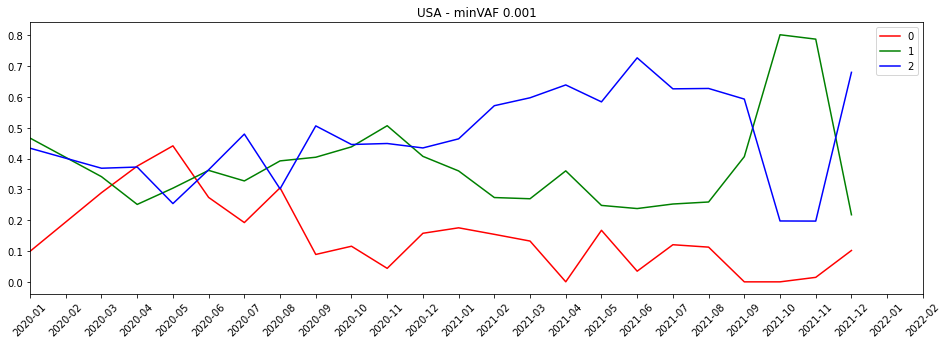

In [14]:
plot_probs(data, "USA", 0.001)

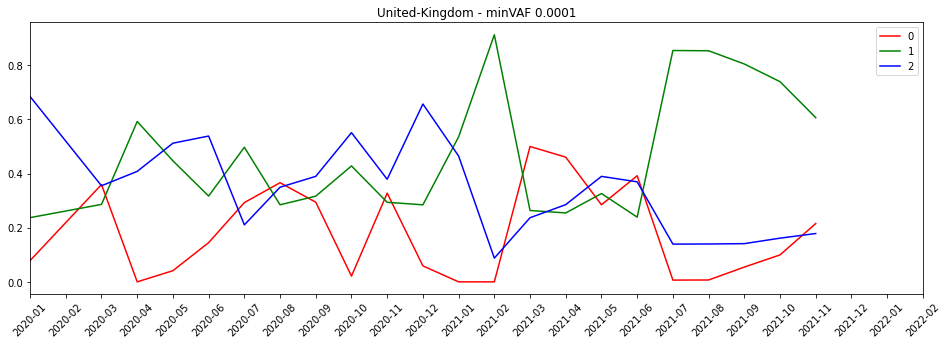

In [12]:
plot_probs(data, "United-Kingdom", 0.0001)

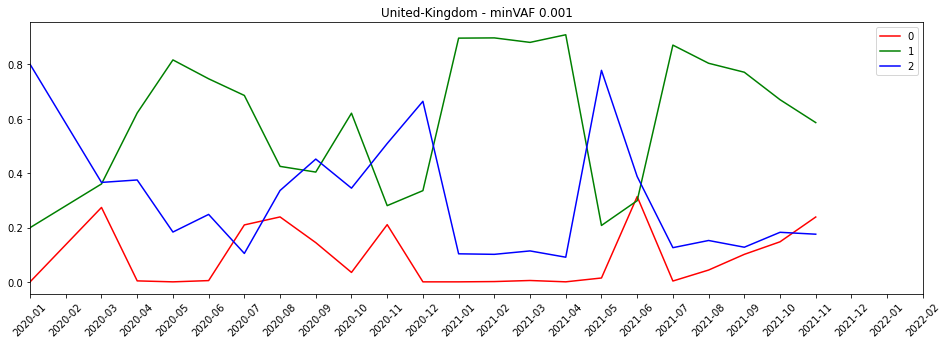

In [13]:
plot_probs(data, "United-Kingdom", 0.001)

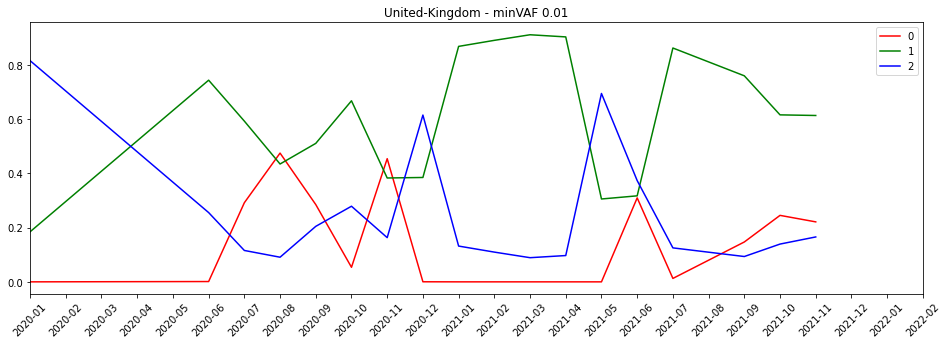

In [14]:
plot_probs(data, "United-Kingdom", 0.01)

In [15]:
with open(base_path_covid + "\EUClusters_data.json", "r") as f:
    case_counts = json.load(f)

In [16]:
cases = {key.replace(" ", "-"):values for key, values in case_counts["countries"].items()}

In [17]:
def get_freqs(case_data, country):
    cases = case_data[country].copy()
    week_mapping = dict()
    total_sequence_counts = np.array(cases.pop("total_sequences"))
    for i, week in enumerate(cases.pop("week")):
        week_mapping[i] = week[:7]
    variants = {month:{variant:0 for variant in cases.keys()} for month in week_mapping.values()}
    for i, count in enumerate(total_sequence_counts):
        month = week_mapping[i]
        variants[month]["count"] = variants[month].get("count", 0) + count
    for variant, counts in cases.items():
        for i, count in enumerate(counts):
            month = week_mapping[i]
            variants[month][variant] += count
    freqs = dict()
    for month, values in variants.items():
        total_count = values.pop("count")
        frequencies = {variant:var_count/total_count for variant, var_count in values.items()}
        freqs[month] = frequencies
    return freqs

In [18]:
all_variants = set()
for var in cases.values():
    all_variants =all_variants.union(set(var.keys()))
all_variants = all_variants.difference({"week", "total_sequences"})

In [19]:
variant_names = [
    '20I (Alpha, V1)',
    '20H (Beta, V2)',
    '20J (Gamma, V3)',
    '21A (Delta)',
    '21I (Delta)',
    '21J (Delta)',
    '21K (Omicron)',
    '21L (Omicron)',
    '21B (Kappa)',
    '21D (Eta)',
    '21F (Iota)',
    '21G (Lambda)',
    '21H (Mu)',
    '20E (EU1)',
    '21C (Epsilon)',
    '20B/S:732A',
    '20A/S:126A',
    '20A/S:439K',
    'S:677H.Robin1',
    'S:677P.Pelican',
    '20A.EU2',
    '20A/S:98F',
    '20C/S:80Y',
    '20B/S:1122L',
    '20B/S:626S'
]
variant_colors = [
    # alpha
    "royalblue",
    # beta
    "violet",
    # gamma
    "teal",
    # delta
    "lightsalmon",
    "tomato",
    "salmon",
    # omicron
    "lightpink",
    "pink",
    # kappa
    "navajowhite",
    # eta
    "blanchedalmond",
    # iota
    "moccasin",
    # lambda
    "wheat",
    # mu
    "lemonchiffon",
    # EU1
    "gold",
    # epsilon
    "bisque",
    # other
    "lightyellow",
    "beige",
    "cornsilk",
    "khaki",
    "palegoldenrod",
    "peachpuff",
    "mistyrose",
    "paleturquoise",
    "lightcyan",
    "snow",
    "linen",
    "lavenderblush"
]
variant_color_mapping = {name:color for name,color in zip(variant_names, variant_colors)}

In [20]:
def stack_and_line_plot(cases, data, country, filtering, gaps = False, vertical_lines = False):
    country_freqs = get_freqs(cases, country)
    country_data = data[country]
    fig, ax = plt.subplots(figsize=(16,10), dpi=200)
    all_figures.add(fig)
    x,y = list(zip(*sorted(
        [
            (label_positions[date], values[filtering]) for date, values in country_data.items() if filtering in values
        ], key=lambda x:x[0])))
    y = np.array(y)
    colors = ["fuchsia", "r", "darkblue"]
    mutations = [f"{i} subclones" for i in range(3)]
    
    if vertical_lines:
        for i in x:
            ax.axvline(i, color="gray", linestyle=["--", "-."][i%2], alpha=0.3)
    
    variant_names = list(country_freqs[list(country_freqs.keys())[0]].keys())
    fractions = np.array(list(
        map(lambda x:np.array(list(x[1].values())), sorted(country_freqs.items(), key = lambda x:x[0]))
    ))
    ax.stackplot(sorted(map(lambda f:label_positions[f], country_freqs.keys())), fractions.T,
                 labels=variant_names, colors=[variant_color_mapping[n] for n in variant_names if n in variant_color_mapping],
                 alpha=0.75)
    
    if gaps:
        y_new = np.full([len(labels), y.shape[1]], np.nan)
        for i, index in enumerate(x):
            y_new[index] = y[i]
        [ax.plot(y_new[:,i], color=colors[i], label=mutations[i]) for i in range(3)]
        [ax.scatter(np.arange(len(labels)),y_new[:,i], color=colors[i], alpha=1) for i in range(3)]
    else:
        [ax.plot(x, y[:,i], color=colors[i], label=mutations[i]) for i in range(3)]
        [ax.scatter(x, y[:,i], color=colors[i], alpha=1) for i in range(3)]
        
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=45)
    ax.set_xlim(0,len(labels)-1)
    ax.set_title(f"{country} - minVAF {filtering}")
    ax.legend(loc="upper left")

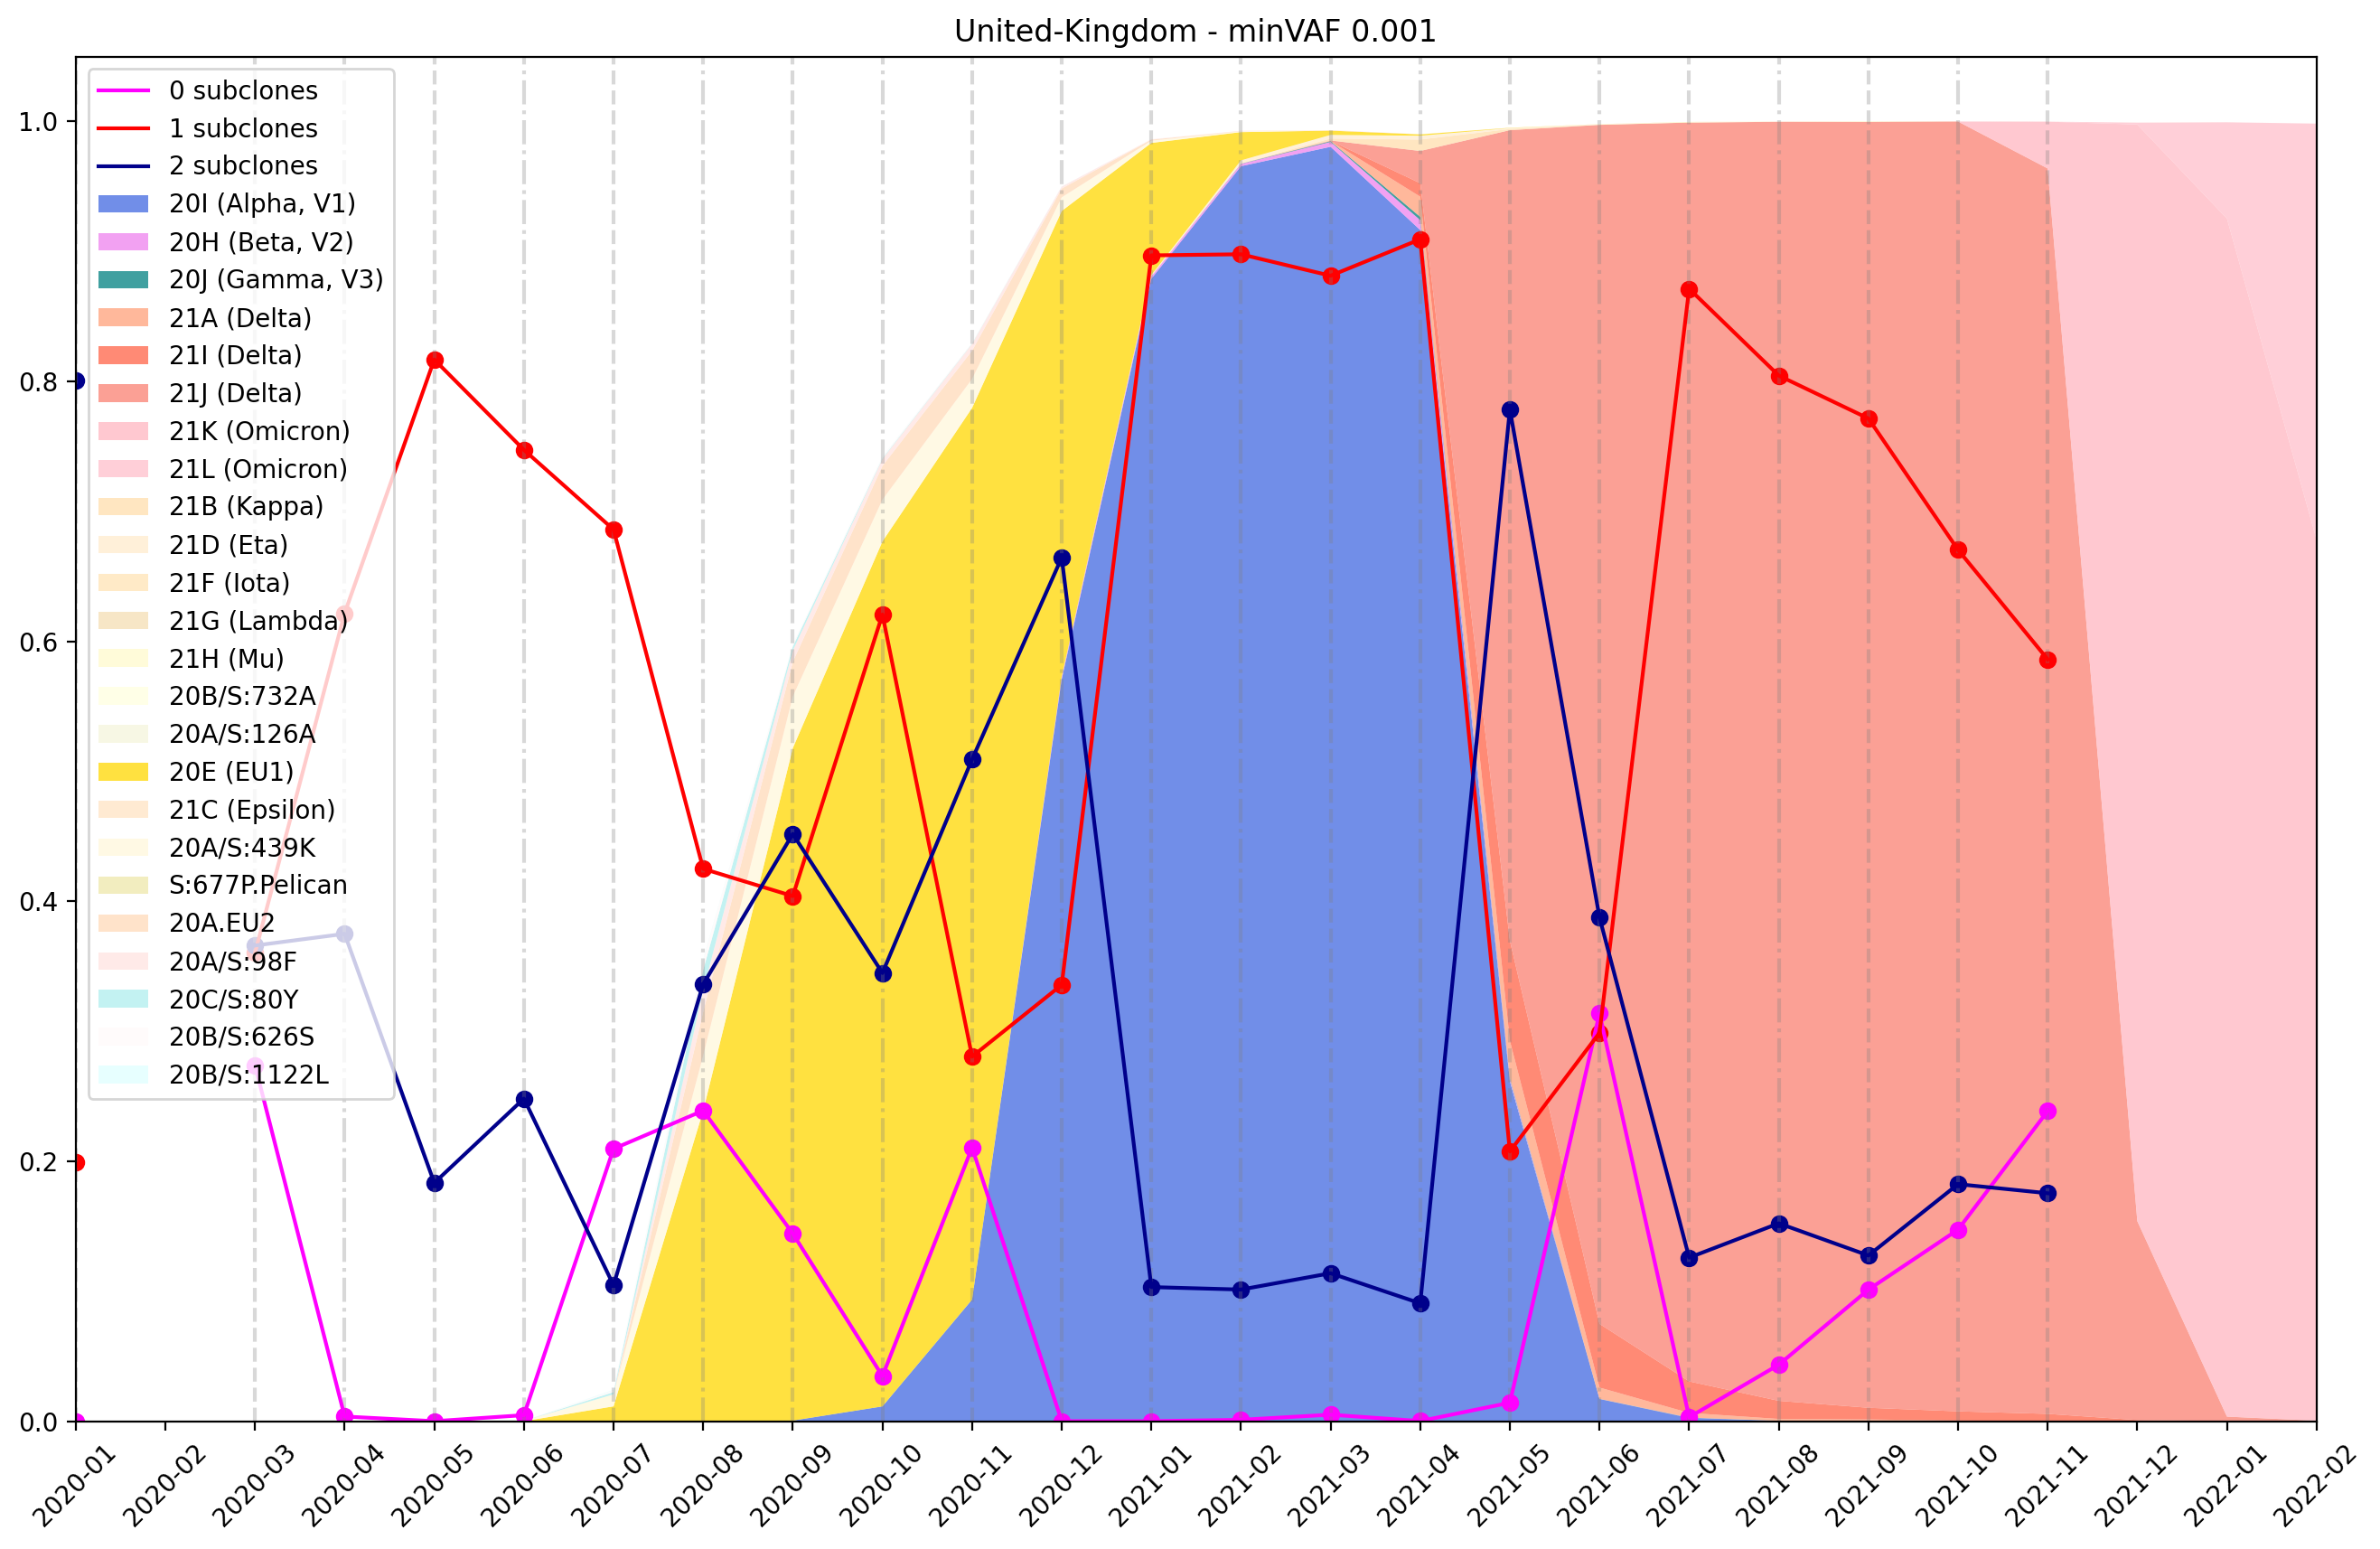

In [23]:
stack_and_line_plot(cases, data, "United-Kingdom", 0.001, vertical_lines=True, gaps=True)

---

In [24]:
shared_countries = set(data.keys()) & set(cases.keys())

In [25]:
useful_countries = ["Bangladesh", "Slovakia", "Mexico", "USA", "United-Kingdom", "Bahrain", "New-Zealand", "Egypt", "Japan", "Austria", "Djibouti", "India"]

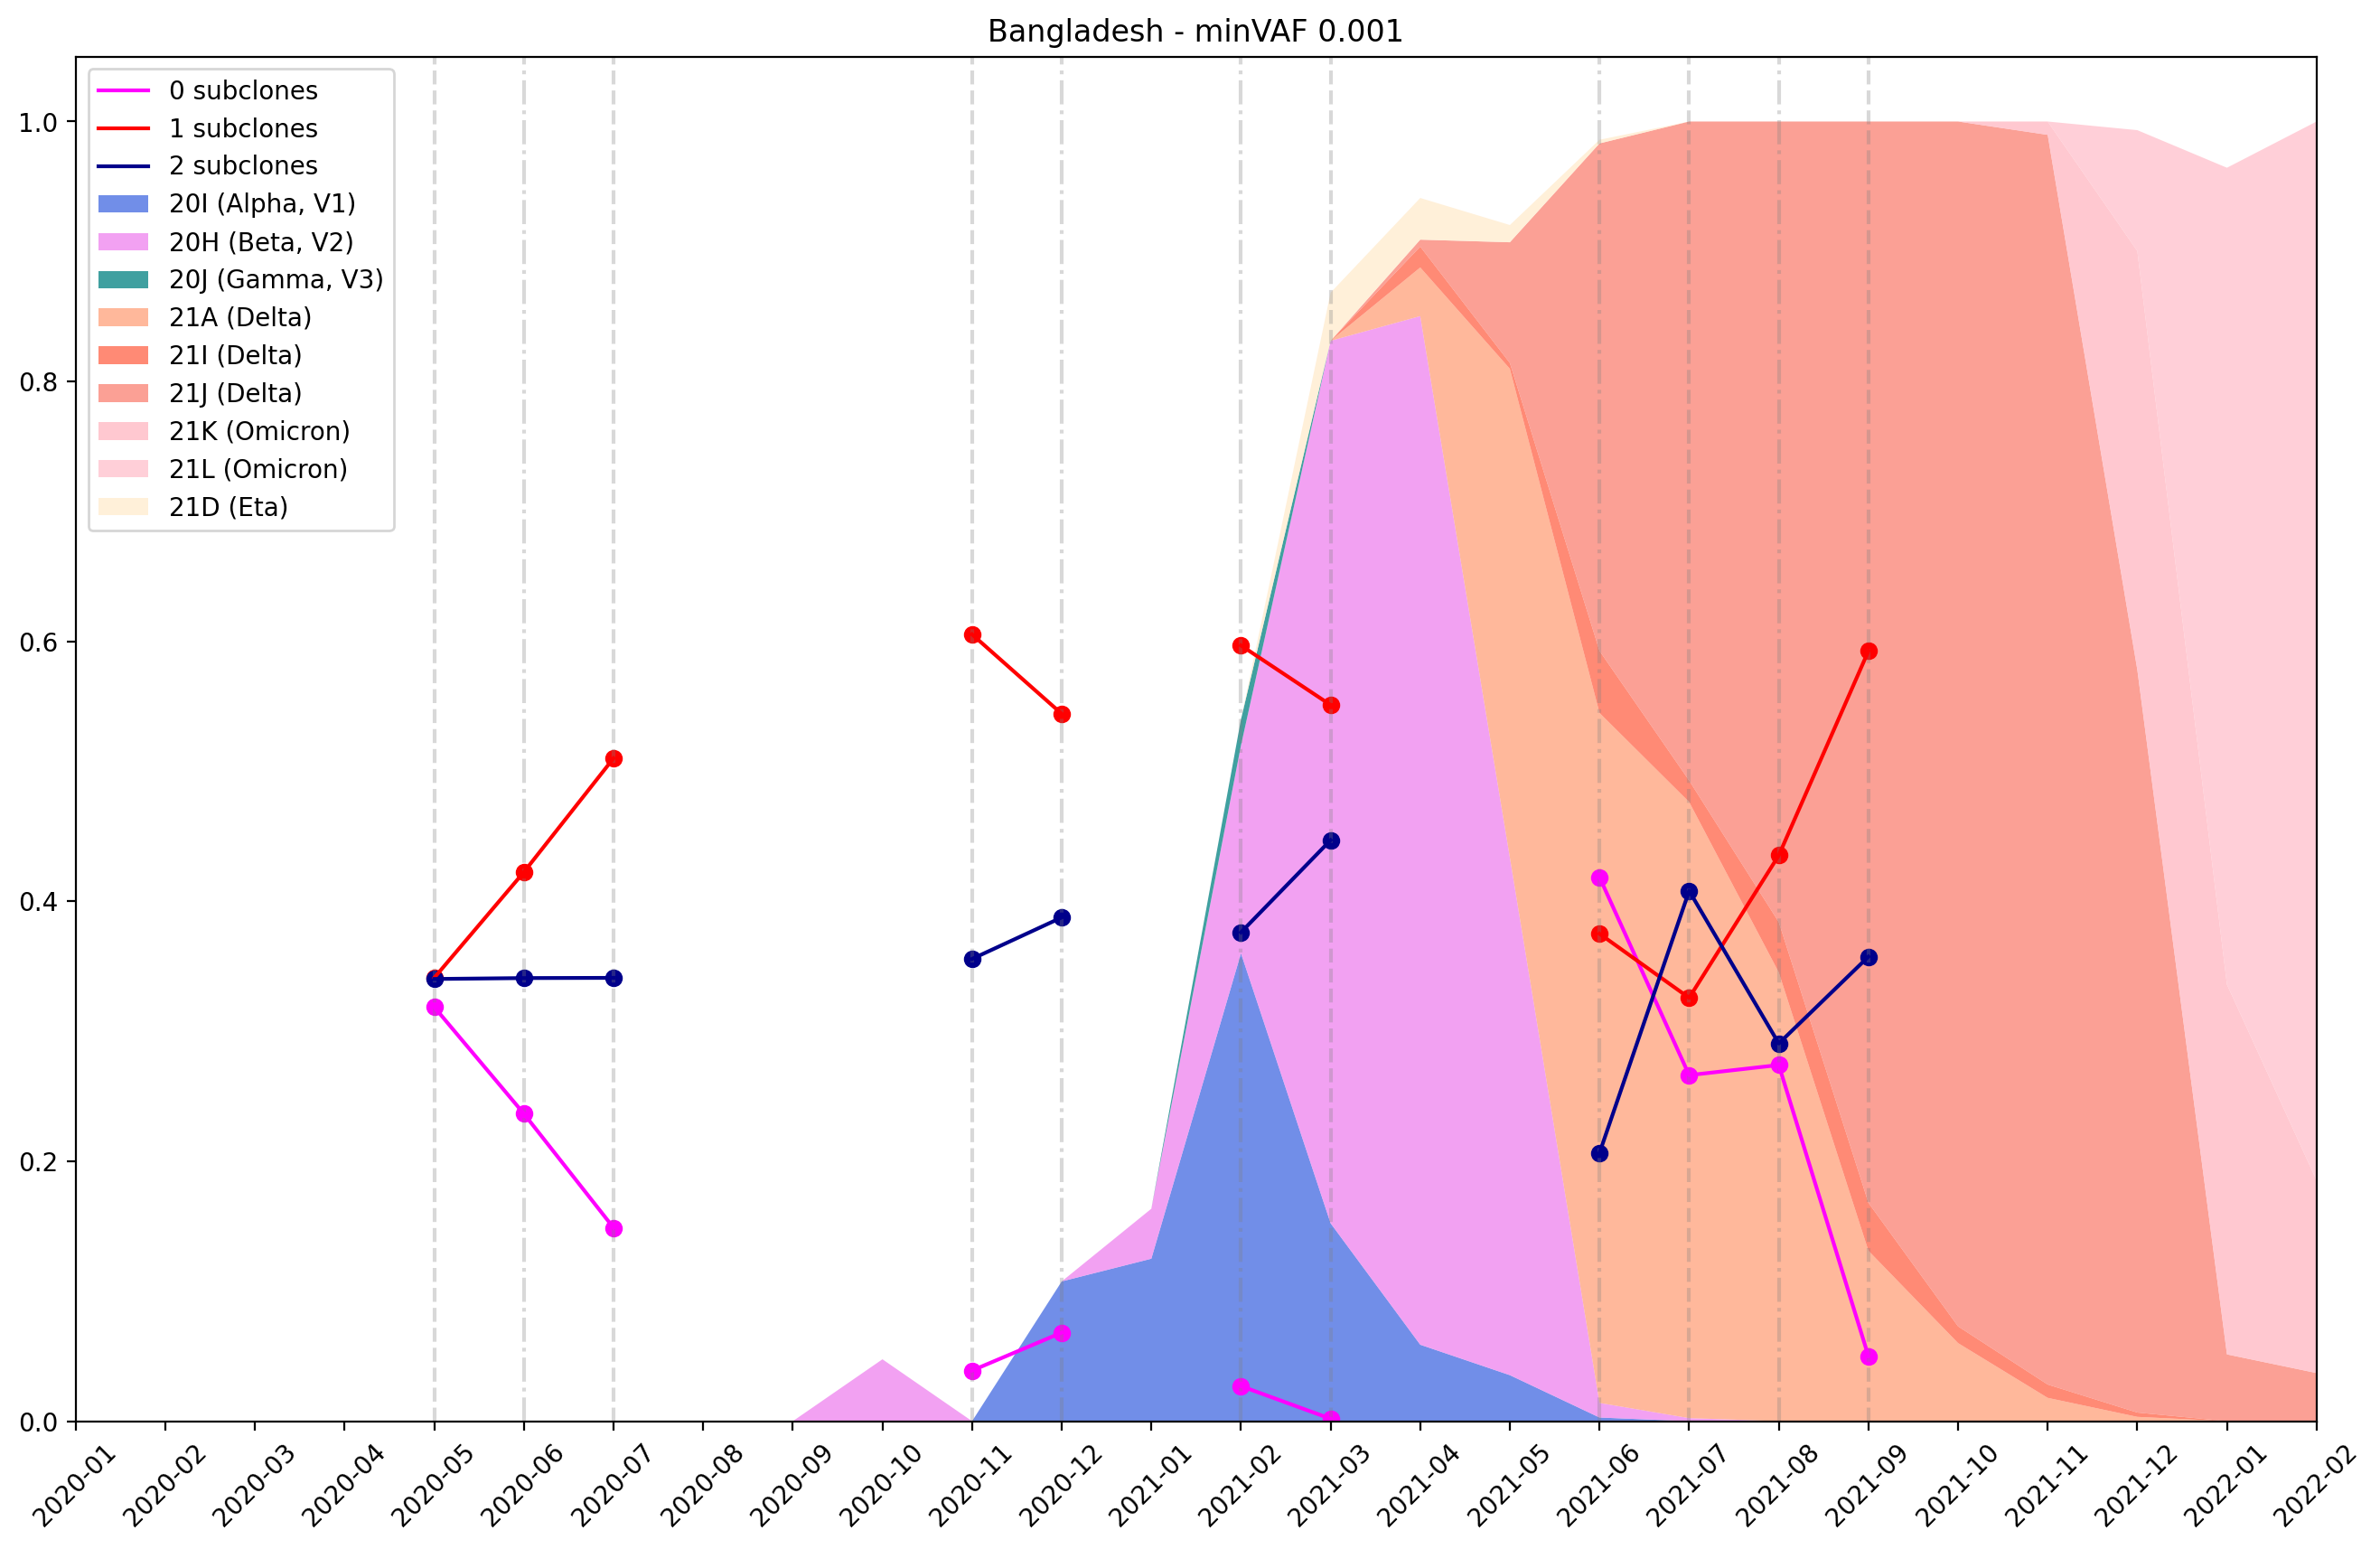

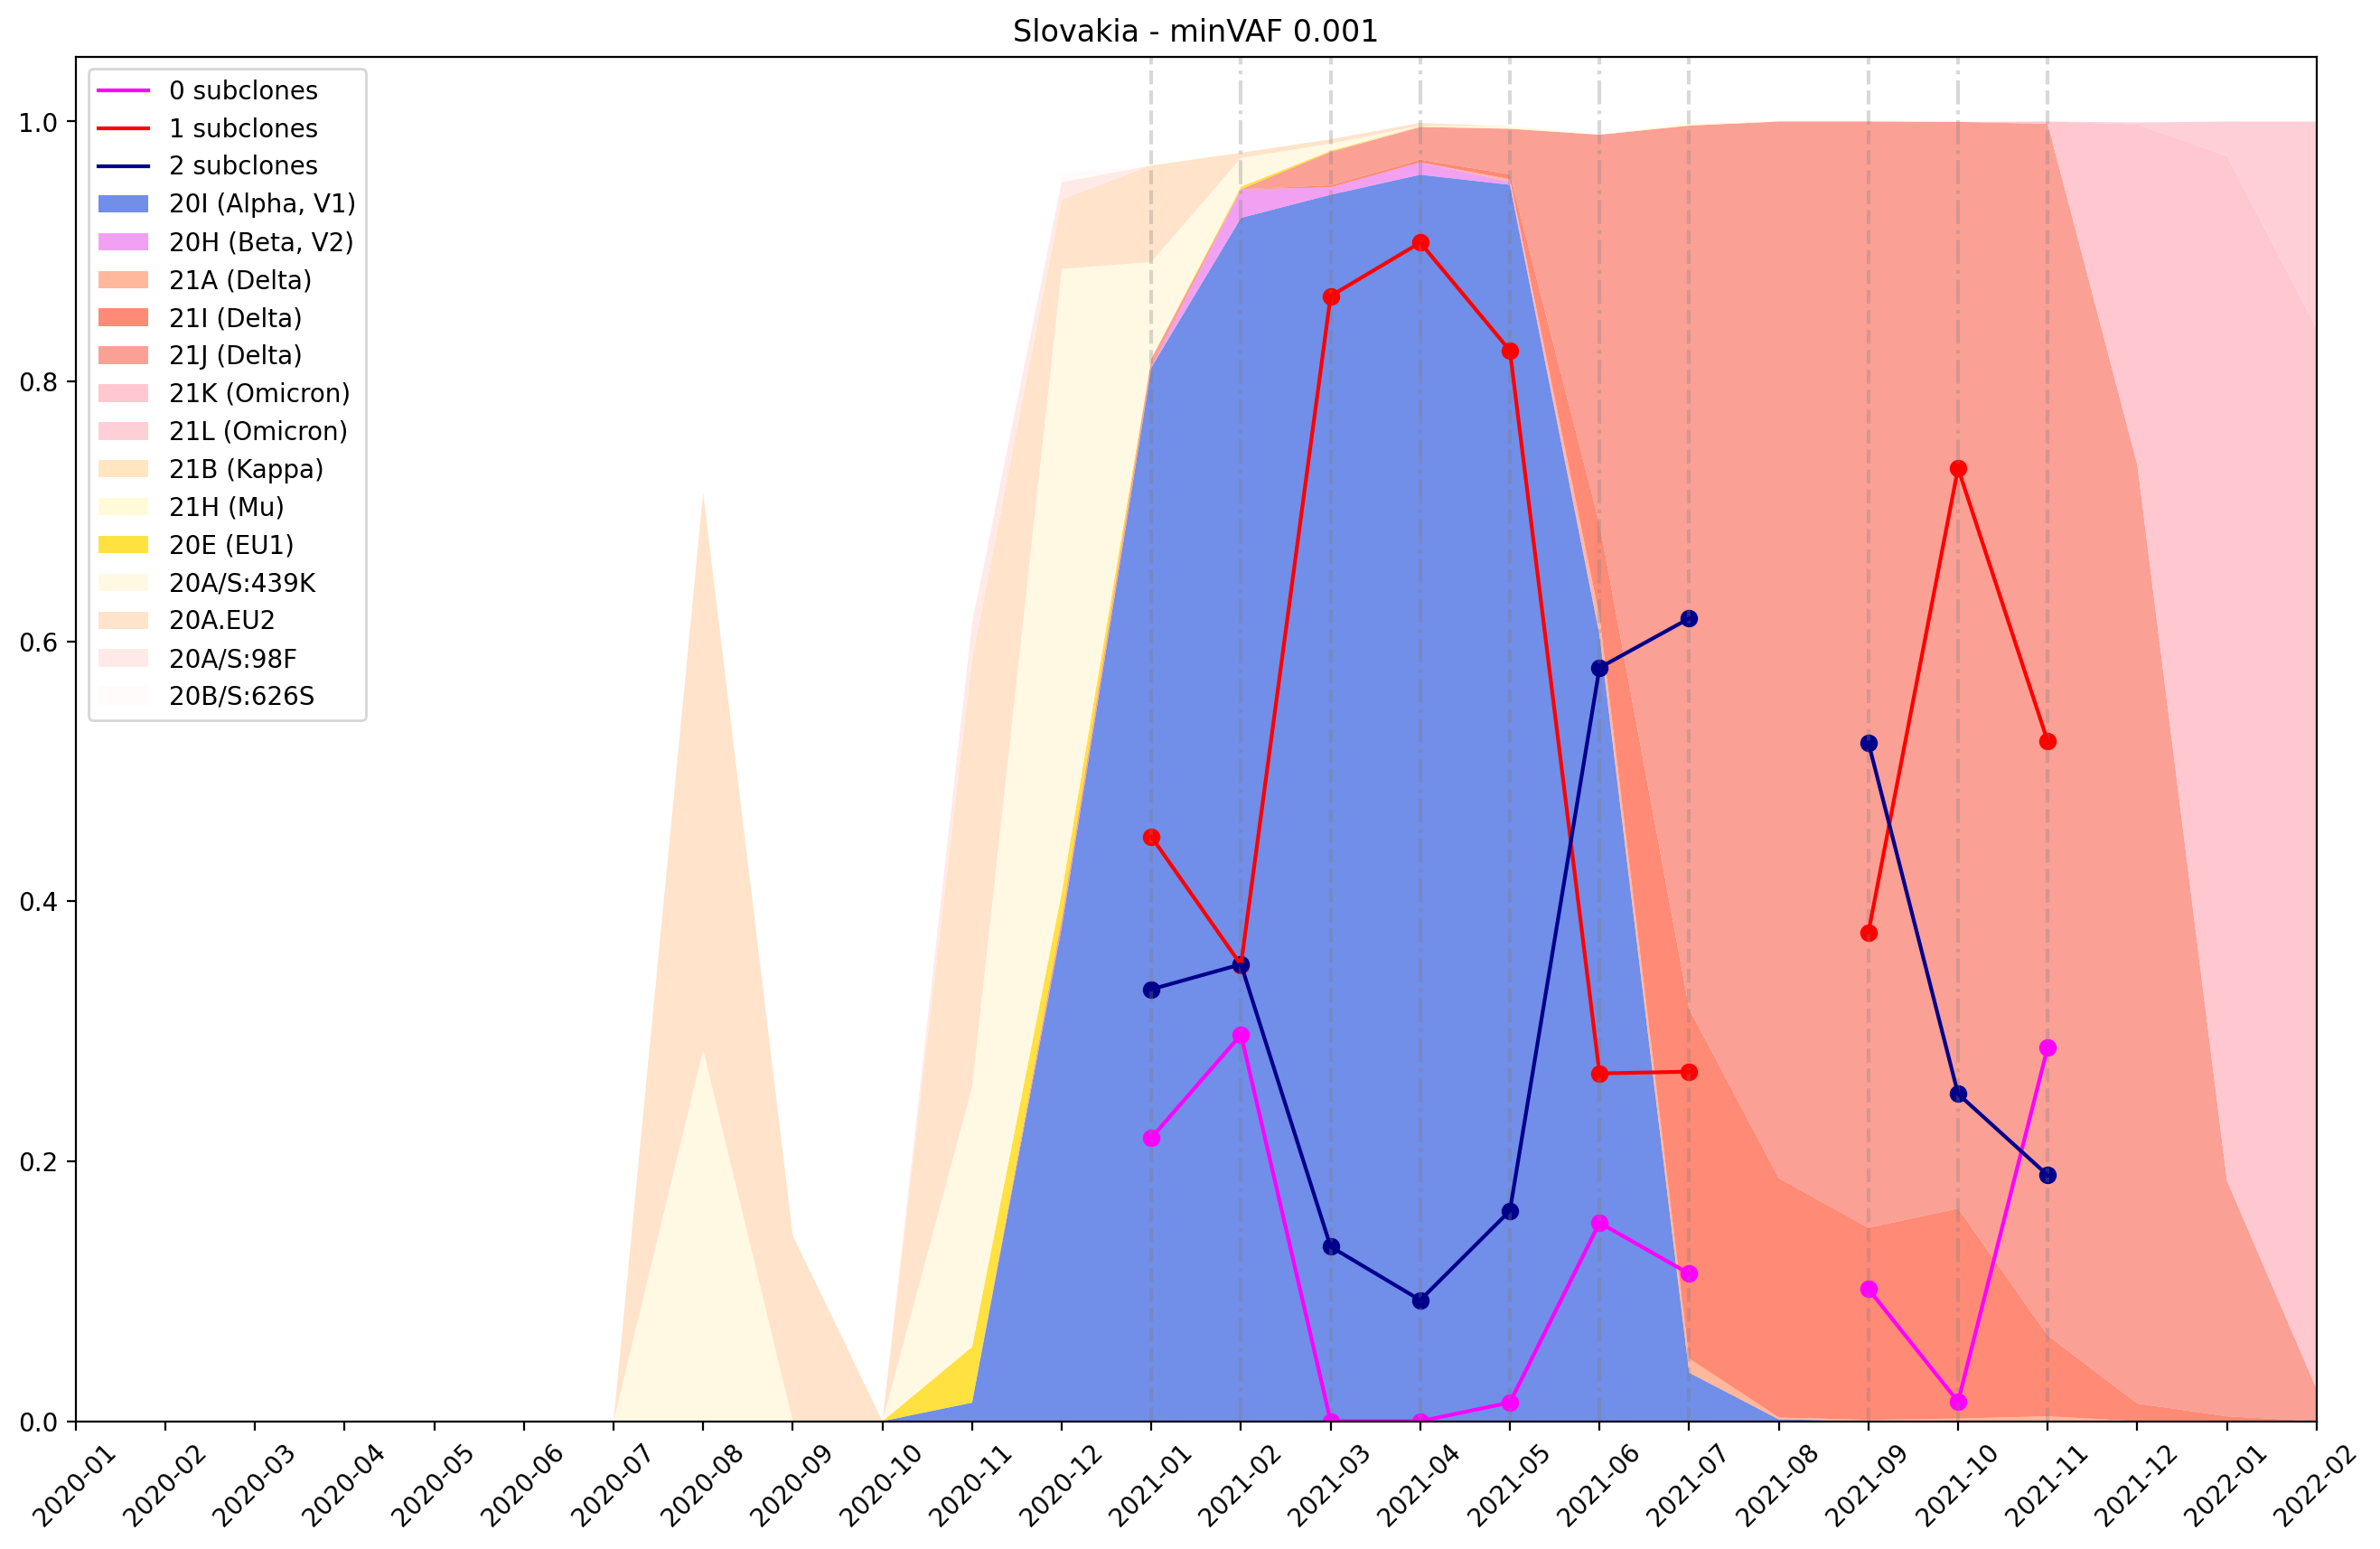

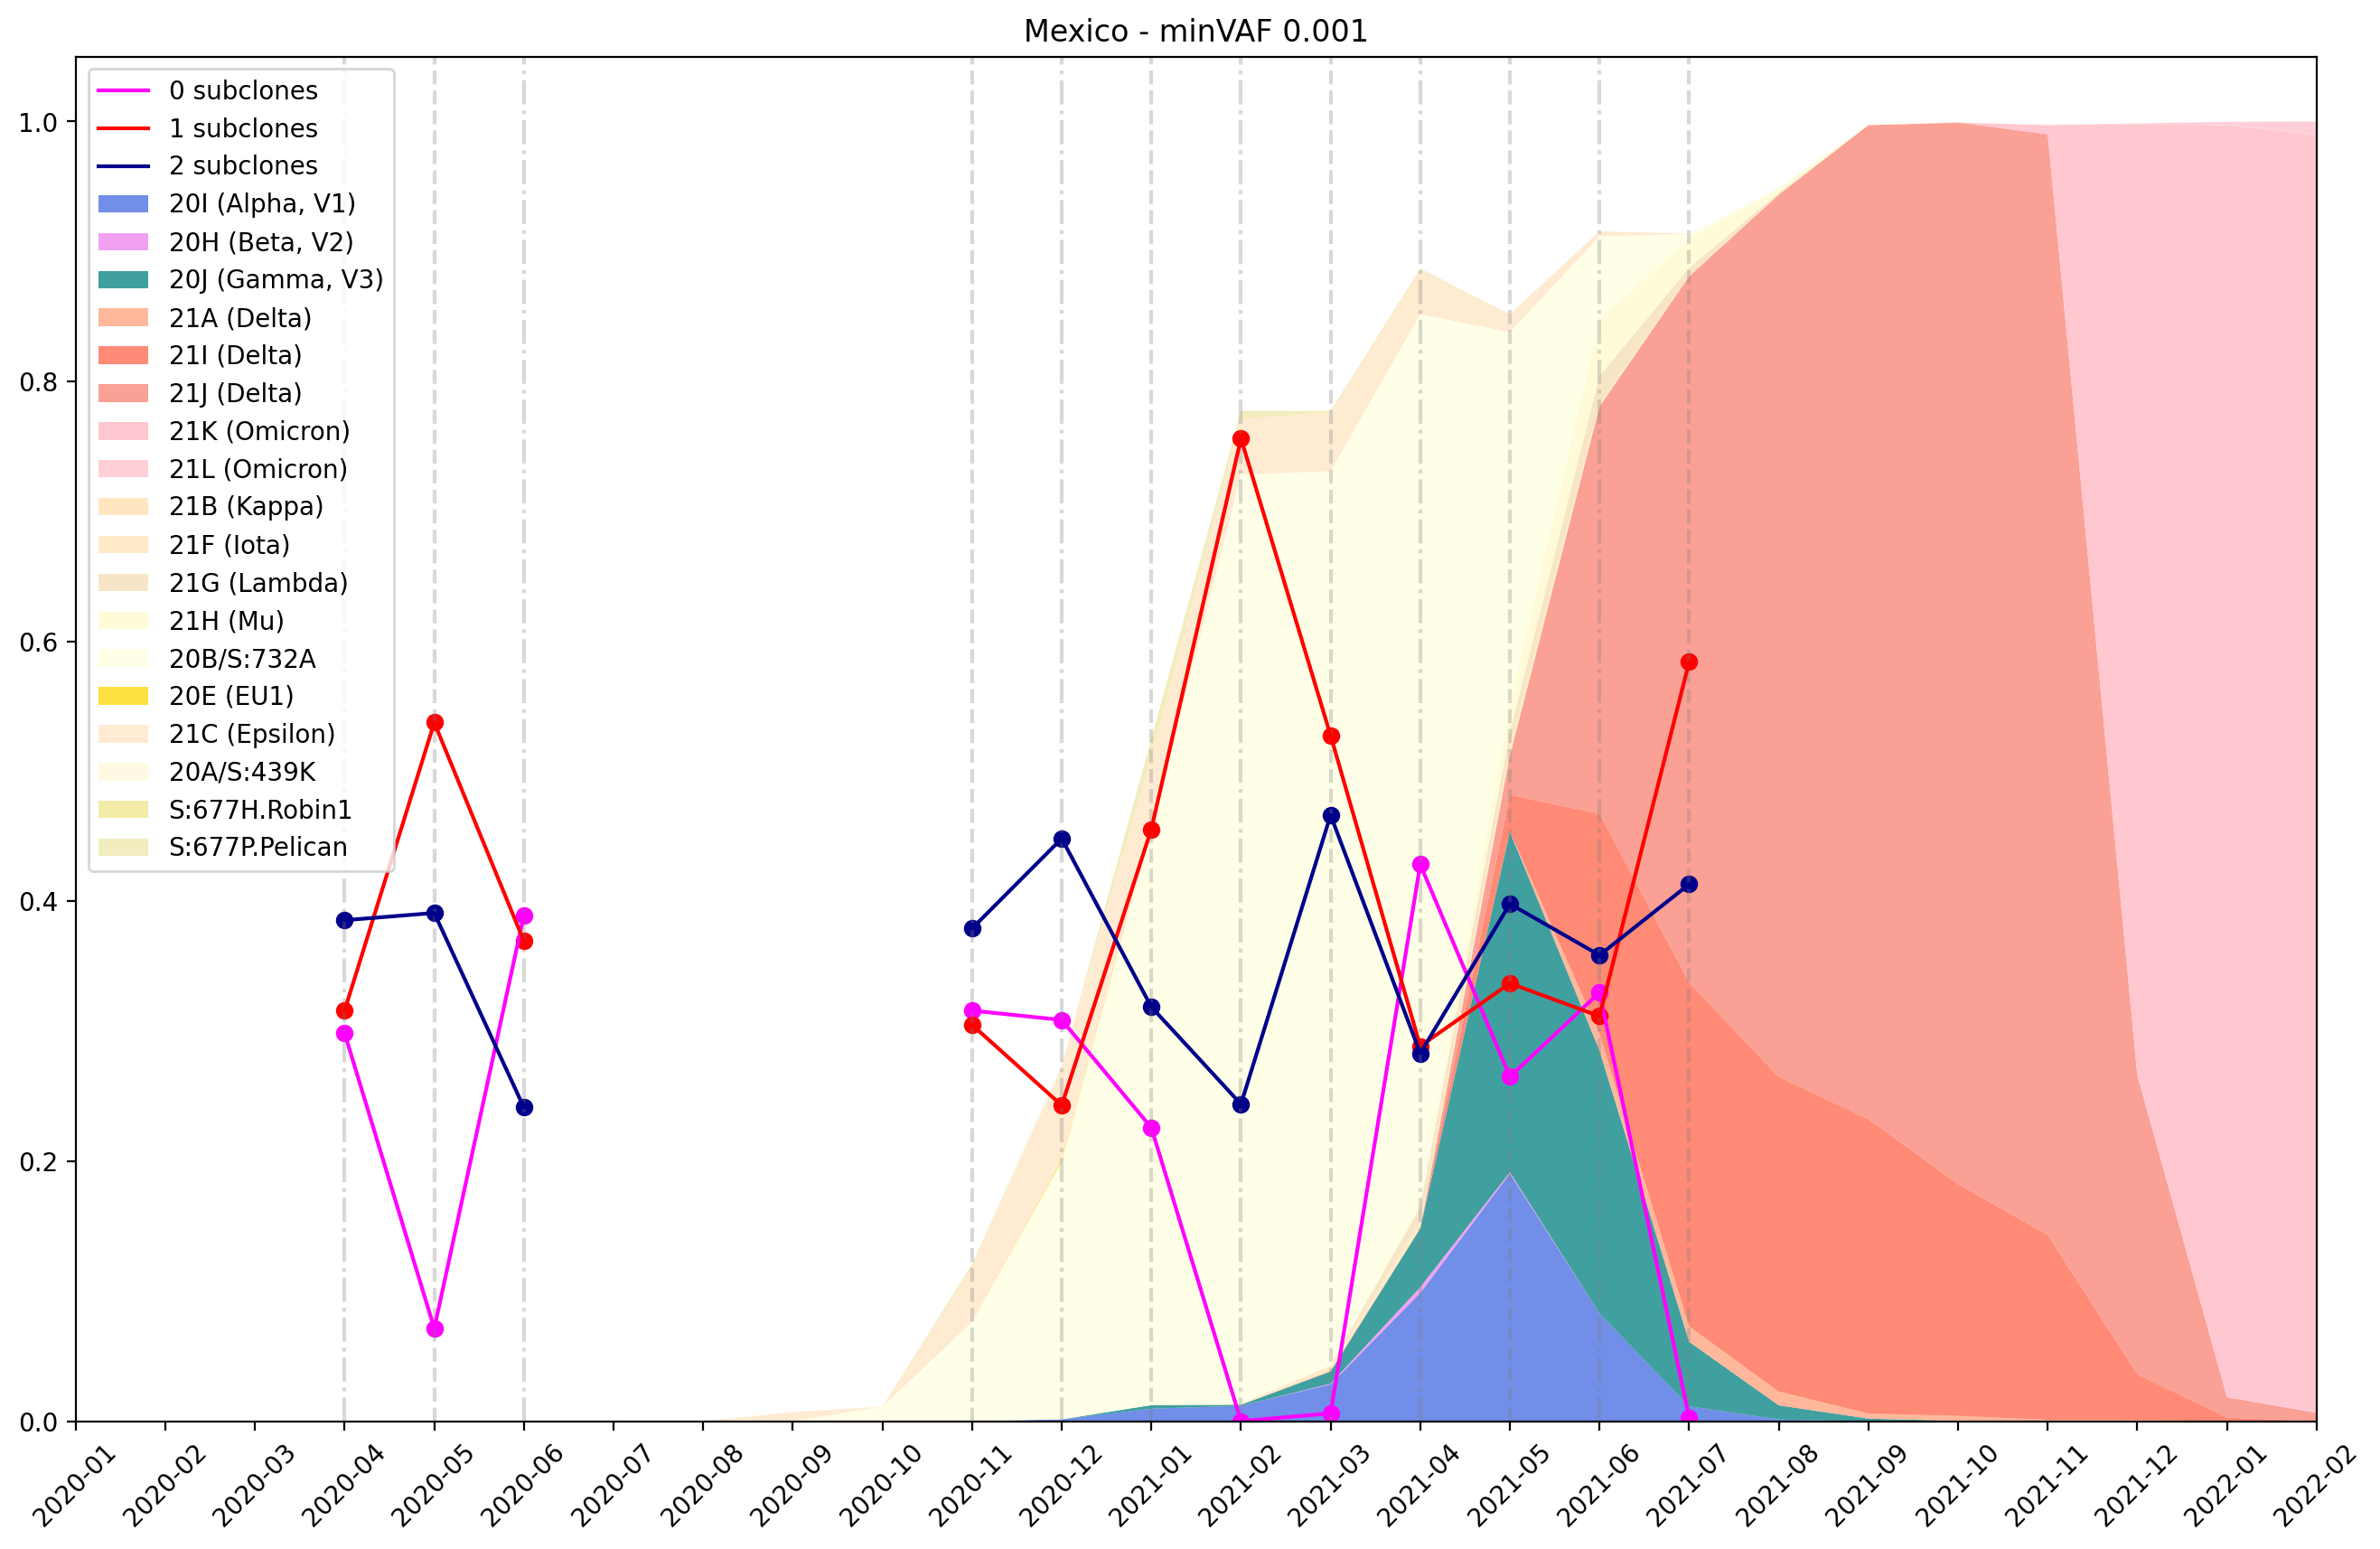

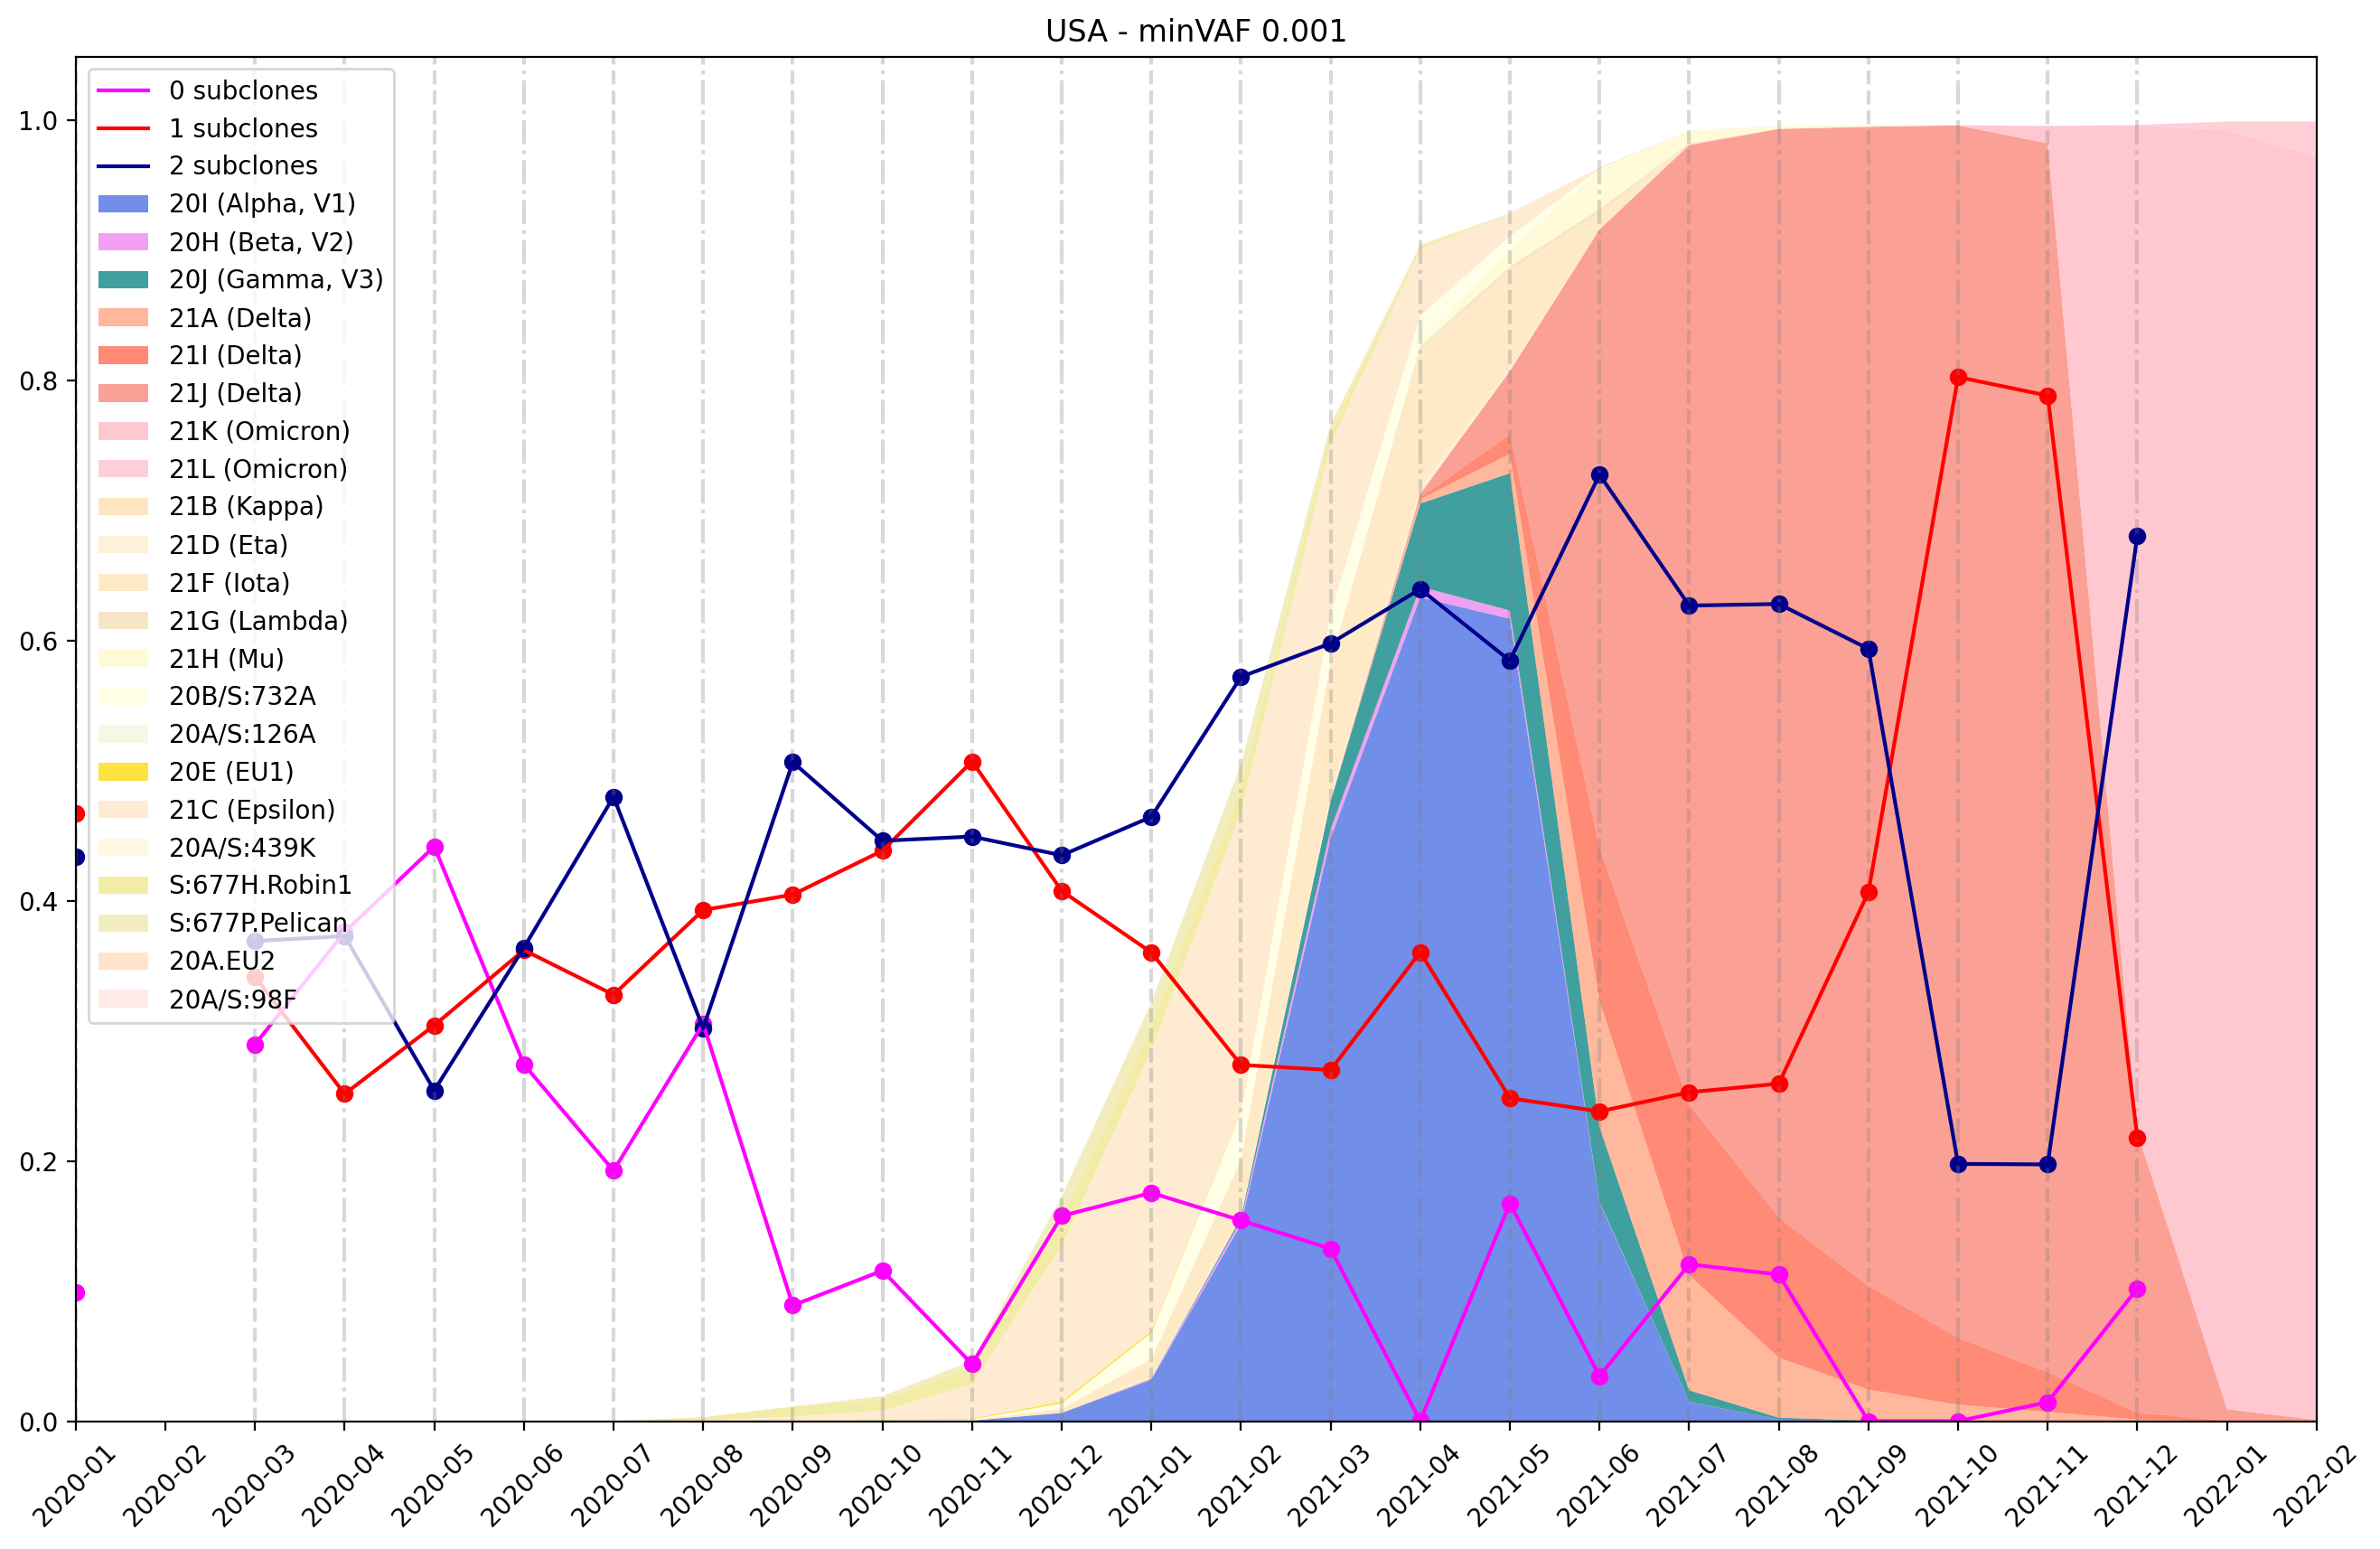

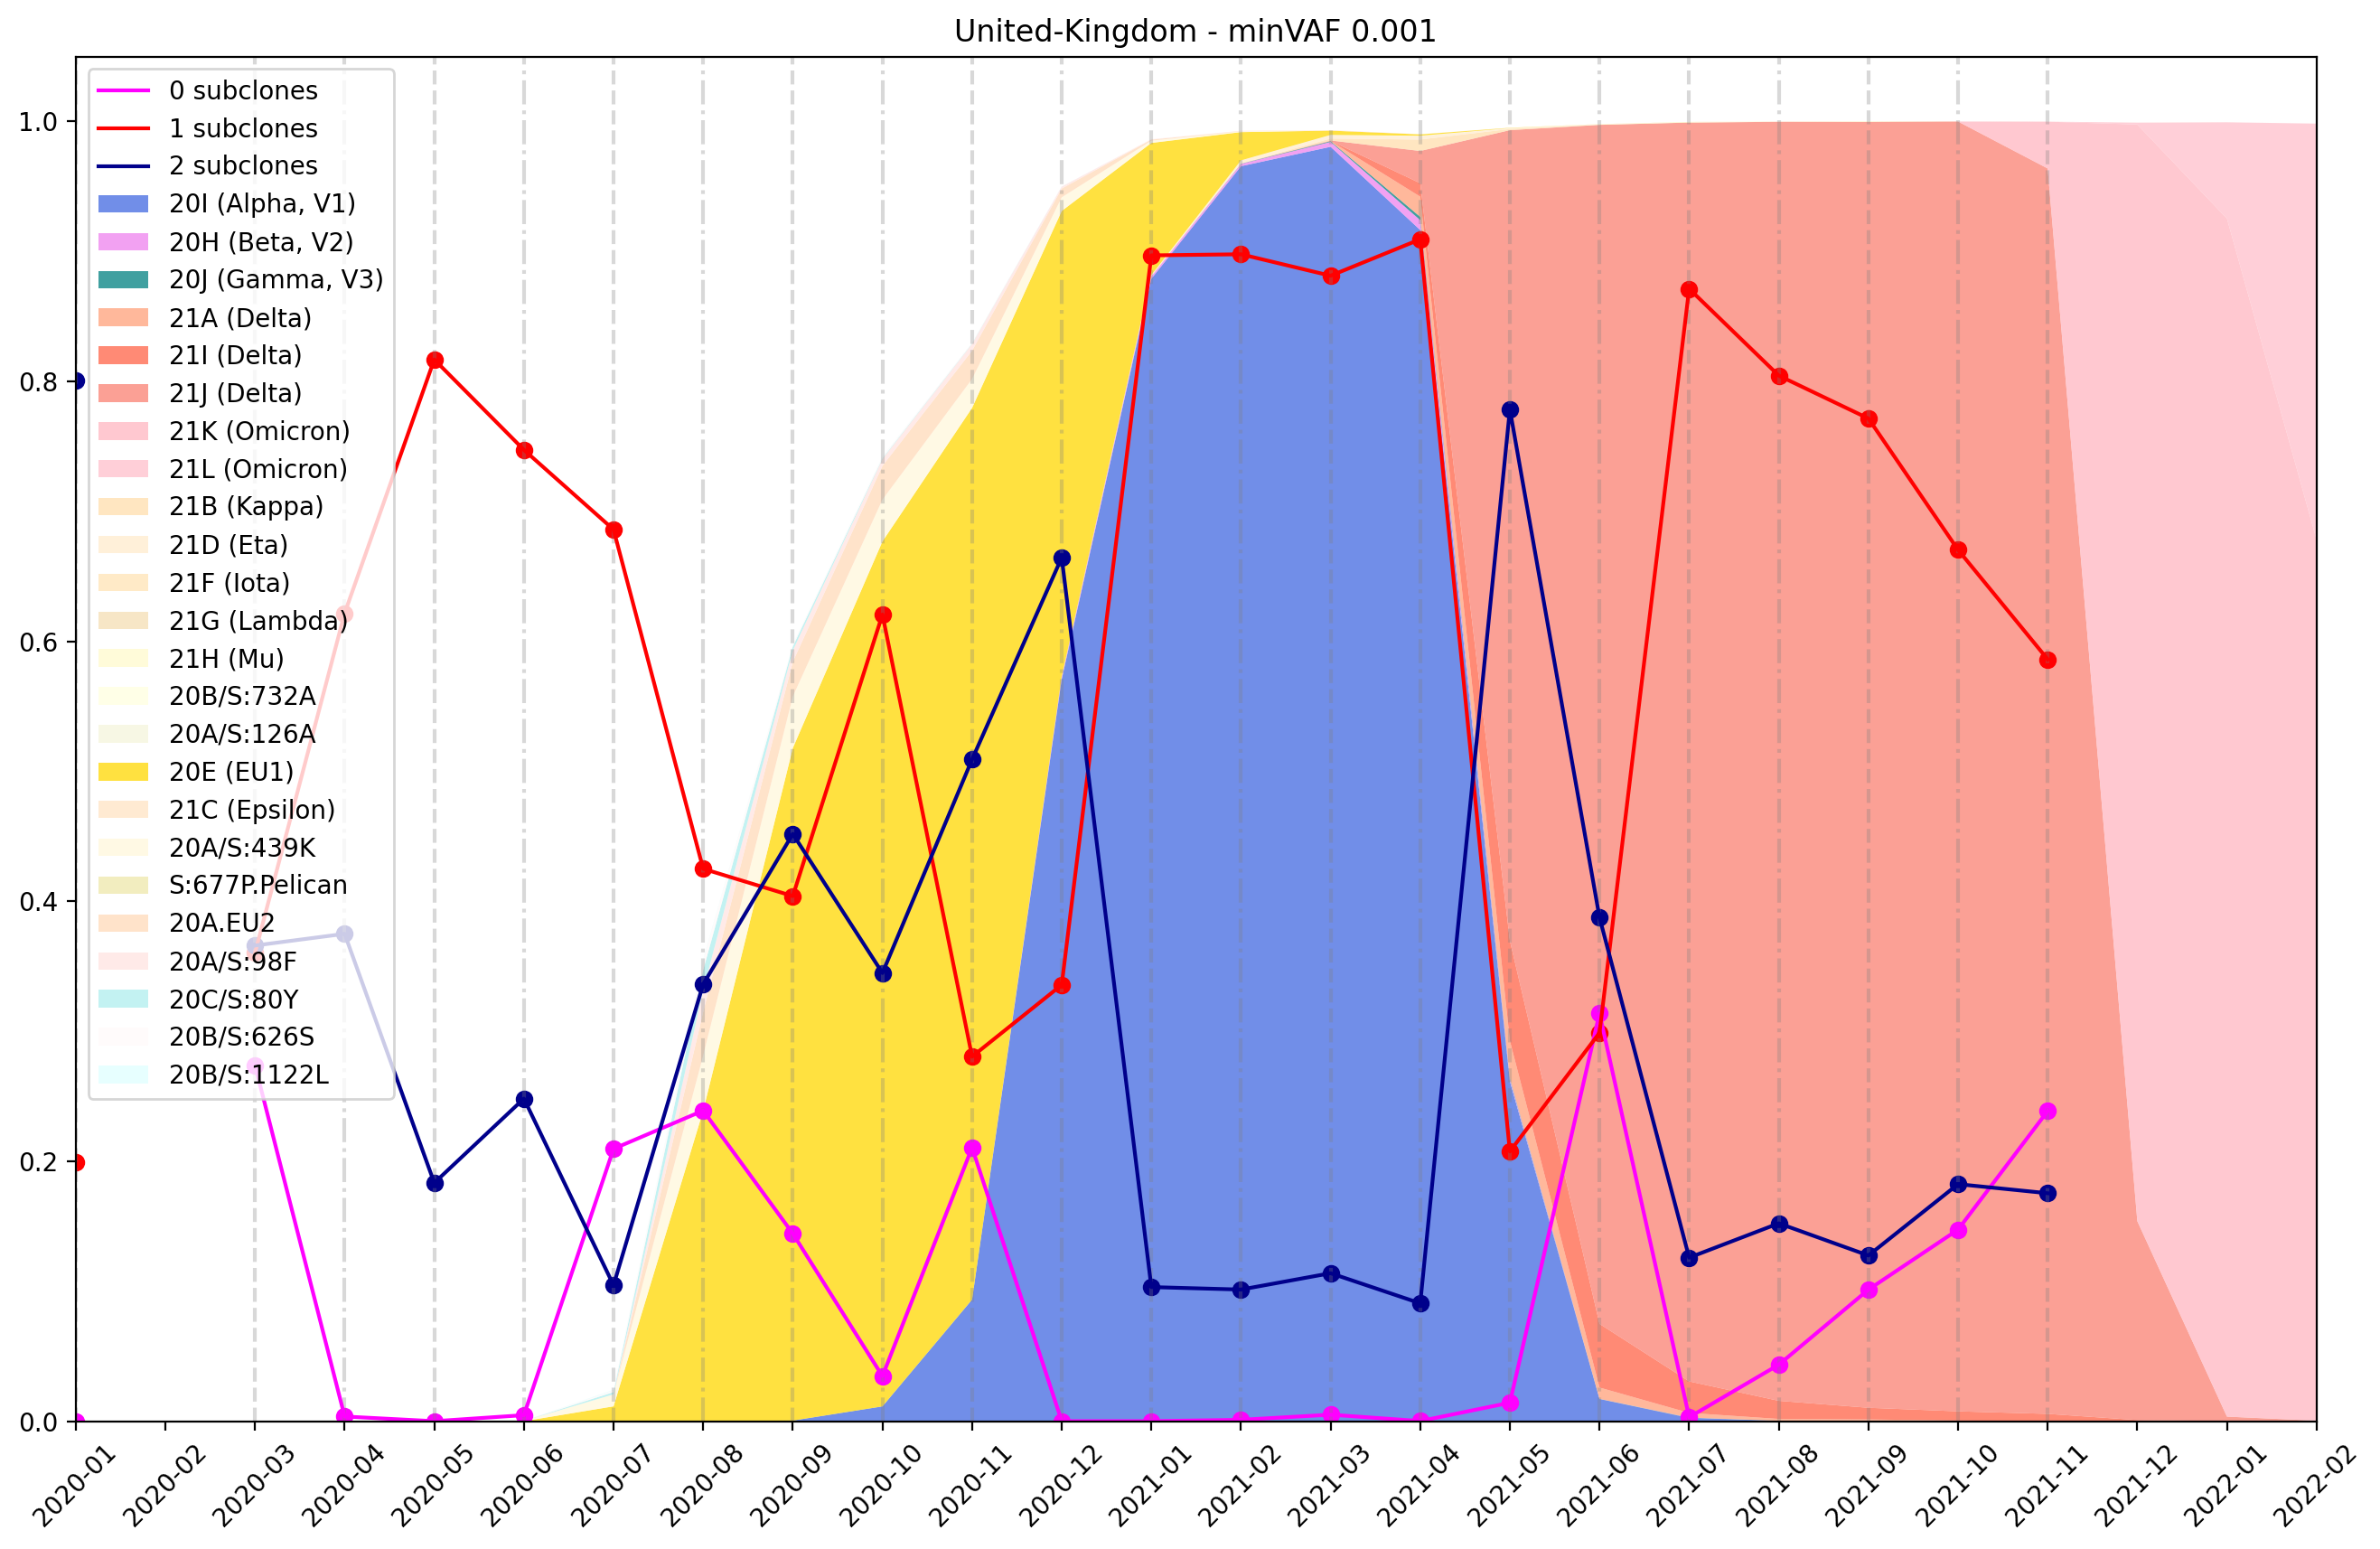

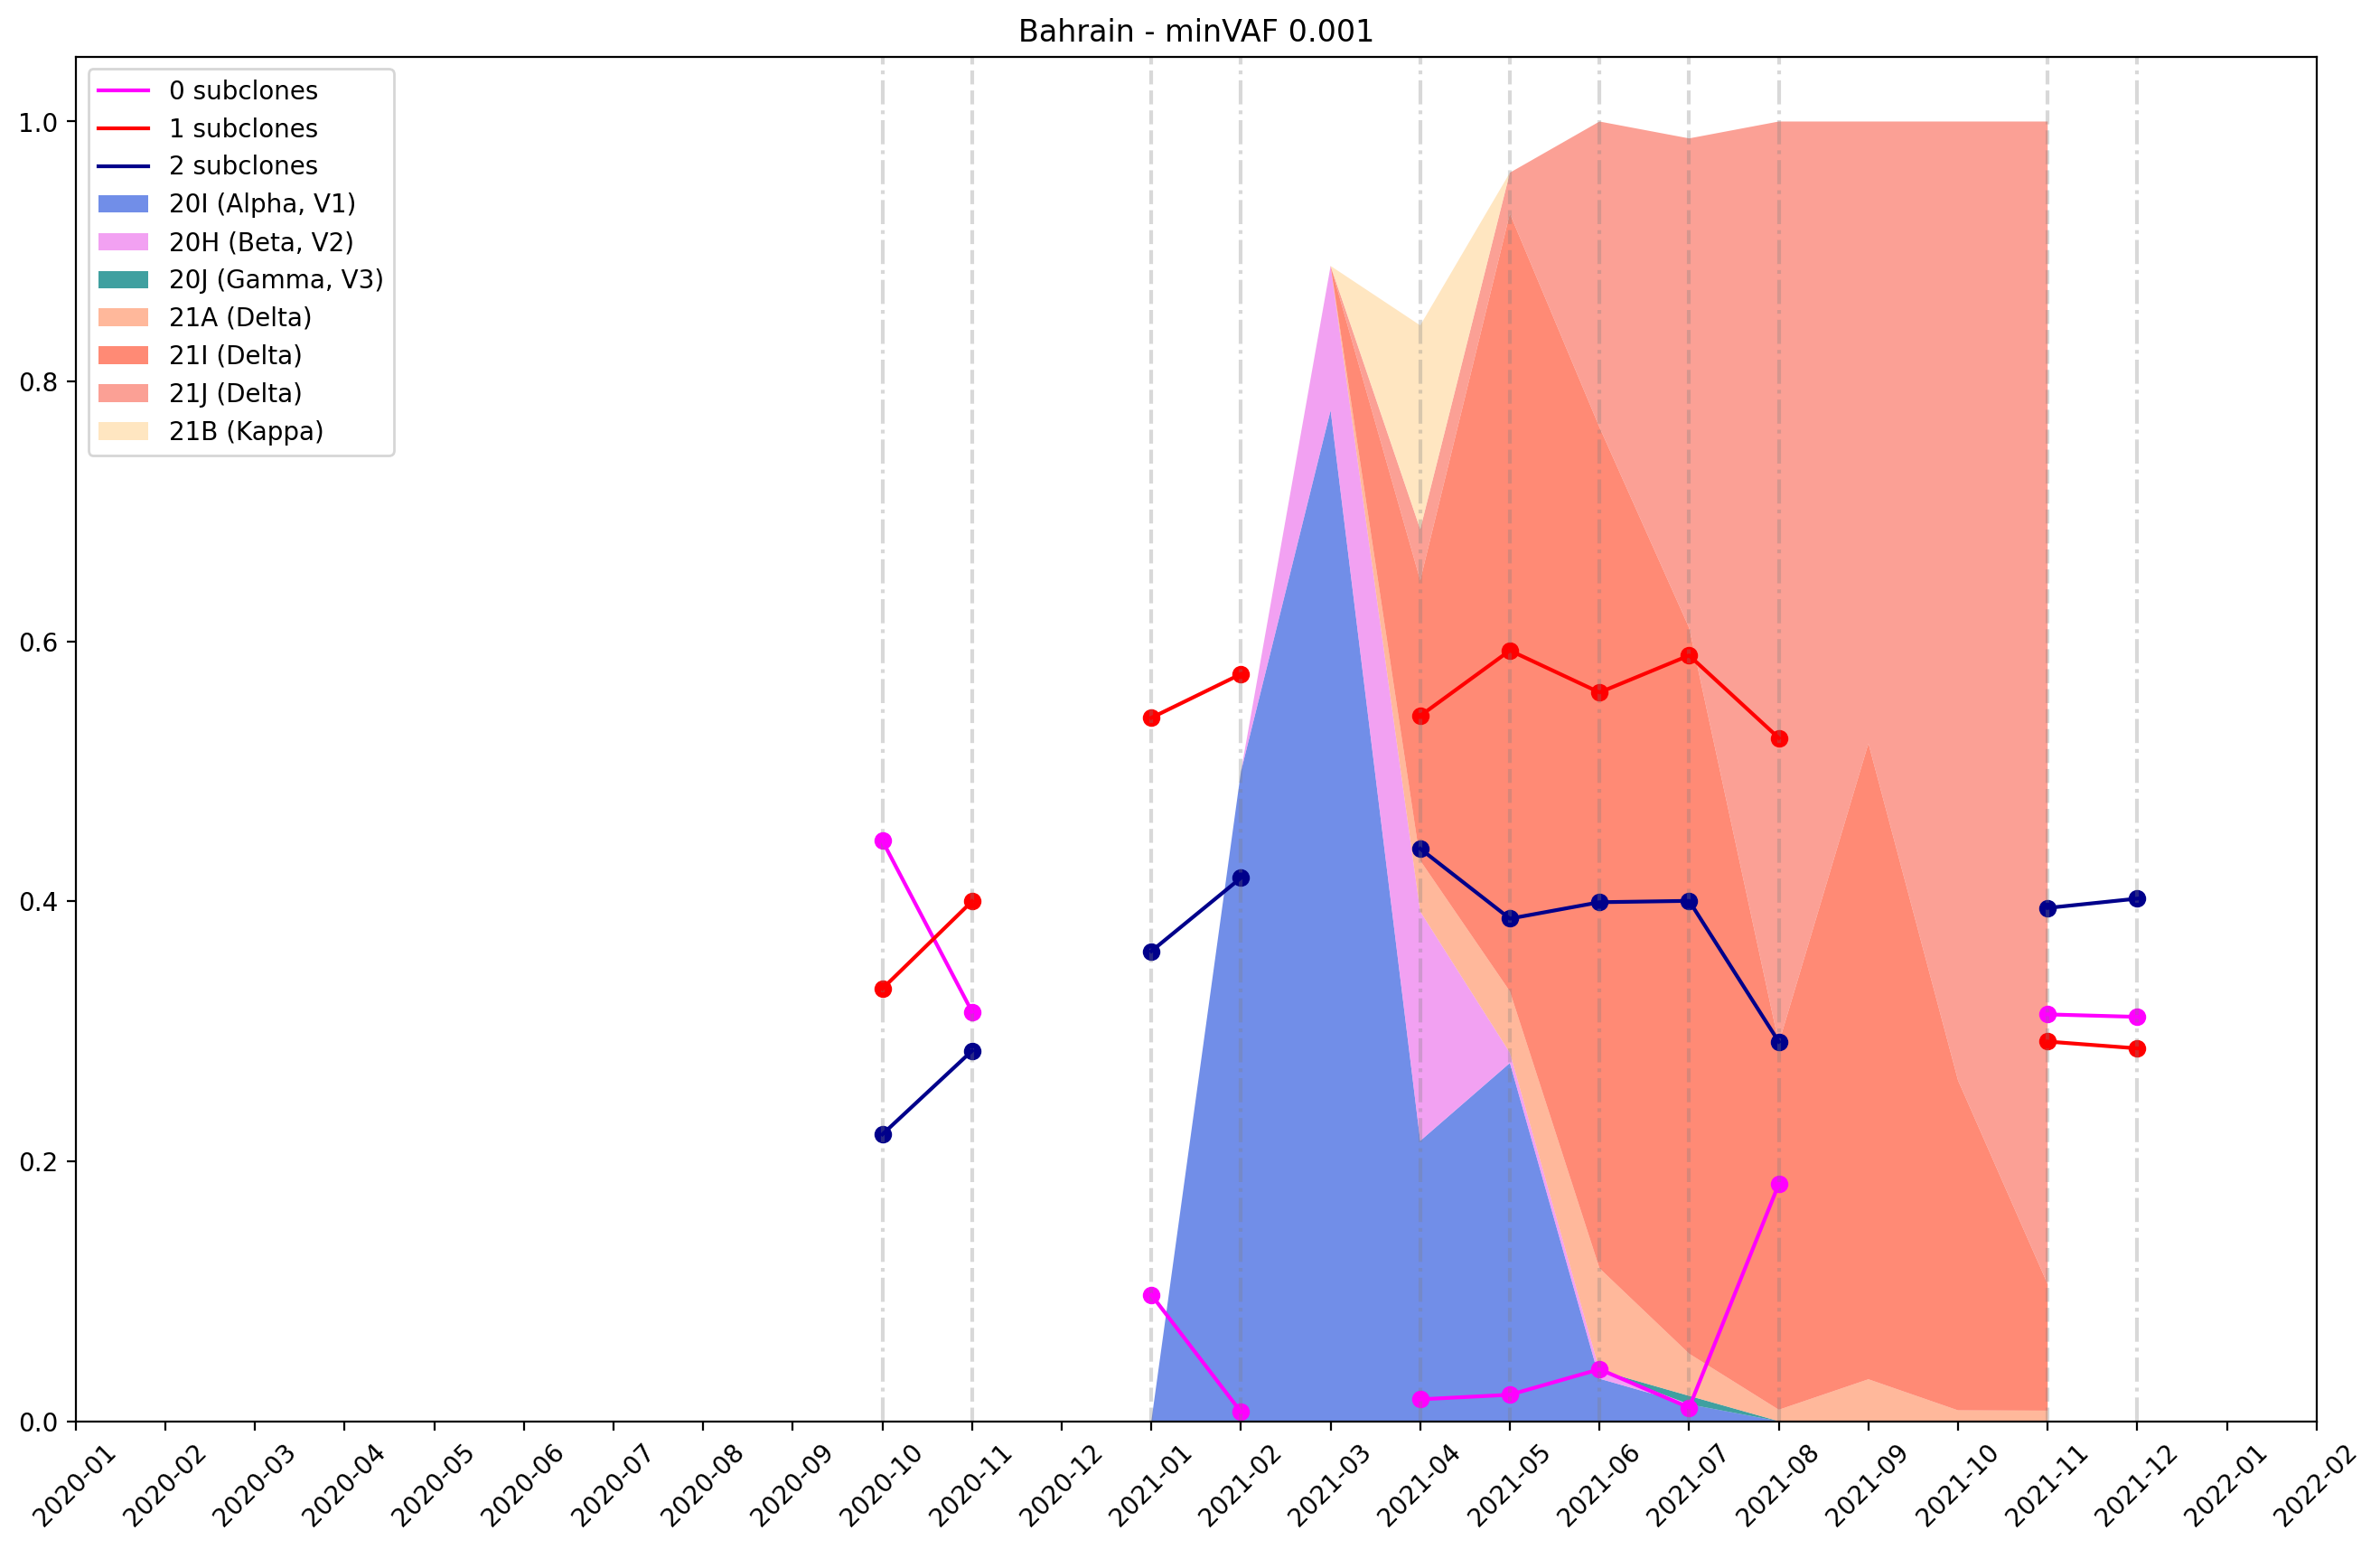

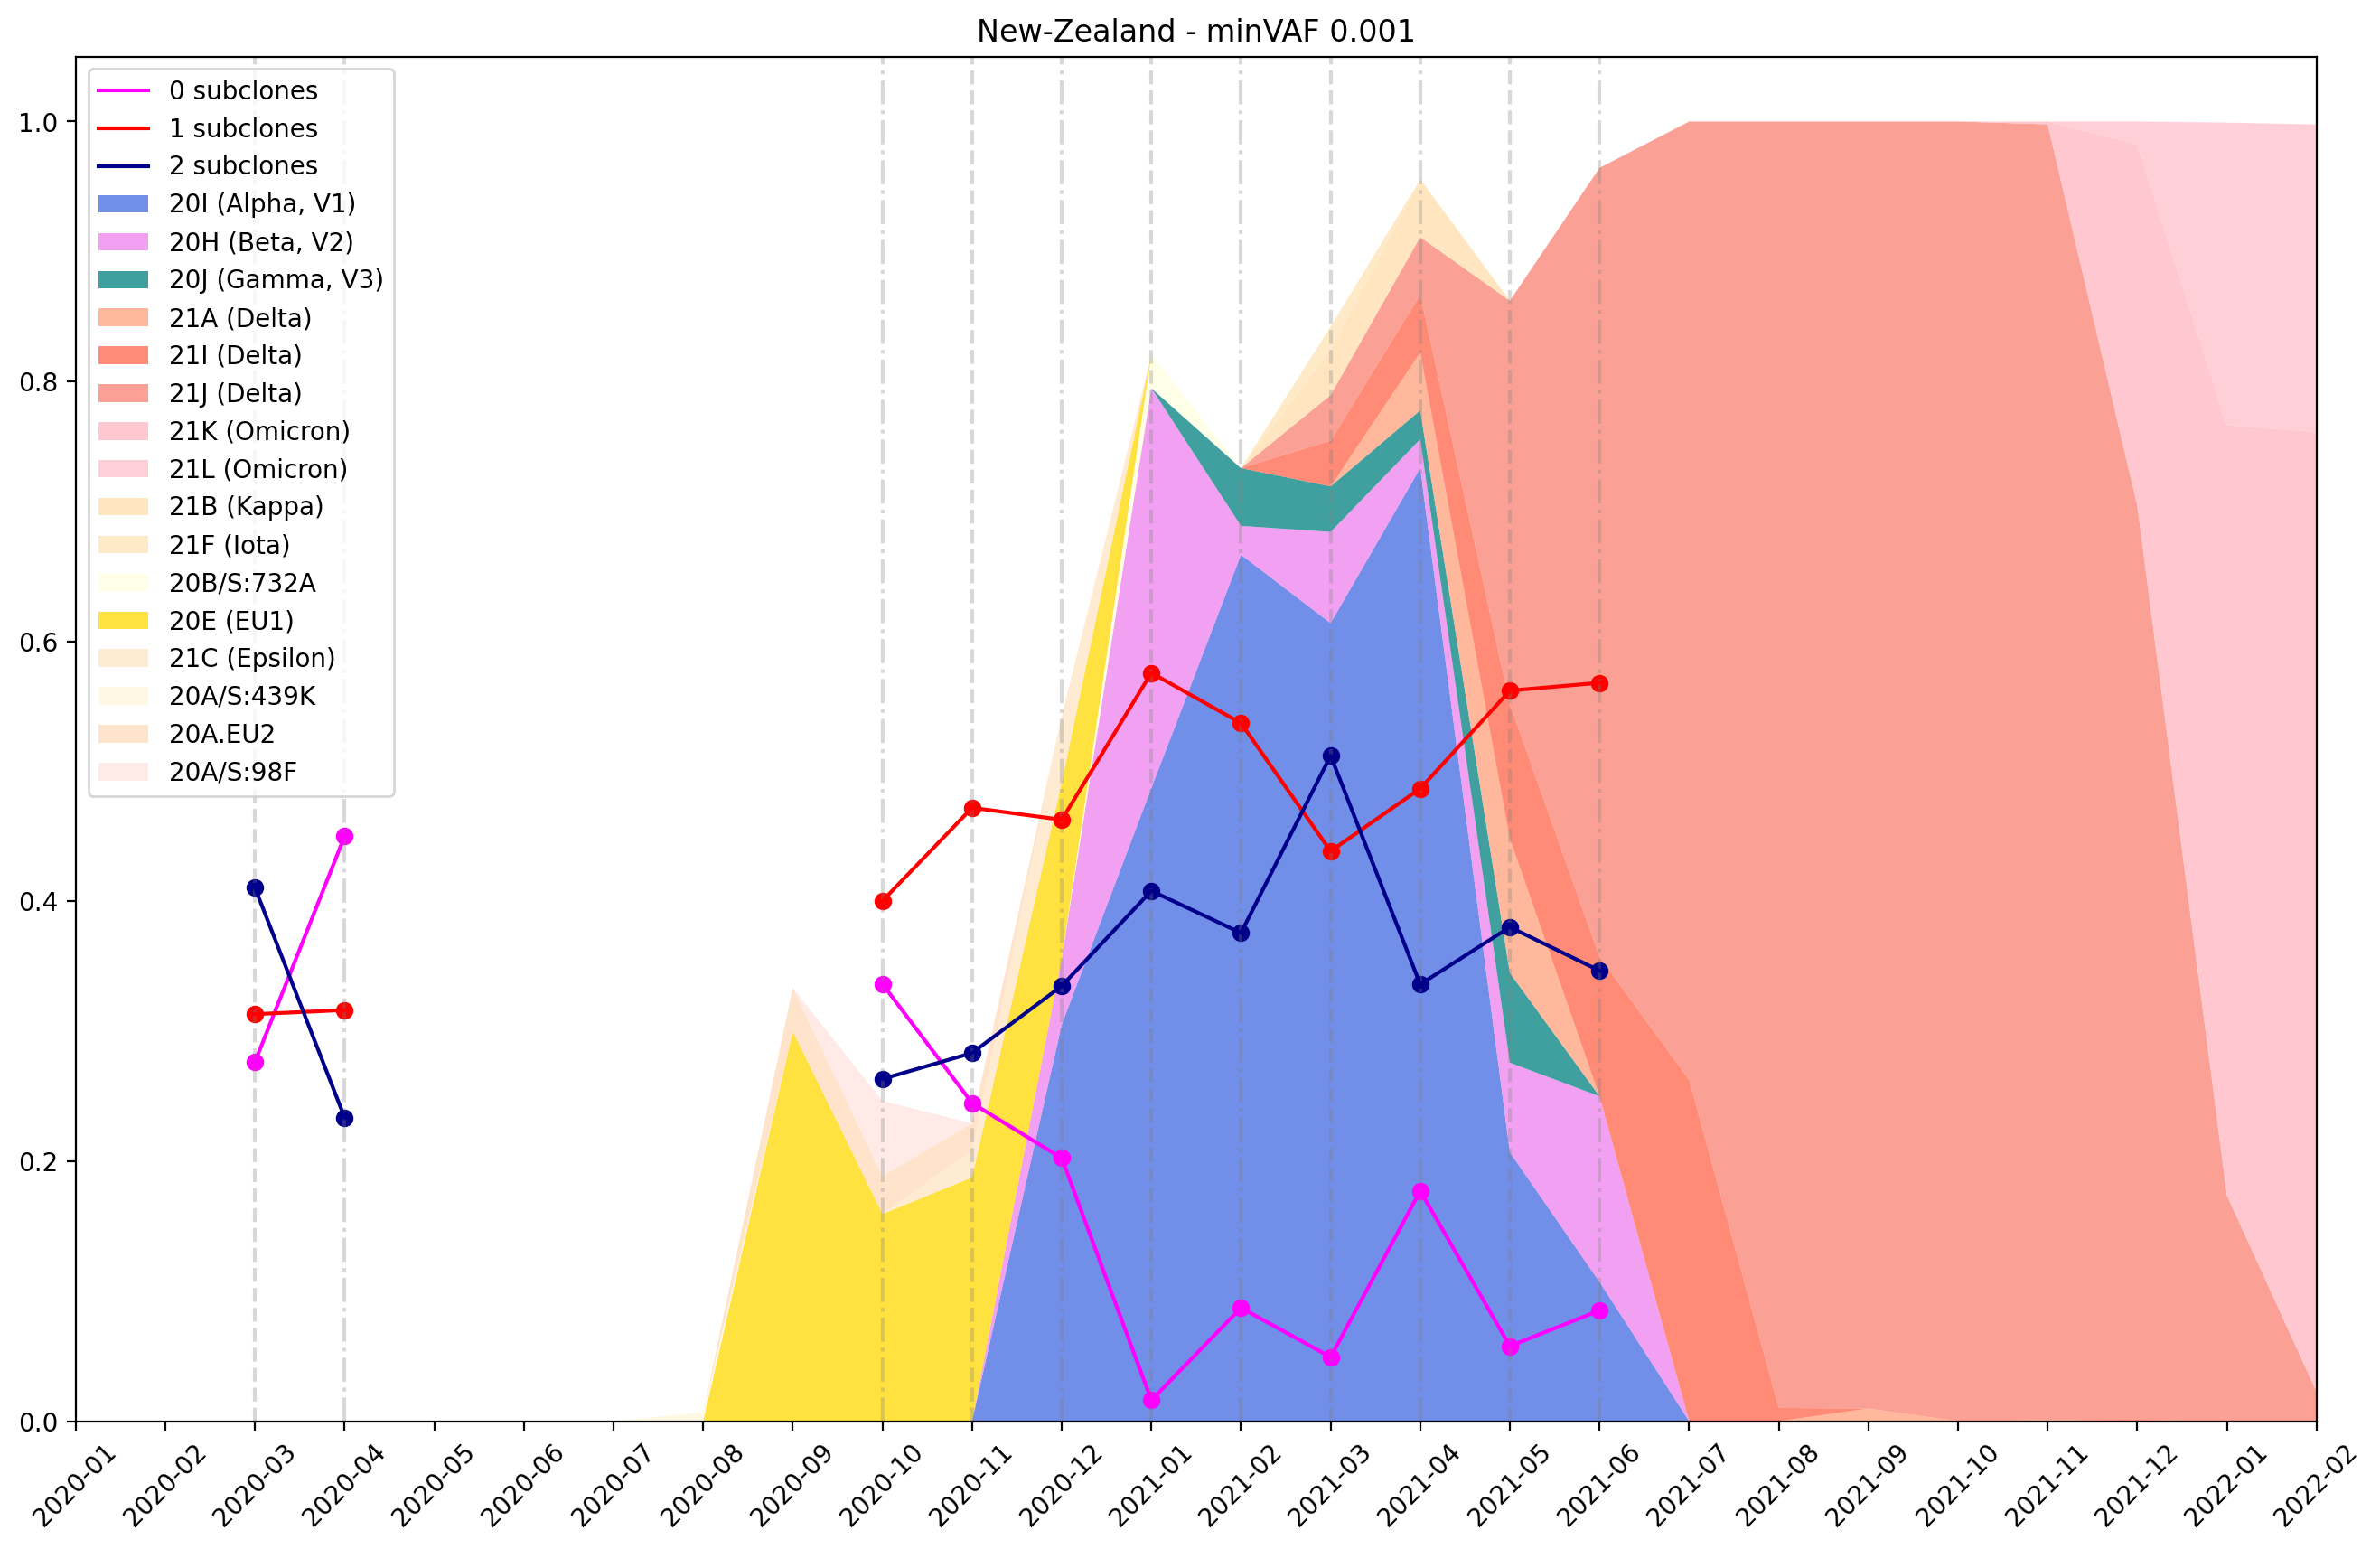

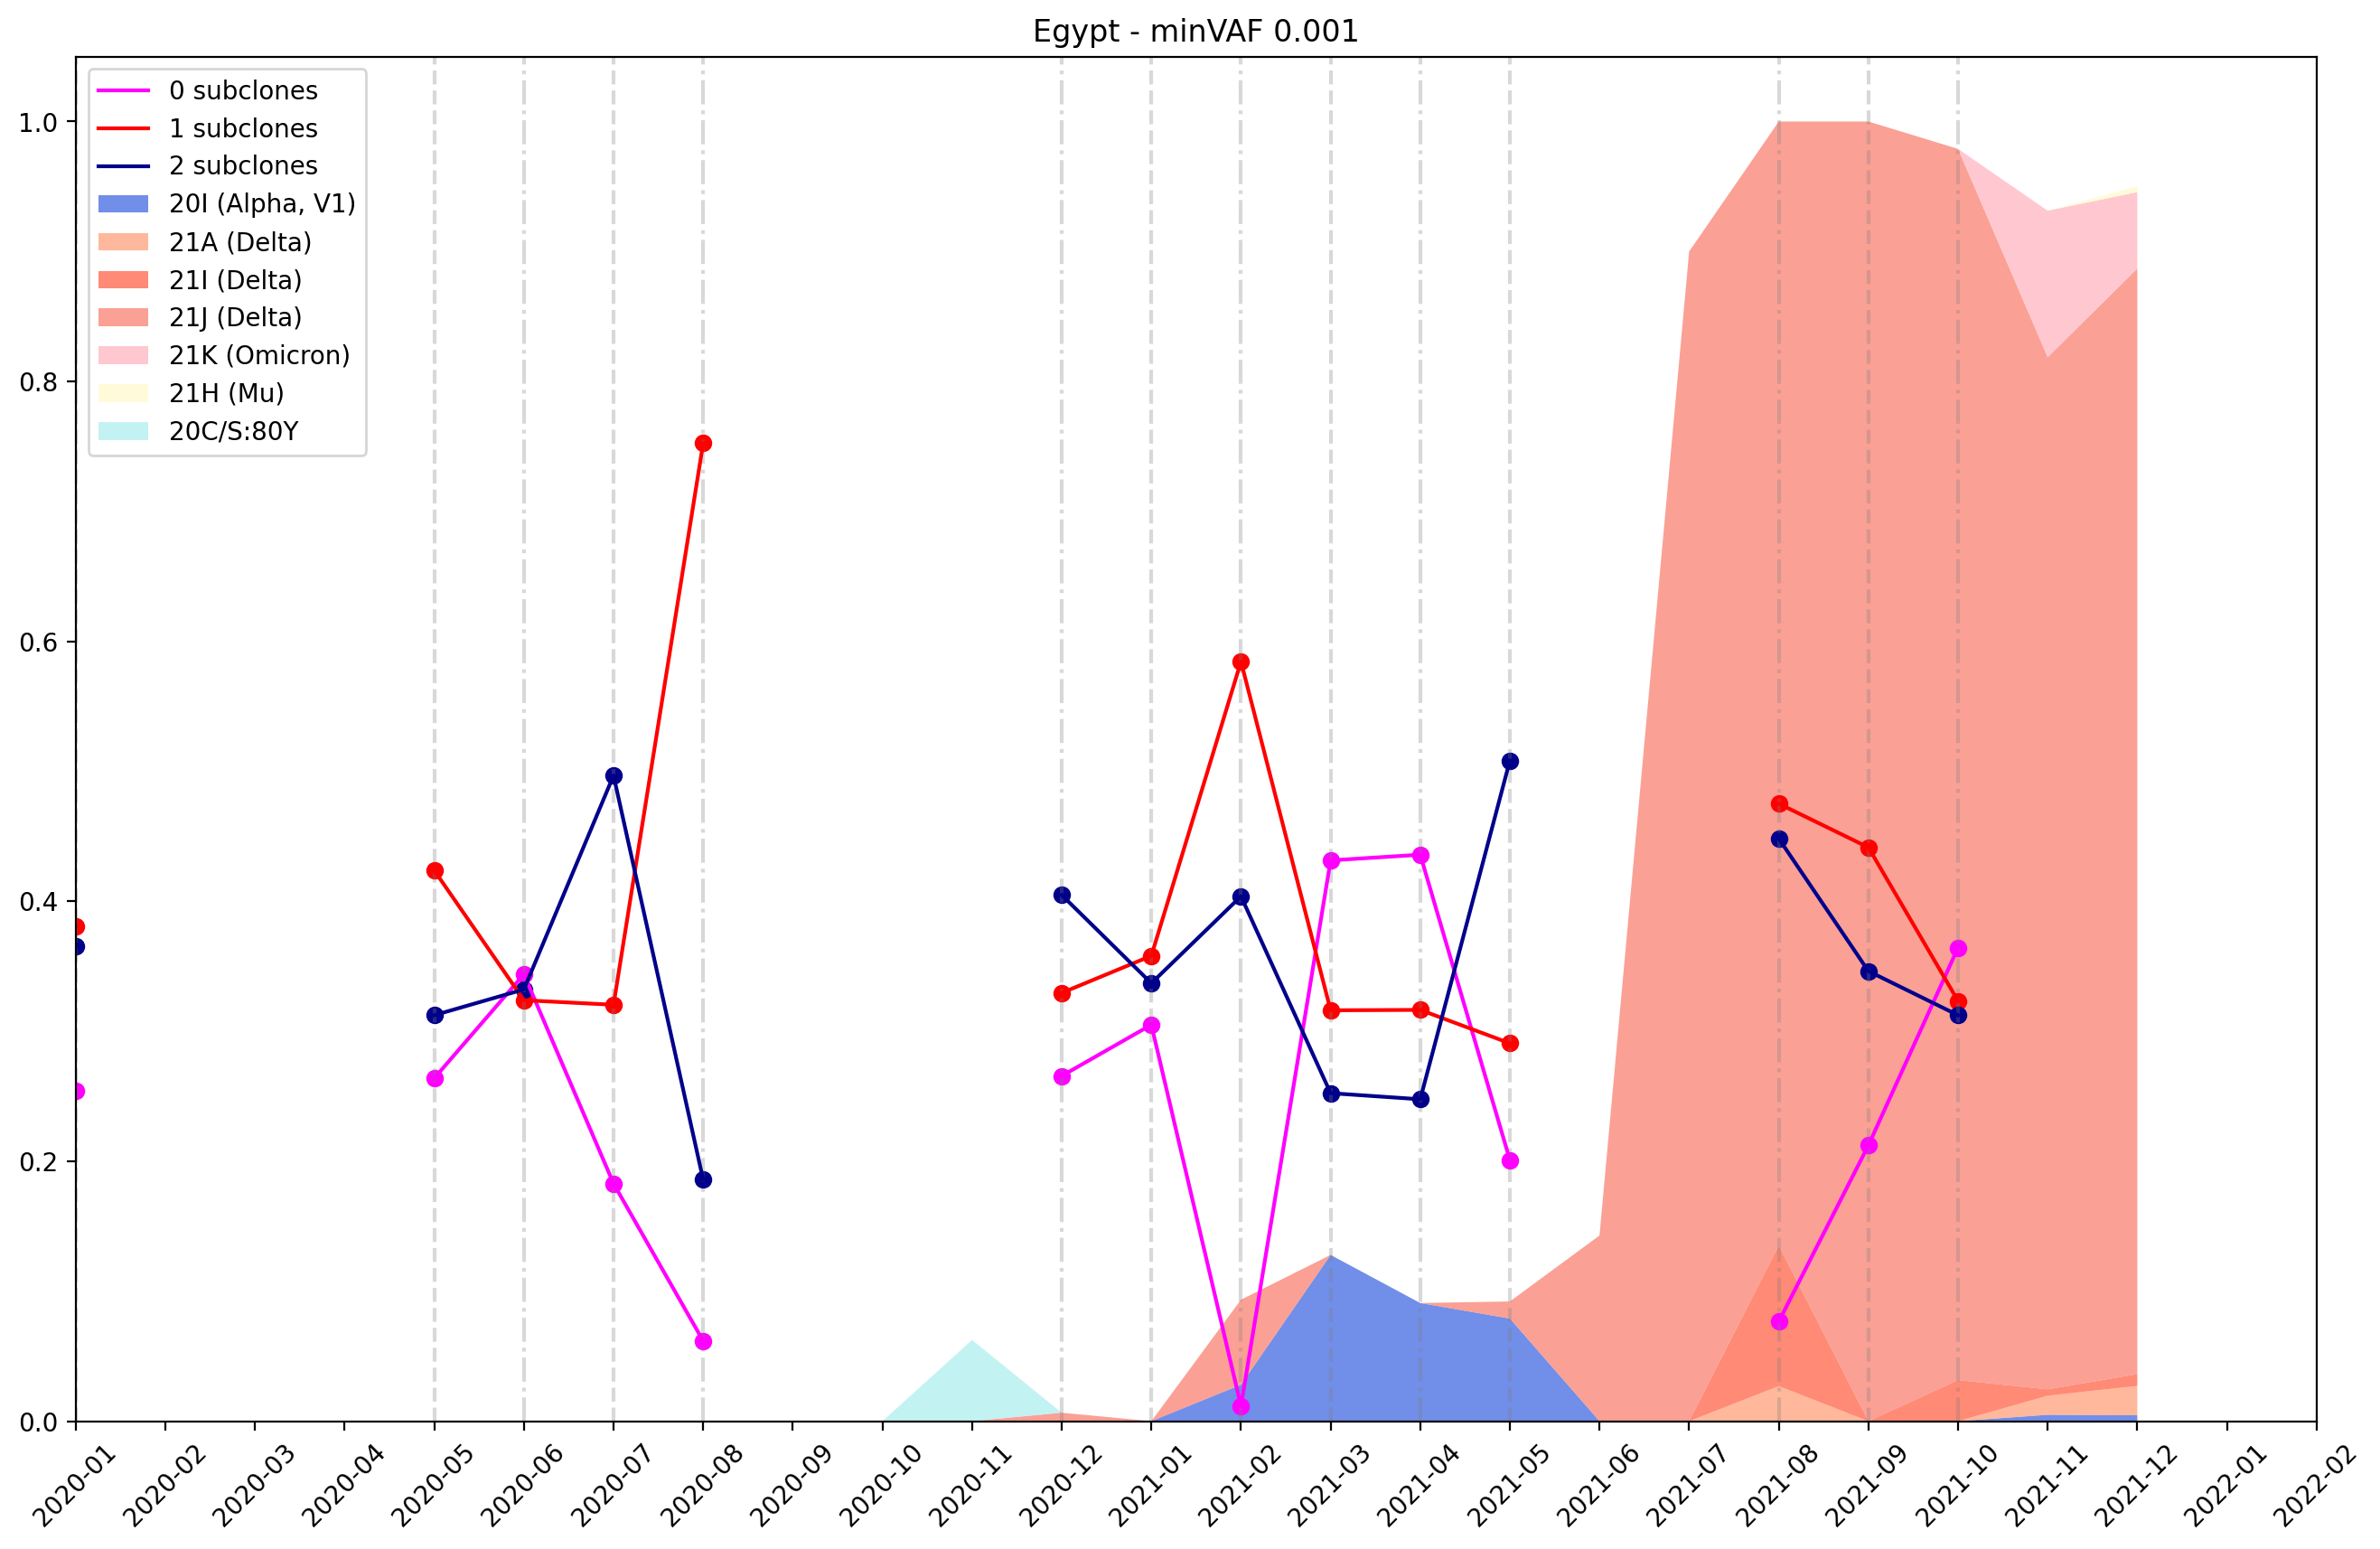

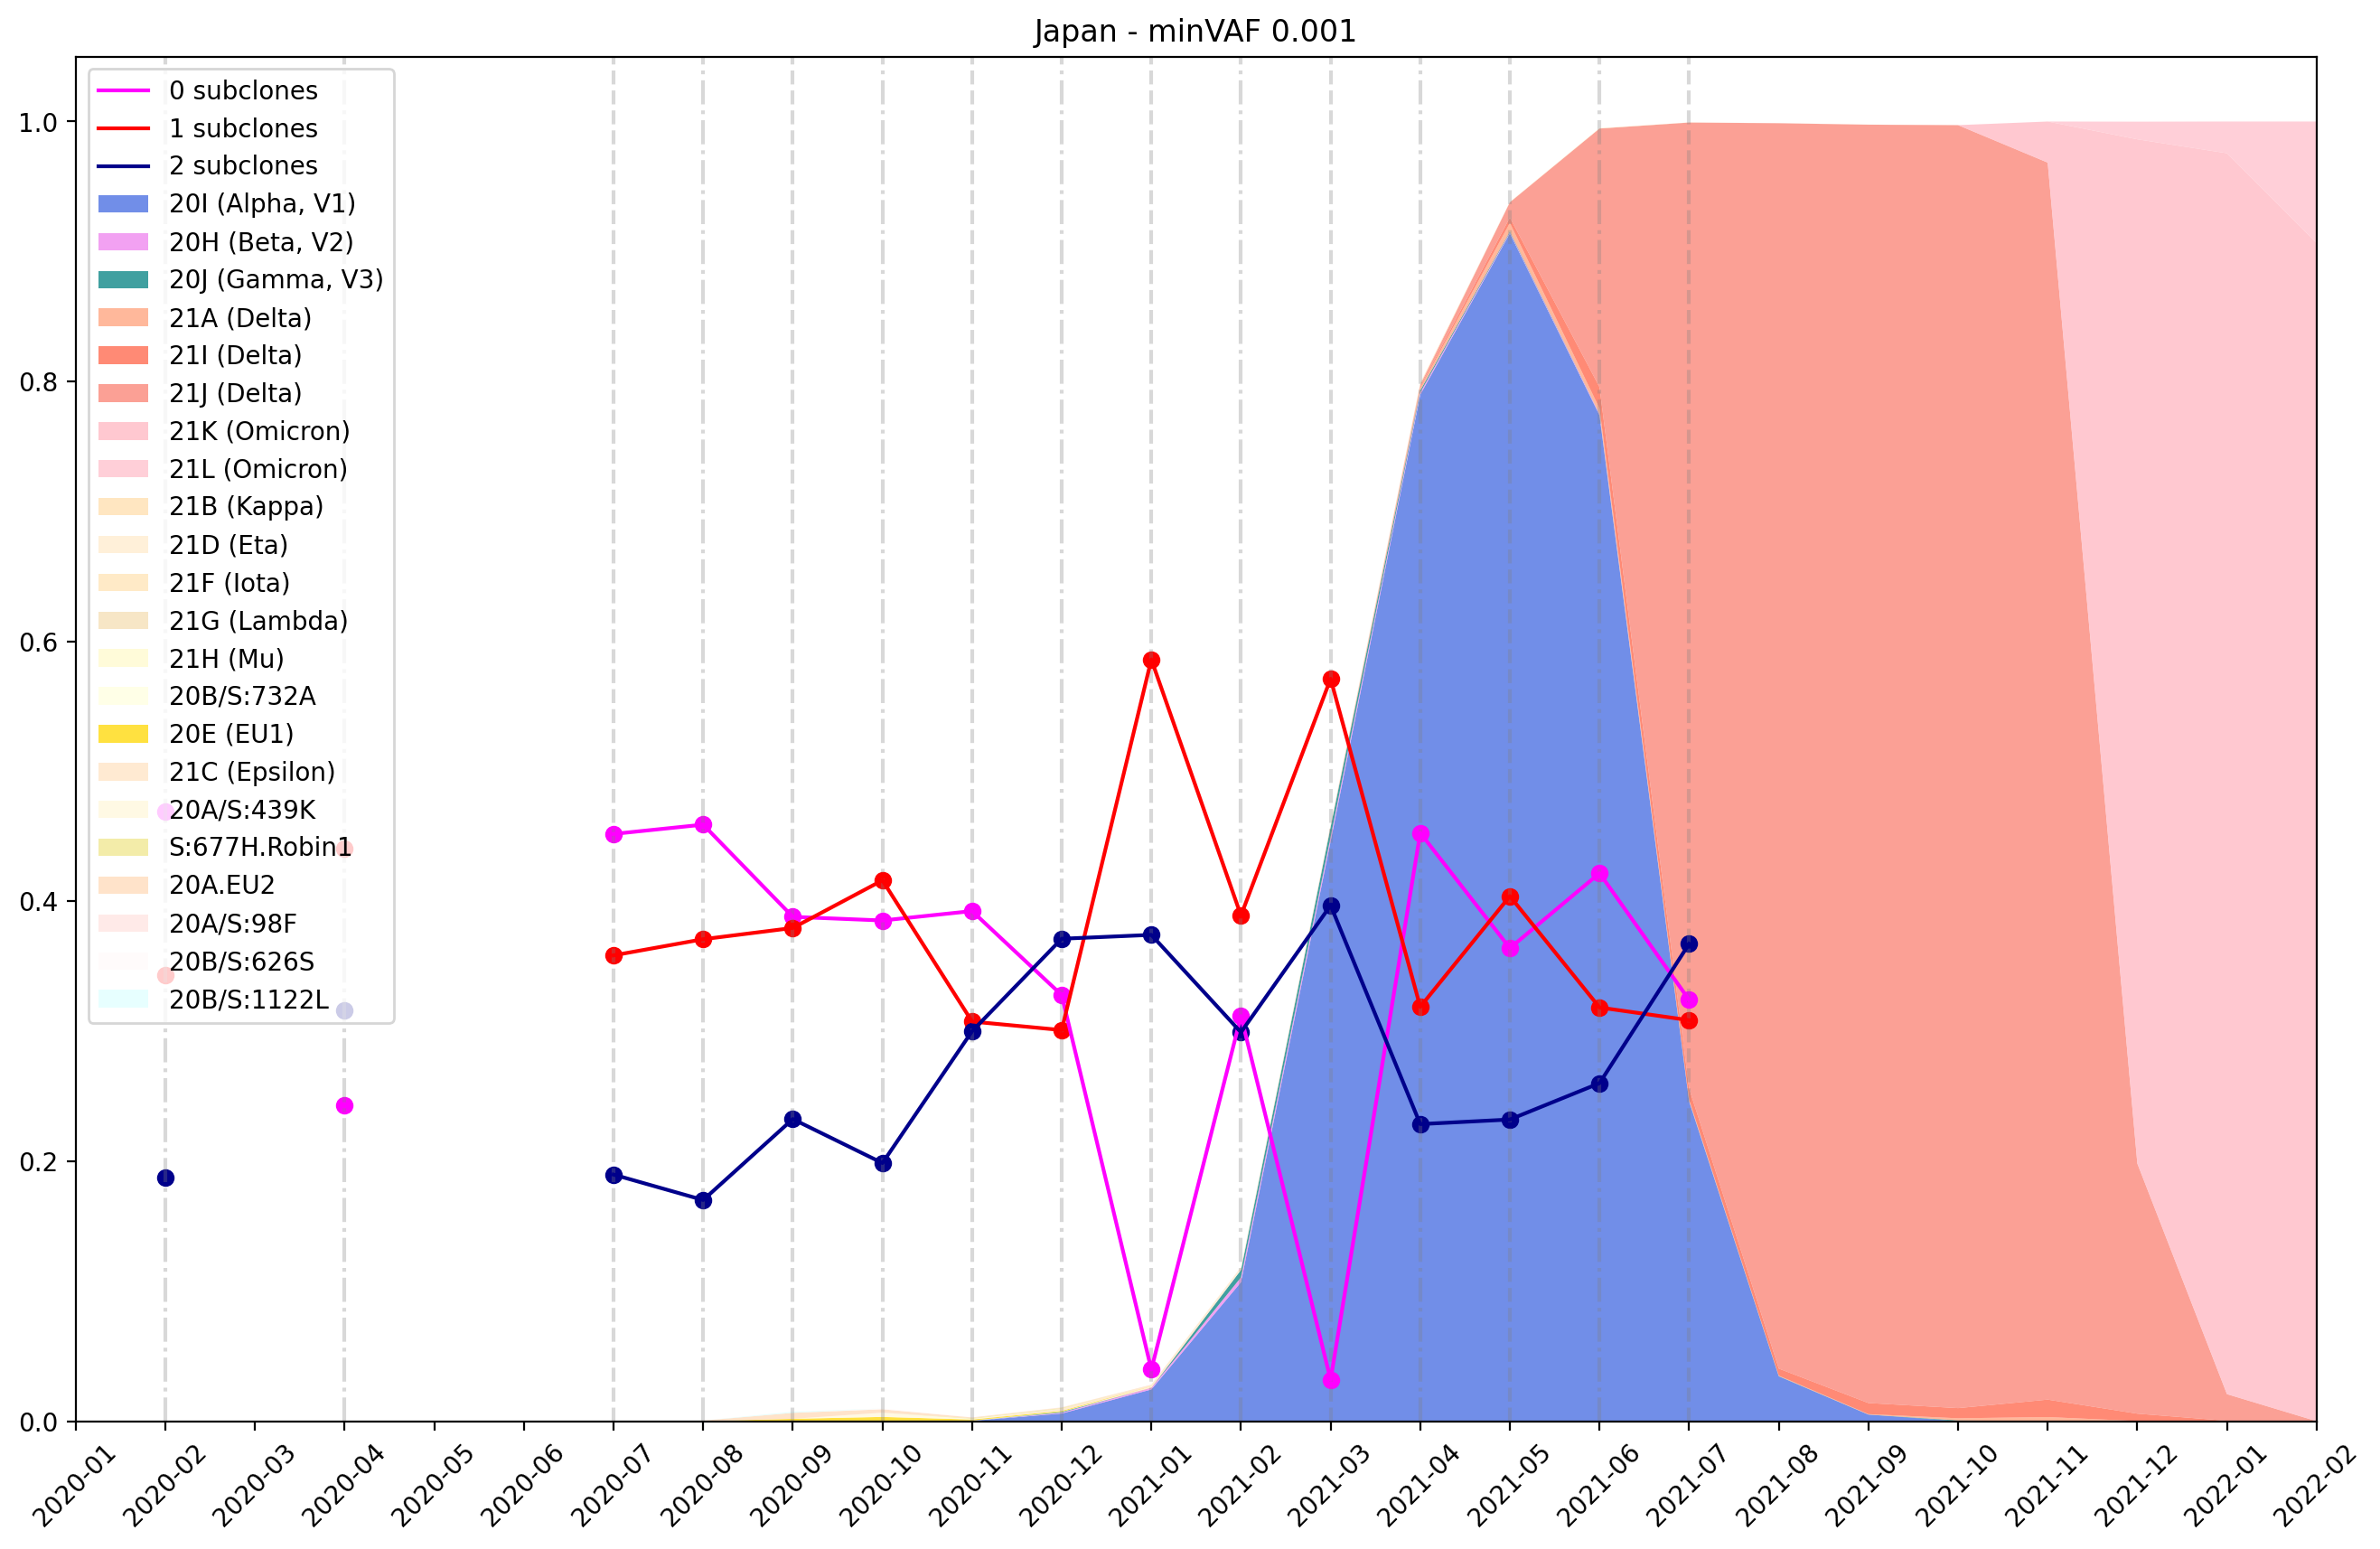

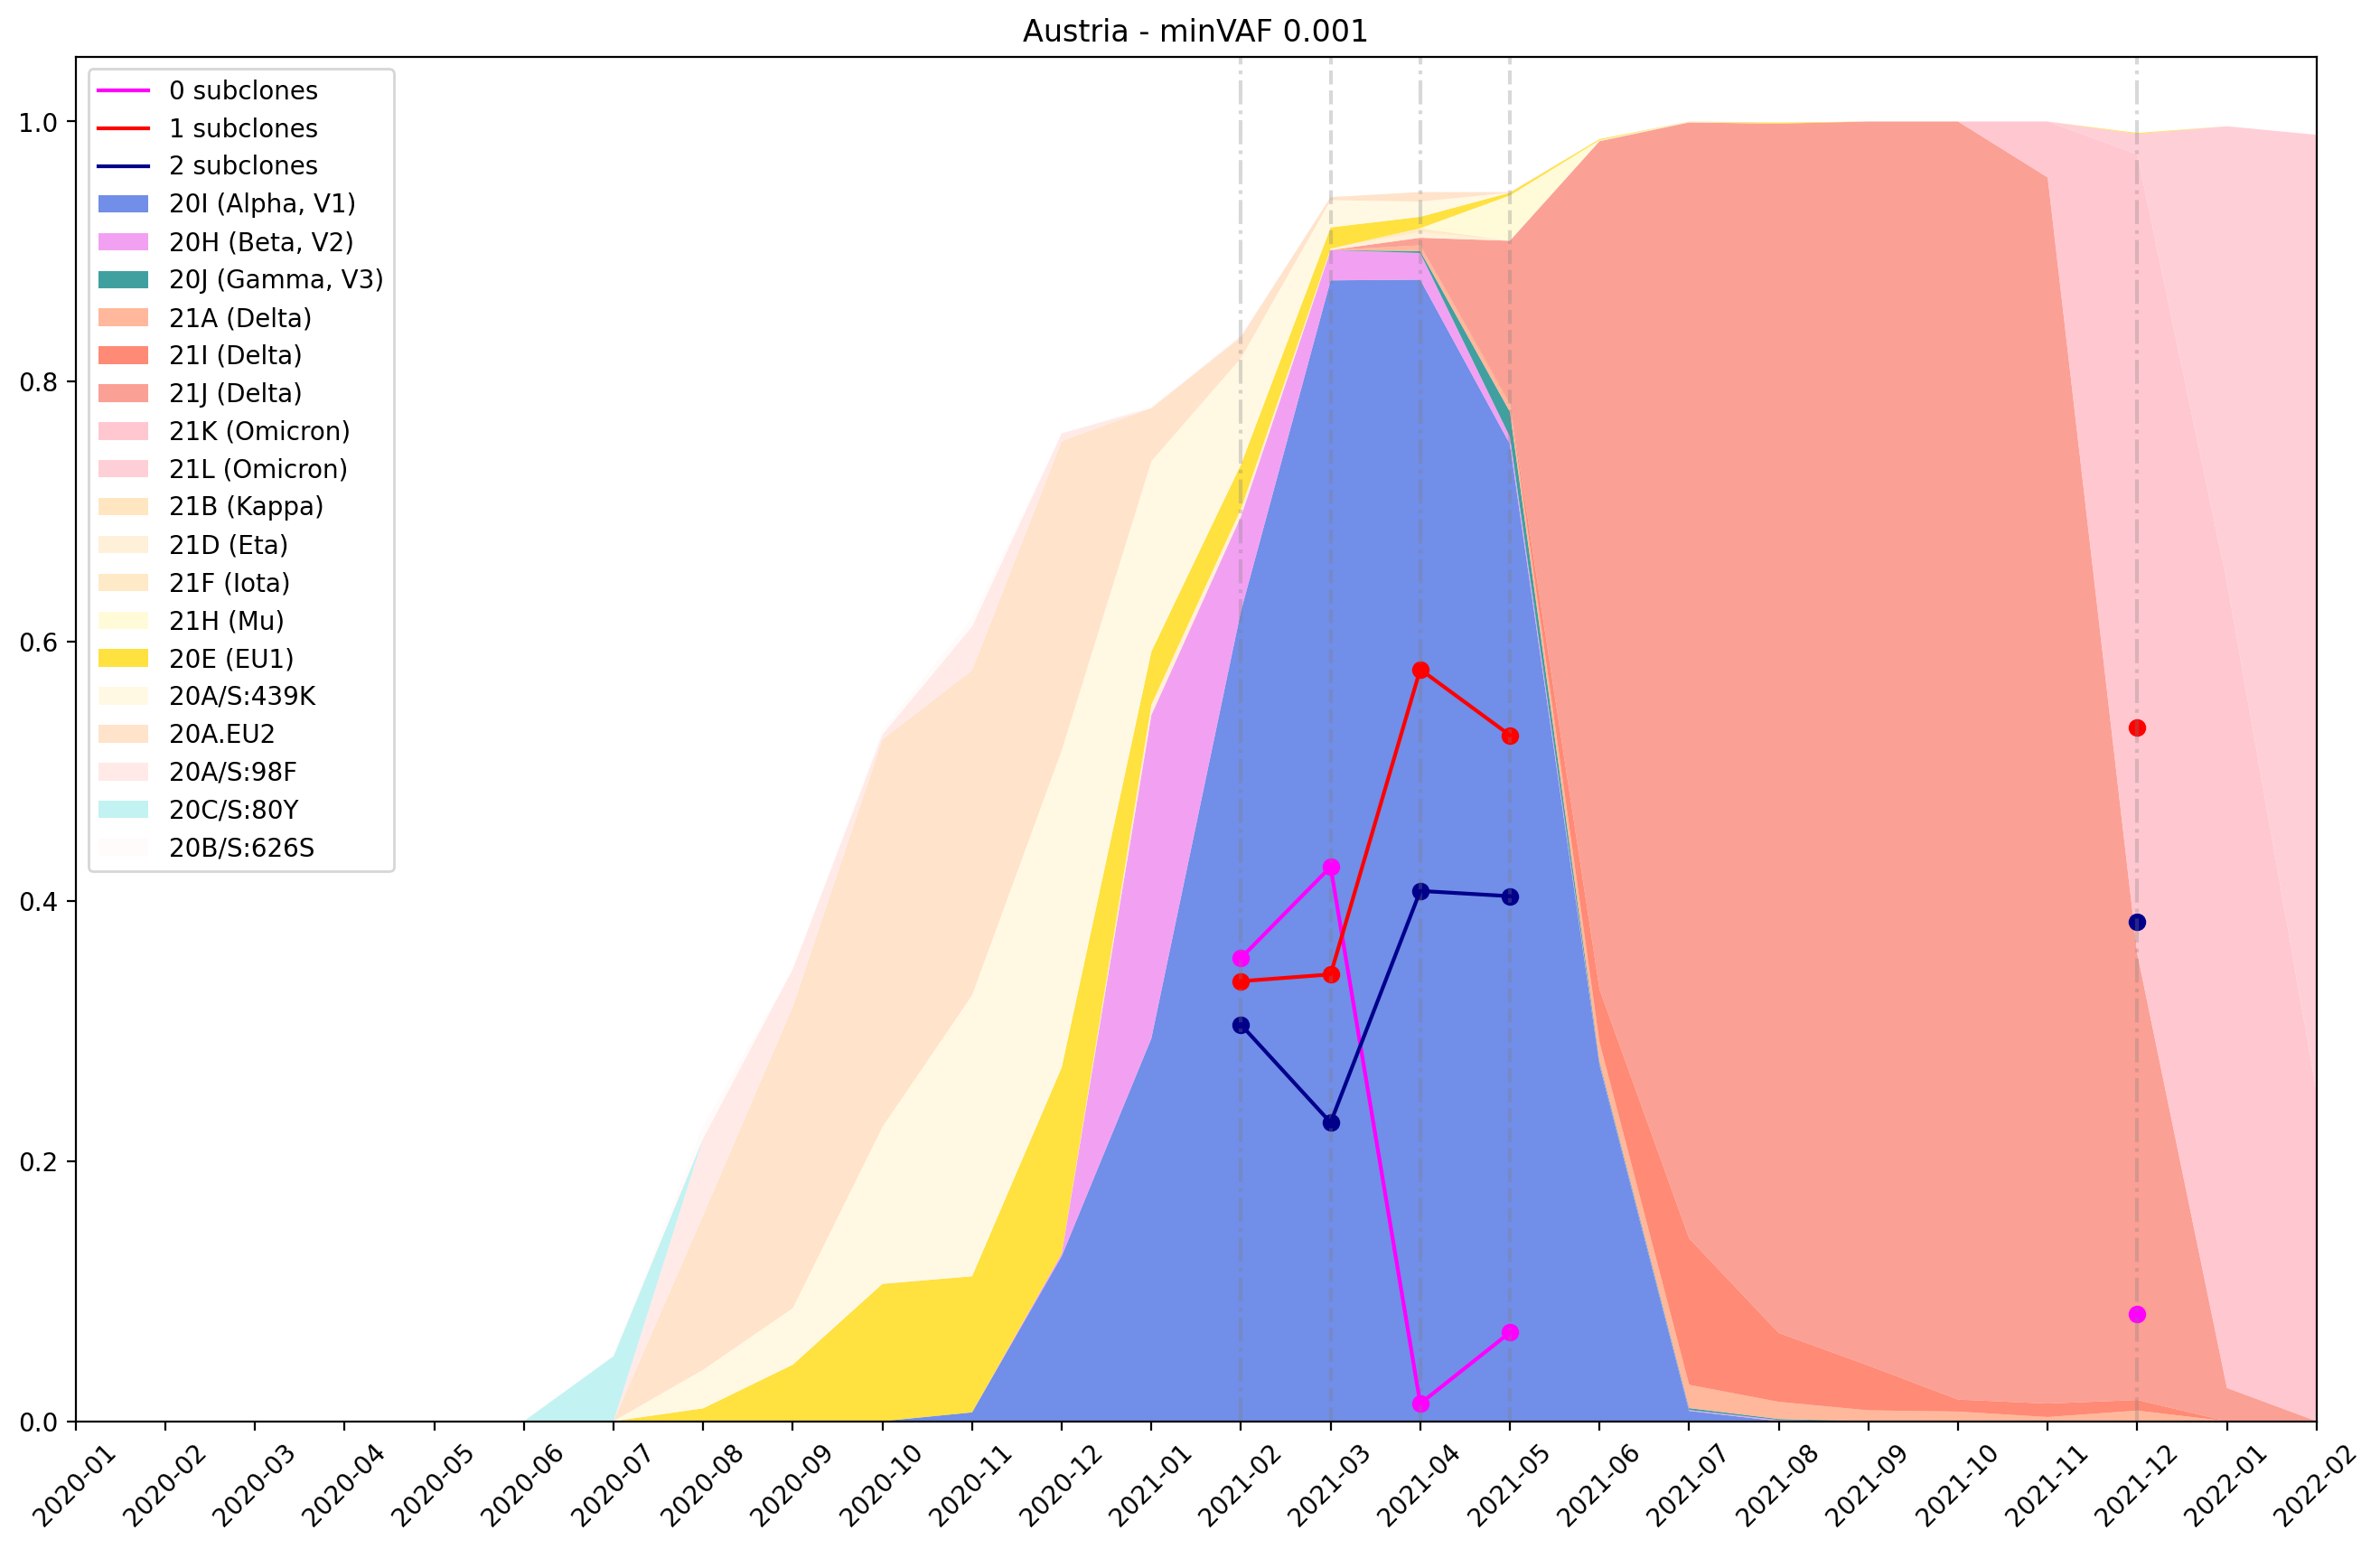

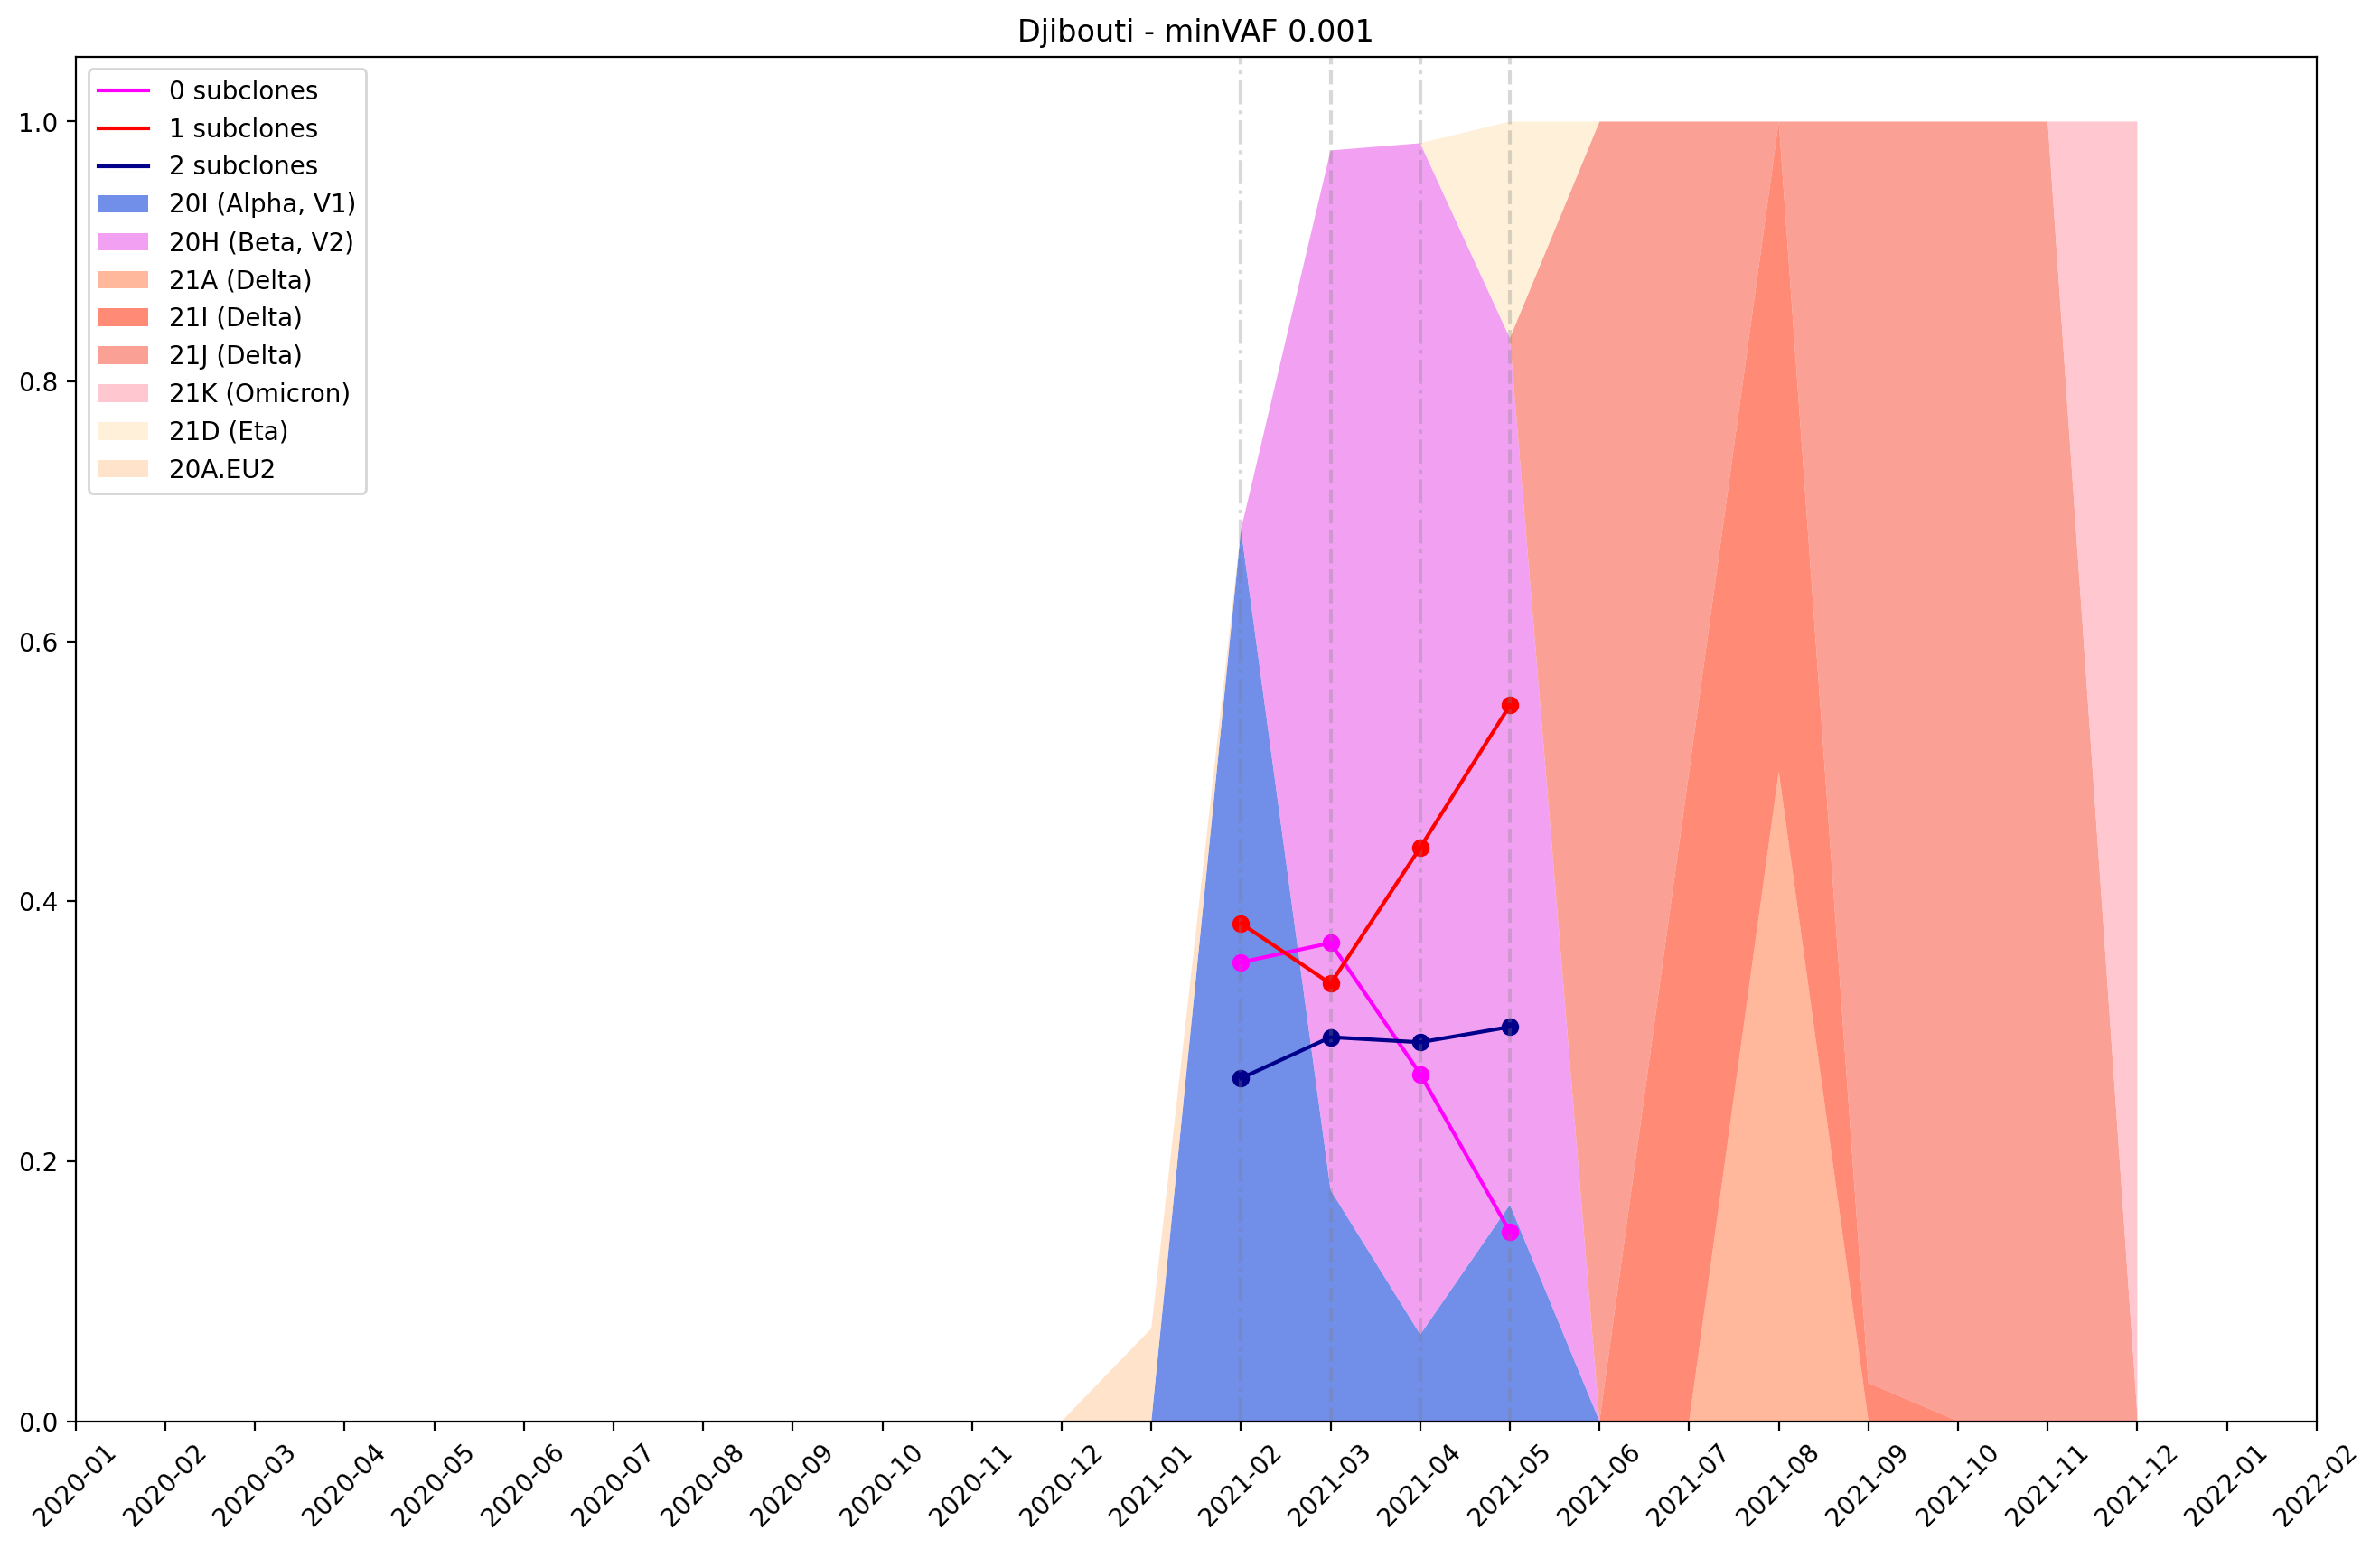

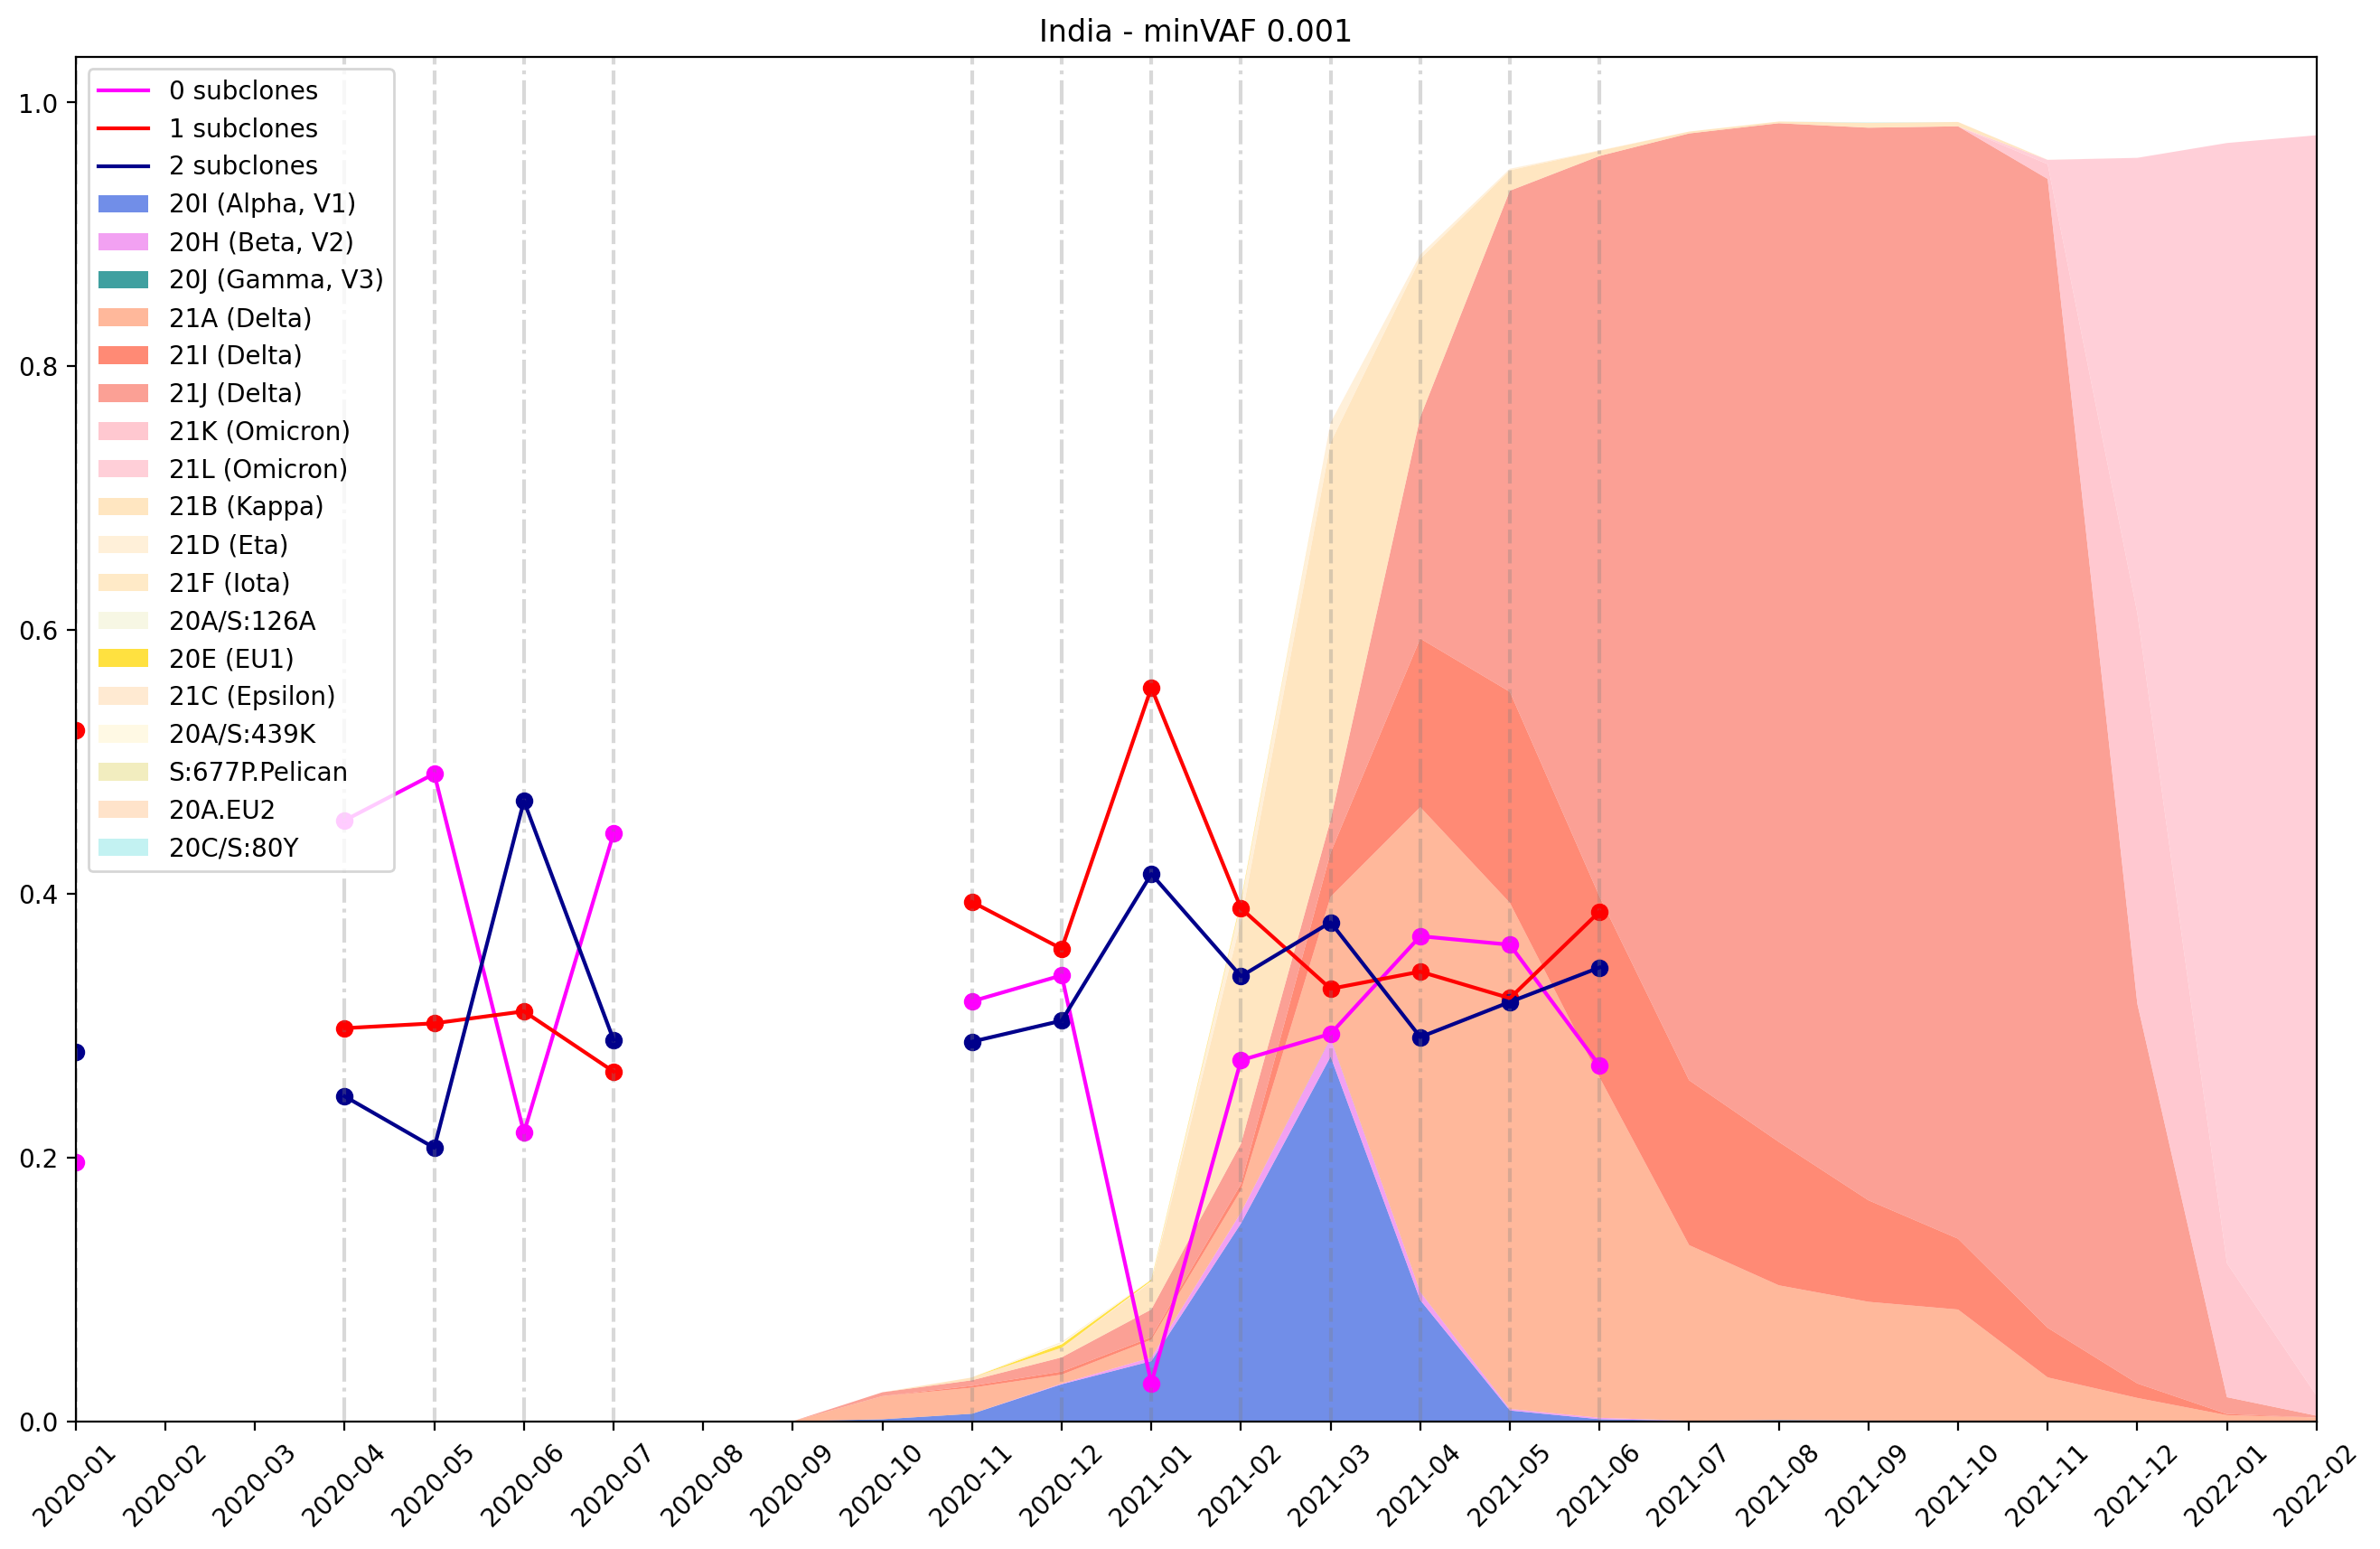

In [26]:
for country in useful_countries:
    #stack_and_line_plot(cases, data, country, 0.0001, gaps = True, vertical_lines=True)
    #stack_and_line_plot(cases, data, country, 0.001, gaps = True, vertical_lines=True)
    stack_and_line_plot(cases, data, country, 0.001, gaps = True, vertical_lines=True)

**TODO**:
- tweak parameters
- write down some interpretation
- compare subclone parameters with properties of actual virus variants
- run simulations with birth rate of R0 of dominant variant

In [27]:
all_figures.clear_figures()

---

In [34]:
def get_inferred_parameters(name, n_clones):
    params_template_path = base_path + r"\{0}\finalpopulation\posterior\{0}-parameters-clone{1}.csv"
    path = params_template_path.format(name, n_clones)
    param_table = pd.read_csv(path)
    x = {c:(param_table[c].mean(), param_table[c].median()) for c in param_table.columns}
    del x["weight"]
    del x["cellularity"]
    return x

In [29]:
print("EU1\n")
print("September 2020:")
pp(get_inferred_parameters("m_United-Kingdom_2020-9_9567_233-filtered0.01_Nmax2000", 1), sort_dicts=False)
print("\nOctober 2020:")
pp(get_inferred_parameters("m_United-Kingdom_2020-10_16288_200-filtered0.01_Nmax2000", 1), sort_dicts=False)

EU1

September 2020:
{'mu': (2.1508747573112172,
        2.129758418770289,
        1.5100844477393602,
        2.8675700366970074),
 'clonalmutations': (122.1562421578337,
                     123.60933733192437,
                     11.276825762398557,
                     225.06953868763708),
 's': (0.278559955442066,
       0.2372208604168916,
       -0.02064198020796925,
       0.7894535583377544),
 't': (3.3053542990475733,
       3.123834470588296,
       0.14042159722416228,
       7.041413169410973),
 'cellularity': (1.0499062832103996,
                 1.0503771738608876,
                 1.0022680593918027,
                 1.094211004428445),
 'frequency': (0.5520711610486893, 0.443, 0.261025, 0.9353499999999999),
 'scmuts': (12.044943820224718, 12.0, 3.0, 23.0),
 'weight': (0.00191197719303884,
            0.0017952026685091,
            0.00102449933792211,
            0.0037198014232182434)}

October 2020:
{'mu': (1.3990341298606082,
        1.3943210310006506,
        0

---

In [30]:
def stack_and_line_plot_specialized(cases, data, country, filtering, birth_rate_mapping, gaps = False, vertical_lines = False):
    country_freqs = get_freqs(cases, country)
    country_data = data[country]
    labels_cp = labels.copy()
    fig, ax = plt.subplots(figsize=(16,10), dpi=200)
    all_figures.add(fig)
    x, y, birth_rates = list(zip(*sorted(
        [
            (label_positions[date],
             values[filtering] if birth_rate_mapping.get(date, -1) not in values.keys() else values[birth_rate_mapping[date]][filtering],
             3 if birth_rate_mapping.get(date, -1) not in values.keys() else birth_rate_mapping[date]
            ) for date, values in country_data.items() if filtering in values
        ], key=lambda x:x[0])))
    y = np.array(y)
    colors = ["fuchsia", "r", "darkblue"]
    mutations = [f"{i} subclones" for i in range(3)]
    
    if vertical_lines:
        for k,i in enumerate(x):
            ax.axvline(i, color="gray", linestyle=["--", "-."][i%2], alpha=0.3)
            labels_cp[i] += f" ln({birth_rates[k]})"
    
    variant_names = list(country_freqs[list(country_freqs.keys())[0]].keys())
    fractions = np.array(list(
        map(lambda x:np.array(list(x[1].values())), sorted(country_freqs.items(), key = lambda x:x[0]))
    ))
    ax.stackplot(sorted(map(lambda f:label_positions[f], country_freqs.keys())), fractions.T,
                 labels=variant_names, colors=[variant_color_mapping[n] for n in variant_names if n in variant_color_mapping],
                 alpha=0.75)
    
    if gaps:
        y_new = np.full([len(labels), y.shape[1]], np.nan)
        for i, index in enumerate(x):
            y_new[index] = y[i]
        [ax.plot(y_new[:,i], color=colors[i], label=mutations[i]) for i in range(3)]
        [ax.scatter(np.arange(len(labels)),y_new[:,i], color=colors[i], alpha=1) for i in range(3)]
    else:
        [ax.plot(x, y[:,i], color=colors[i], label=mutations[i]) for i in range(3)]
        [ax.scatter(x, y[:,i], color=colors[i], alpha=1) for i in range(3)]
        
    ax.set_xticks(np.arange(len(labels_cp)))
    ax.set_xticklabels(labels_cp, rotation=45)
    ax.set_xlim(0,len(labels_cp)-1)
    ax.set_title(f"{country} - minVAF {filtering}")
    ax.legend(loc="upper left")

In [31]:
birth_rates = [4.5, 7.0]
data = get_all_probs(filtering = [0.01, 0.001, 0.0001], data = data, n_max = Nmax, birth_rates = birth_rates)

In [32]:
dates = [
    # alpha
    '2021-01',
    '2021-02',
    '2021-03',
    '2021-04',
    # delta
    '2021-05',
    '2021-06',
    '2021-07',
    '2021-09',
    '2021-10',
    '2021-11'
]
birth_rates = [
    # alpha
    4.5,
    4.5,
    4.5,
    4.5,
    # delta
    7.0,
    7.0,
    7.0,
    7.0,
    7.0,
    7.0
]
date_br_mapping = {d:b for d,b in zip(dates, birth_rates)}

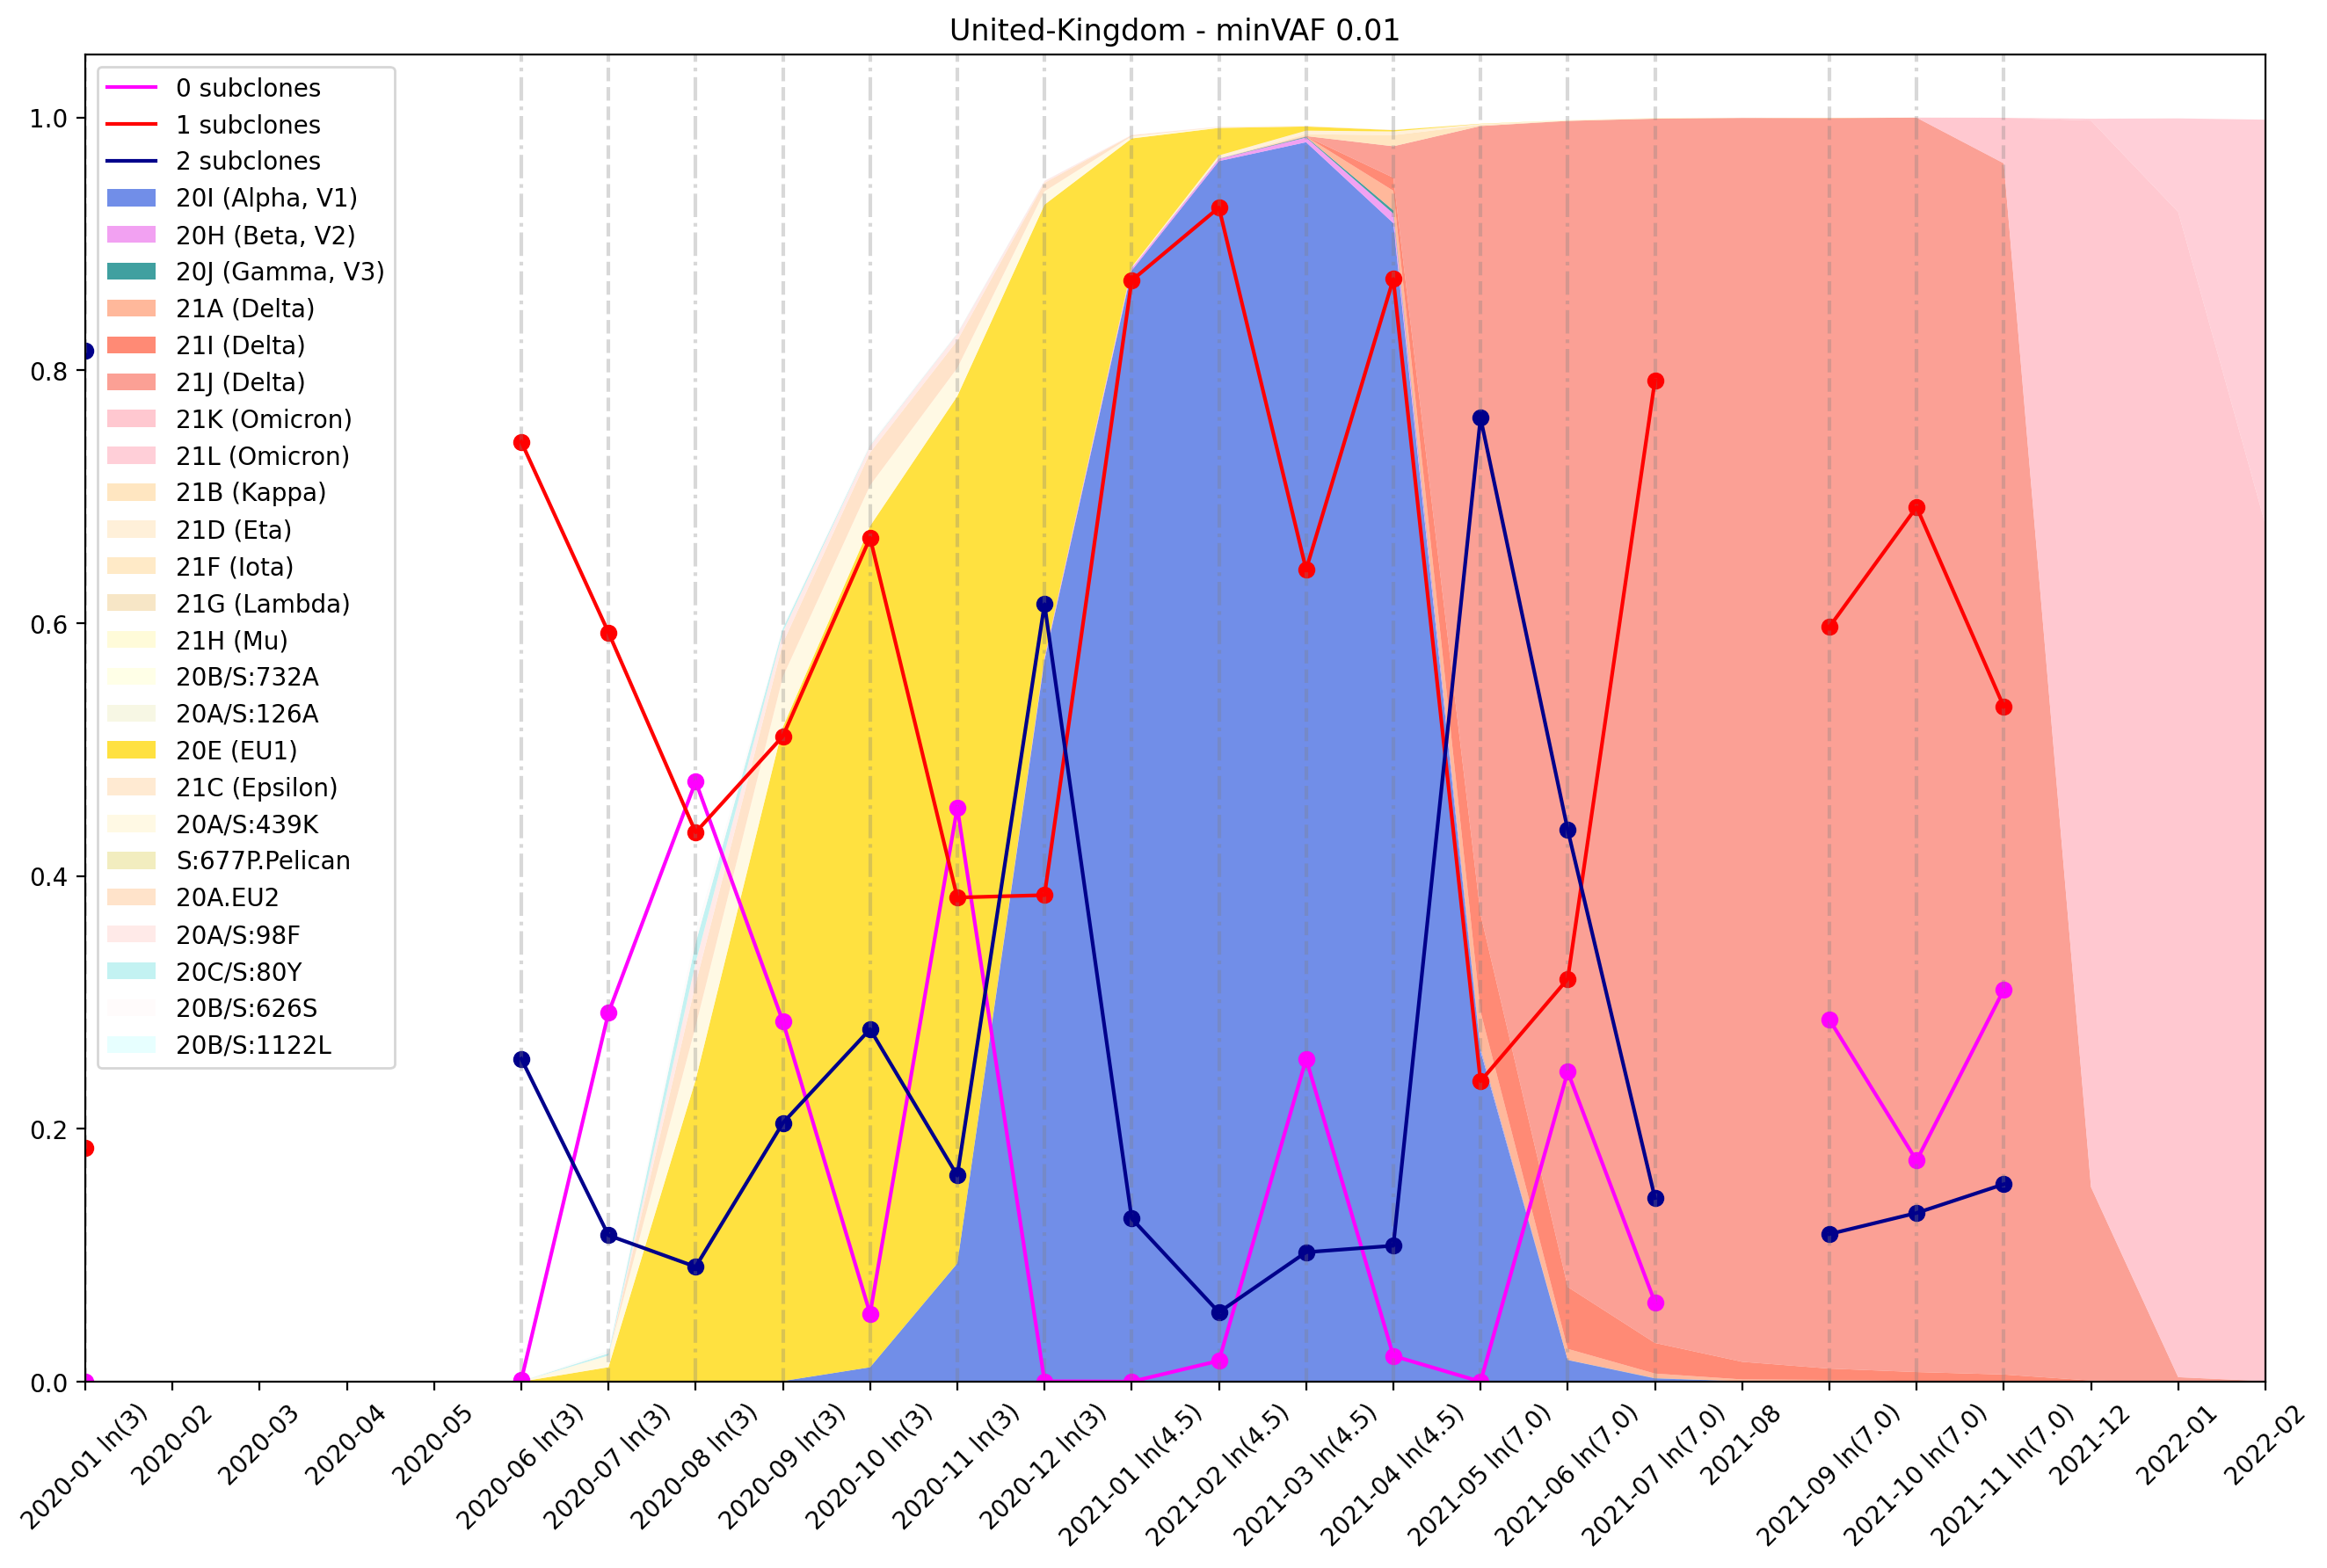

In [33]:
stack_and_line_plot_specialized(cases, data, "United-Kingdom", 0.01, date_br_mapping, vertical_lines=True, gaps=True)

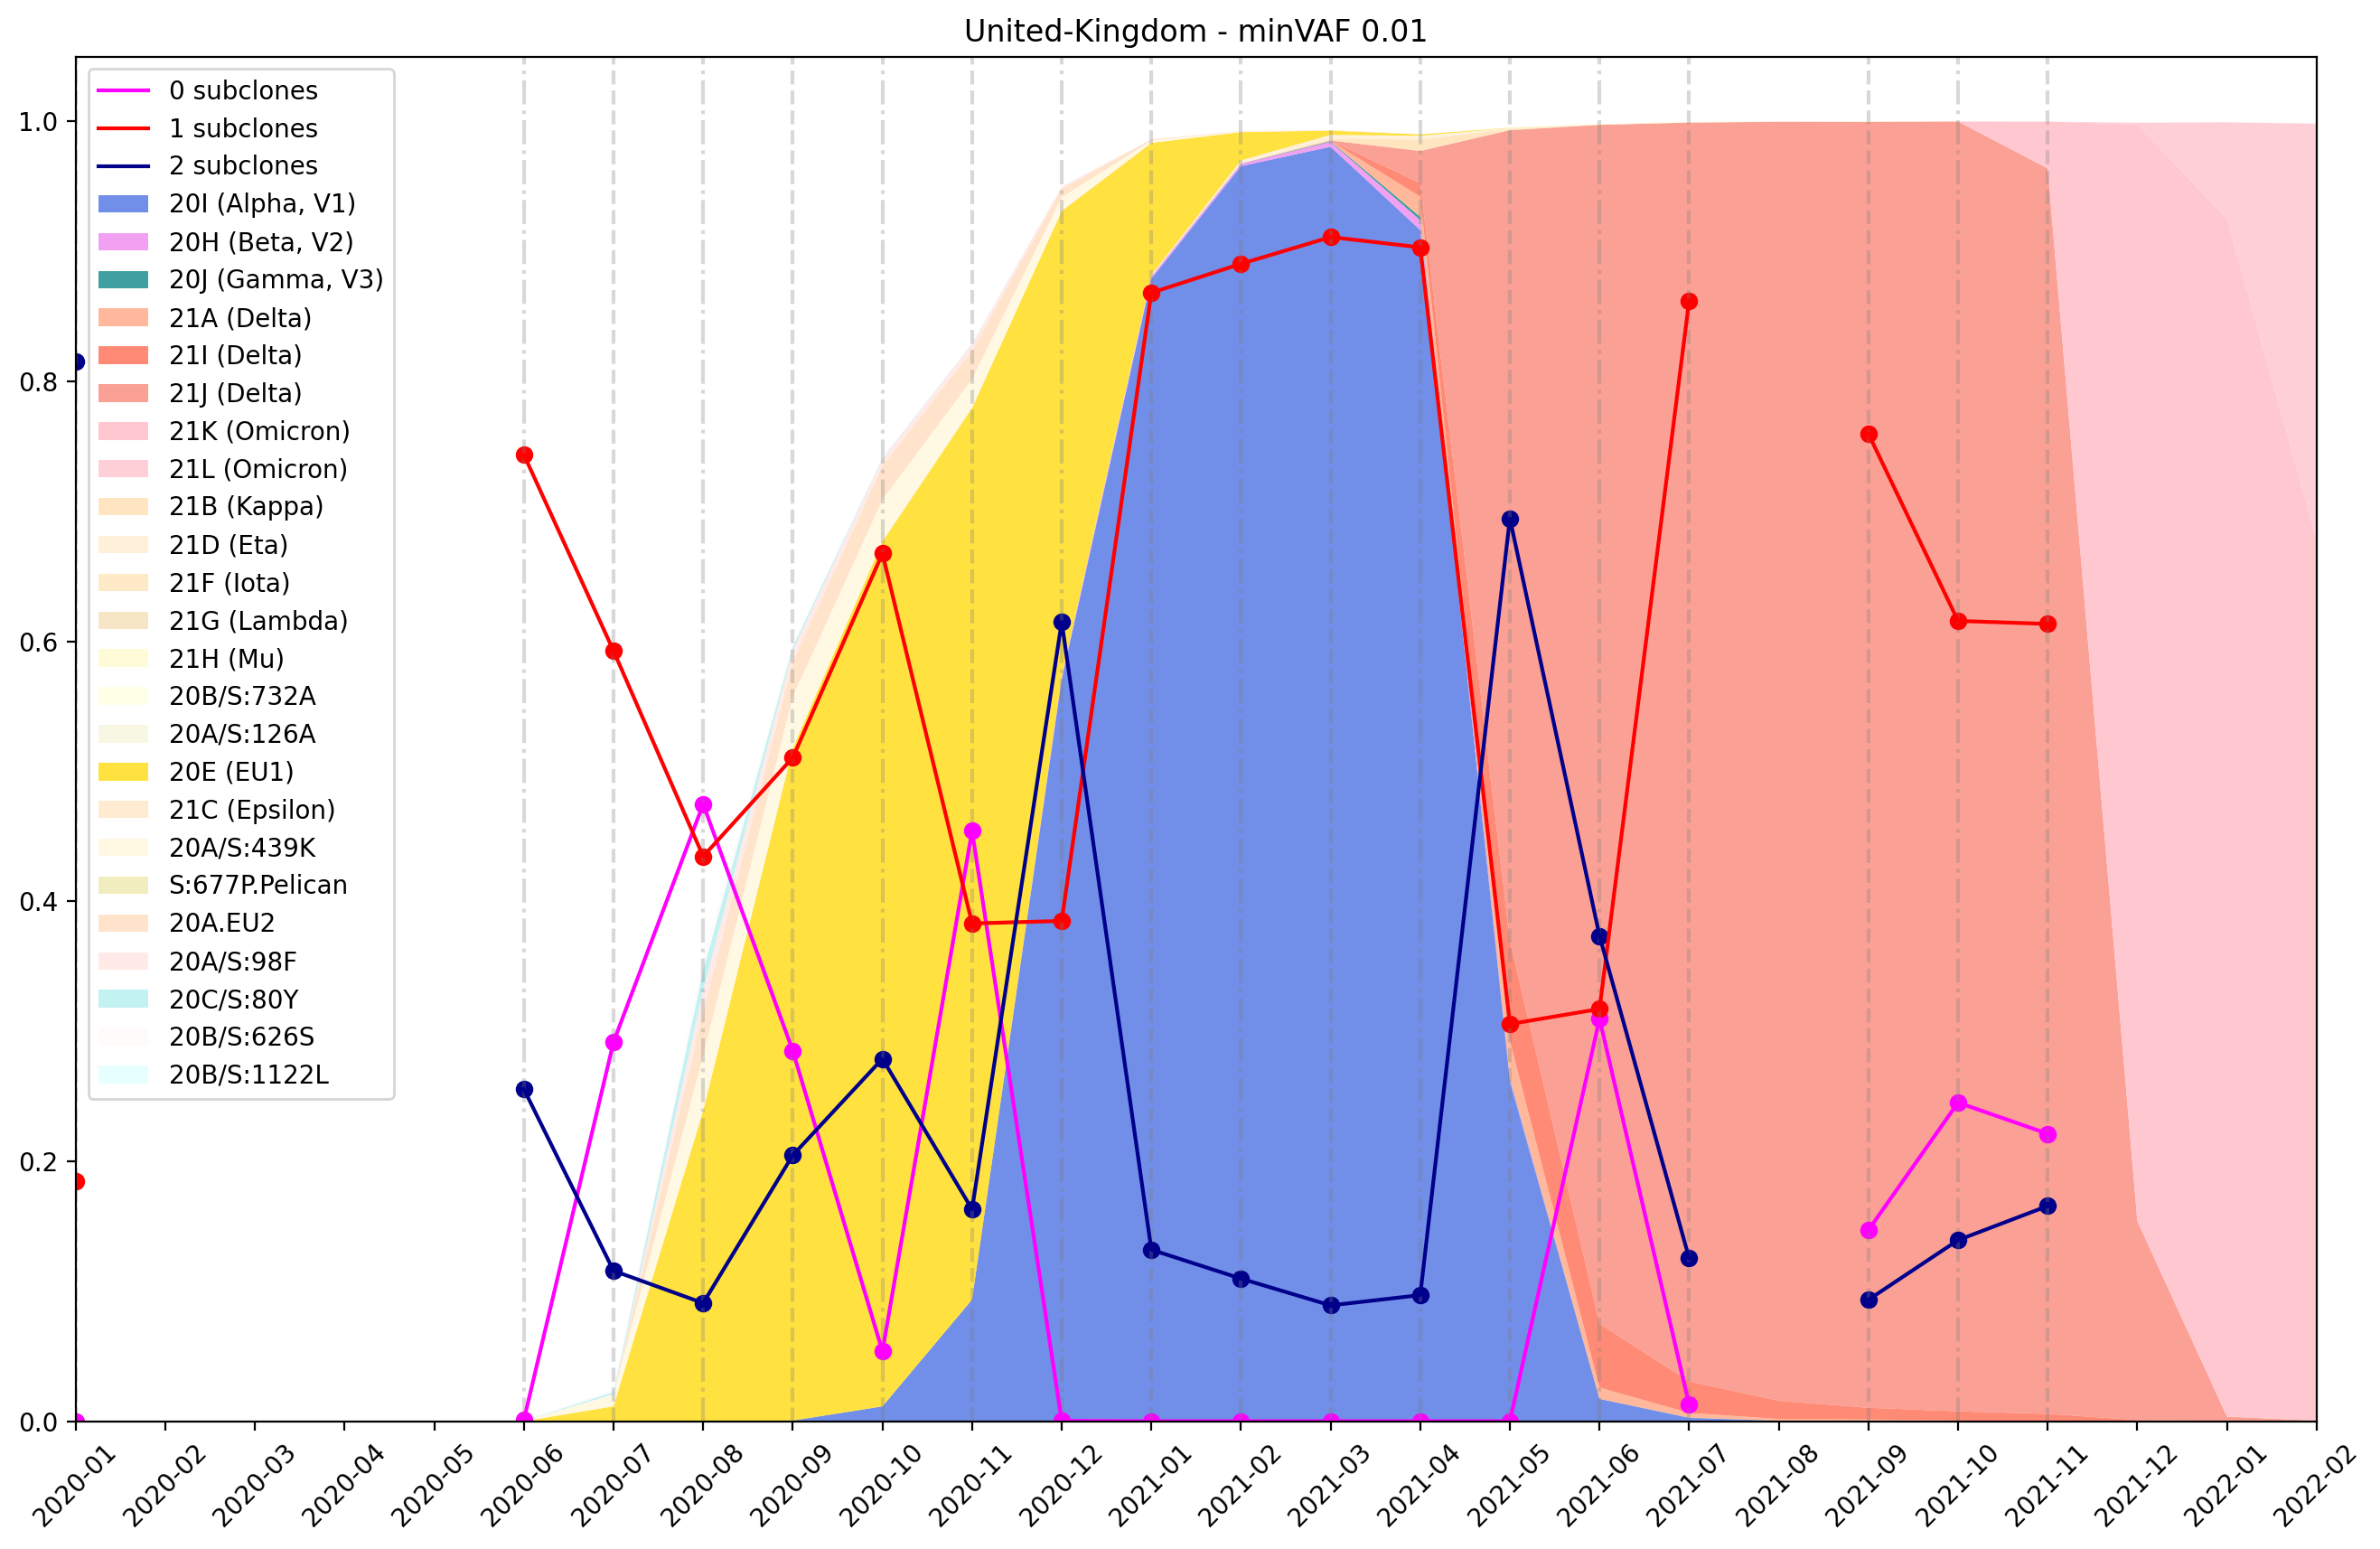

In [34]:
stack_and_line_plot(cases, data, "United-Kingdom", 0.01, vertical_lines=True, gaps=True)

In [35]:
pp(get_inferred_parameters("m_United-Kingdom_2020-6_4774_115-filtered0.01_Nmax2000", 1), sort_dicts=False)

{'mu': (1.4312021961533348,
        1.44550860928992,
        1.0644259895346888,
        1.7111750503273766),
 'clonalmutations': (56.55857743640833,
                     54.908213271844616,
                     3.8091552397302078,
                     109.48756822827568),
 's': (0.37138773531811436,
       0.3131096333038422,
       0.0625314430333159,
       1.0032061613435794),
 't': (4.31939661169546,
       4.040386386639896,
       0.726747935434048,
       8.862964061310134),
 'cellularity': (1.0461811171966835,
                 1.0456967407120001,
                 1.0040343341567597,
                 1.093501038573146),
 'frequency': (0.5729132420091325, 0.55575, 0.37827500000000003, 0.8371875),
 'scmuts': (10.047945205479452, 10.0, 3.0, 18.0),
 'weight': (0.0016973715997924048,
            0.00151002817071115,
            0.0008621099198032976,
            0.0035468653476392574)}


---

**United Kingdom**

In [37]:
print("Alpha\n")
print("\nDecember 2020:")
pp(get_inferred_parameters("m_United-Kingdom_2020-12_20282_141-filtered0.01_Nmax2000", 2), sort_dicts=False)
print("\nJanuary 2021:")
pss(pf(get_inferred_parameters("m_United-Kingdom_2021-1_42335_150-filtered0.01_Nmax2000", 1), sort_dicts=False),
    pf(get_inferred_parameters("m_United-Kingdom_2021-1_42335_150-filtered0.01_Nmax2000_b-log(4.5)", 1), sort_dicts=False))
print("\nFebruary 2021:")
pss(pf(get_inferred_parameters("m_United-Kingdom_2021-2_19586_150-filtered0.01_Nmax2000", 1), sort_dicts=False),
    pf(get_inferred_parameters("m_United-Kingdom_2021-2_19586_150-filtered0.01_Nmax2000_b-log(4.5)", 1), sort_dicts=False))
print("\nMarch 2021:")
pss(pf(get_inferred_parameters("m_United-Kingdom_2021-3_722_187-filtered0.01_Nmax2000", 1), sort_dicts=False),
    pf(get_inferred_parameters("m_United-Kingdom_2021-3_722_187-filtered0.01_Nmax2000_b-log(4.5)", 1), sort_dicts=False))
print("\nApril 2021:")
pss(pf(get_inferred_parameters("m_United-Kingdom_2021-4_1090_1201-filtered0.001_Nmax2000", 1), sort_dicts=False),
    pf(get_inferred_parameters("m_United-Kingdom_2021-4_1090_231-filtered0.01_Nmax2000_b-log(4.5)", 1), sort_dicts=False))

Alpha


December 2020:
{'mu': (1.8522526691912722,
        1.8559475819127127,
        1.4306647962504238,
        2.117694699576716),
 'clonalmutations': (72.07913191867179,
                     71.5713411185668,
                     8.908392666467625,
                     137.63534595387972),
 's1': (0.4039446498267825,
        0.3683522945482915,
        0.06446435608789655,
        1.0392654974668176),
 't1': (3.5601586944251475,
        3.3420921250637523,
        0.2836305889192113,
        7.595598946858909),
 's2': (0.2958305892740322,
        0.2604022358760434,
        -0.027765170945066135,
        0.8569470047001311),
 't2': (3.0058925882218124,
        2.8233339492174507,
        -0.11665574125525013,
        6.823389057581085),
 'cellularity': (1.0512181947683965,
                 1.0538882522347424,
                 1.0044310290749991,
                 1.0960443802899622),
 'frequency1': (0.4801080139372822, 0.481, 0.35945, 0.5833999999999998),
 'frequency2': (0.32298083

In [38]:
print("Delta")
print("\nMay 2021:")
pss(pf(get_inferred_parameters("m_United-Kingdom_2021-5_3445_240-filtered0.01_Nmax2000", 2), sort_dicts=False),
    pf(get_inferred_parameters("m_United-Kingdom_2021-5_3445_240-filtered0.01_Nmax2000_b-log(7.0)", 2), sort_dicts=False))
print("\nJune 2021:")
pss(pf(get_inferred_parameters("m_United-Kingdom_2021-6_4438_131-filtered0.01_Nmax2000", 2), sort_dicts=False),
    pf(get_inferred_parameters("m_United-Kingdom_2021-6_4438_131-filtered0.01_Nmax2000_b-log(7.0)", 2), sort_dicts=False))
print("\nJuly 2021:")
pss(pf(get_inferred_parameters("m_United-Kingdom_2021-7_6862_101-filtered0.01_Nmax2000", 1), sort_dicts=False),
    pf(get_inferred_parameters("m_United-Kingdom_2021-7_6862_101-filtered0.01_Nmax2000_b-log(7.0)", 1), sort_dicts=False))
print("\nSeptember 2021:")
pss(pf(get_inferred_parameters("m_United-Kingdom_2021-9_4463_115-filtered0.01_Nmax2000", 1), sort_dicts=False),
    pf(get_inferred_parameters("m_United-Kingdom_2021-9_4463_115-filtered0.01_Nmax2000_b-log(7.0)", 1), sort_dicts=False))

Delta

May 2021:
{'mu': (3.107510539639096,                                   {'mu': (3.1353660606839613,                                
        3.163250378700777,                                           3.166289435645754,                                 
        2.5188539302409794,                                          2.4795470613615587,                                
        3.5883835387713208),                                         3.580674218185493),                                
 'clonalmutations': (124.82449132085432,                      'clonalmutations': (116.64334057588547,                   
                     132.78760130492688,                                          113.2624435778373,                    
                     9.749408170144207,                                           7.2067120562975795,                   
                     222.53477565499958),                                         232.26573672357438),                  
 's1': (0.39984

       -0.8327461772768672,                                         -0.8327461772768672,                                
       15.623267214837648),                                         13.757766256425668),                                
 'cellularity': (1.0404797275958566,                          'cellularity': (0.991049189726603,                        
                 1.0365950125093288,                                          0.9910125330260746,                       
                 1.0025958531698833,                                          0.9900732432968448,                       
                 1.0907602122202116),                                         0.9923084682180652),                      
 'frequency': (0.8501875, 0.86425, 0.6852125, 0.9406125),     'frequency': (0.8454758842443729, 0.869, 0.546625, 0.94412
                                                             5),                                                        
 'scmuts': (2.2777777777777777, 

In [36]:
print("\nOctober 2021:")
pss(pf(get_inferred_parameters("m_United-Kingdom_2021-10_4817_151-filtered0.01_Nmax2000", 1), sort_dicts=False),
    pf(get_inferred_parameters("m_United-Kingdom_2021-10_4817_151-filtered0.01_Nmax2000_b-log(7.0)", 1), sort_dicts=False))
print("\nNovember 2021:")
pss(pf(get_inferred_parameters("m_United-Kingdom_2021-11_3674_167-filtered0.01_Nmax2000", 1), sort_dicts=False),
    pf(get_inferred_parameters("m_United-Kingdom_2021-11_3674_167-filtered0.01_Nmax2000_b-log(7.0)", 1), sort_dicts=False))


October 2021:
{'mu': (0.522494673848518,                                   {'mu': (0.5184675982125406,                                
        0.4979008592540436,                                          0.5087812477098559,                                
        0.2486532284967047,                                          0.24440165683420334,                               
        0.9373041904851889),                                         0.8429968493486648),                               
 'clonalmutations': (72.19132334232357,                       'clonalmutations': (69.47983046012158,                    
                     70.82814588921451,                                           66.69826660895636,                    
                     5.389825726547526,                                           6.0258788798554885,                   
                     144.20944228314383),                                         143.97458179655018),                  
 's': (0.55861524

---

**Slovakia**

In [35]:
print("\nJanuary 2021:")
pp(get_inferred_parameters("m_Slovakia_2021-1_32_270-filtered0.01_Nmax2000", 2), sort_dicts=False)
print("\nFebruary 2021:")
pp(get_inferred_parameters("m_Slovakia_2021-2_61_453-filtered0.01_Nmax2000", 1), sort_dicts=False)
print("\nMarch 2021:")
pp(get_inferred_parameters("m_Slovakia_2021-3_1011_189-filtered0.01_Nmax2000", 1), sort_dicts=False)
print("\nApril 2021:")
pp(get_inferred_parameters("m_Slovakia_2021-4_701_213-filtered0.01_Nmax2000", 1), sort_dicts=False)
print("\nMai 2021:")
pp(get_inferred_parameters("m_Slovakia_2021-5_825_182-filtered0.01_Nmax2000", 1), sort_dicts=False)
print("\nJune 2021:")
pp(get_inferred_parameters("m_Slovakia_2021-6_537_319-filtered0.01_Nmax2000", 1), sort_dicts=False)
print("\nJuly 2021:")
pp(get_inferred_parameters("m_Slovakia_2021-7_503_254-filtered0.01_Nmax2000", 2), sort_dicts=False)


January 2021:
{'mu': (3.723062841483547, 3.753306884903538),
 'clonalmutations': (124.03411410615762, 120.99062565569436),
 's1': (0.40158608777215804, 0.3697292774934589),
 't1': (2.781708155061789, 2.7018595575261566),
 's2': (0.15300338663981256, 0.1511034120859547),
 't2': (1.794666536758989, 1.9343065066485647),
 'frequency1': (0.813, 0.8099999999999999),
 'frequency2': (0.18958474576271186, 0.0975),
 'scmuts1': (18.52542372881356, 19.0),
 'scmuts2': (13.491525423728813, 14.0)}

February 2021:
{'mu': (3.893933990905191, 3.8971476106118255),
 'clonalmutations': (212.30097736937114, 204.97657069276423),
 's': (0.3509921377423414, 0.3210736223035559),
 't': (4.557498845535609, 4.441764934117188),
 'frequency': (0.5268701067615659, 0.547),
 'scmuts': (28.580071174377224, 28.0)}

March 2021:
{'mu': (1.6051104816903516, 1.6024285754388548),
 'clonalmutations': (94.44370159197263, 95.2757873757774),
 's': (0.4913092173168115, 0.4022518552673089),
 't': (3.9574283871293967, 3.56149316233

---

**Mexico**

In [36]:
print("\nNovember 2020:")
pp(get_inferred_parameters("m_Mexico_2020-11_56_340-filtered0.01_Nmax2000", 0), sort_dicts=False)
print("\nDecember 2020:")
pp(get_inferred_parameters("m_Mexico_2020-12_152_265-filtered0.01_Nmax2000", 0), sort_dicts=False)
print("\nJanuary 2021:")
pp(get_inferred_parameters("m_Mexico_2021-1_29_224-filtered0.01_Nmax2000", 1), sort_dicts=False)
print("\nFebruary 2021:")
pp(get_inferred_parameters("m_Mexico_2021-2_655_238-filtered0.01_Nmax2000", 1), sort_dicts=False)
print("\nMarch 2021:")
pp(get_inferred_parameters("m_Mexico_2021-3_19_169-filtered0.01_Nmax2000", 2), sort_dicts=False)
print("\nApril 2021:")
pp(get_inferred_parameters("m_Mexico_2021-4_49_280-filtered0.01_Nmax2000", 1), sort_dicts=False)
print("\nMai 2021:")
pp(get_inferred_parameters("m_Mexico_2021-5_107_233-filtered0.01_Nmax2000", 1), sort_dicts=False)
print("\nJune 2021:")
pp(get_inferred_parameters("m_Mexico_2021-6_98_568-filtered0.01_Nmax2000", 1), sort_dicts=False)
print("\nJuly 2021:")
pp(get_inferred_parameters("m_Mexico_2021-7_15_223-filtered0.01_Nmax2000", 2), sort_dicts=False)


November 2020:
{'mu': (3.1625282887520196, 3.1517092922557906),
 'clonalmutations': (163.89262648718812, 165.89221998351206)}

December 2020:
{'mu': (3.509316233316981, 3.515236936759049),
 'clonalmutations': (132.08120589415105, 130.28256945485242)}

January 2021:
{'mu': (2.9792535218169145, 2.969415071542392),
 'clonalmutations': (110.33766373197521, 109.10292855688411),
 's': (0.22329020565811436, 0.191677007889535),
 't': (4.385376527026715, 4.283257214514656),
 'frequency': (0.29010714285714284, 0.287),
 'scmuts': (21.37012987012987, 21.0)}

February 2021:
{'mu': (2.190086202581729, 2.159773945742064),
 'clonalmutations': (116.89829366373354, 118.48933899810184),
 's': (0.3945291786677729, 0.3269882768400794),
 't': (4.031398765562089, 3.6988521357603625),
 'frequency': (0.6687099056603774, 0.66725),
 'scmuts': (14.29245283018868, 14.0)}

March 2021:
{'mu': (2.4696832479447597, 2.4890554897195893),
 'clonalmutations': (84.55793861241877, 87.77893770207075),
 's1': (0.324244517466

---

**USA**

In [37]:
print("\nNovember 2020:")
pp(get_inferred_parameters("m_USA_2020-11_5307_189-filtered0.01_Nmax2000", 1), sort_dicts=False)
print("\nDecember 2020:")
pp(get_inferred_parameters("m_USA_2020-12_10731_200-filtered0.01_Nmax2000", 1), sort_dicts=False)
print("\nJanuary 2021:")
pp(get_inferred_parameters("m_USA_2021-1_15431_237-filtered0.01_Nmax2000", 1), sort_dicts=False)
print("\nFebruary 2021:")
pp(get_inferred_parameters("m_USA_2021-2_20513_274-filtered0.01_Nmax2000", 2), sort_dicts=False)
print("\nMarch 2021:")
pp(get_inferred_parameters("m_USA_2021-3_44445_267-filtered0.01_Nmax2000", 2), sort_dicts=False)
print("\nApril 2021:")
pp(get_inferred_parameters("m_USA_2021-4_66036_273-filtered0.01_Nmax2000", 1), sort_dicts=False)
print("\nMai 2021:")
pp(get_inferred_parameters("m_USA_2021-5_32416_270-filtered0.01_Nmax2000", 1), sort_dicts=False)
print("\nJune 2021:")
pp(get_inferred_parameters("m_USA_2021-6_12436_307-filtered0.01_Nmax2000", 1), sort_dicts=False)
print("\nJuly 2021:")
pp(get_inferred_parameters("m_USA_2021-7_8715_295-filtered0.01_Nmax2000", 2), sort_dicts=False)
print("\nAugust 2021:")
pp(get_inferred_parameters("m_USA_2021-8_3767_275-filtered0.01_Nmax2000", 2), sort_dicts=False)
print("\nSeptember 2021:")
pp(get_inferred_parameters("m_USA_2021-9_5055_216-filtered0.01_Nmax2000", 1), sort_dicts=False)
print("\nOctober 2021:")
pp(get_inferred_parameters("m_USA_2021-10_6004_189-filtered0.01_Nmax2000", 1), sort_dicts=False)
print("\nNovember 2021:")
pp(get_inferred_parameters("m_USA_2021-11_89440_160-filtered0.01_Nmax2000", 1), sort_dicts=False)
print("\nDecember 2021:")
pp(get_inferred_parameters("m_USA_2021-12_82879_257-filtered0.01_Nmax2000", 2), sort_dicts=False)


November 2020:
{'mu': (1.9366659653531624, 1.933099409047526),
 'clonalmutations': (94.15071291895836, 97.3590203349043),
 's': (0.2806284082878146, 0.23147074394309364),
 't': (4.072161925334929, 3.7398805883966837),
 'frequency': (0.4532852112676056, 0.4455),
 'scmuts': (12.950704225352112, 12.0)}

December 2020:
{'mu': (2.4860567788369345, 2.47792270758052),
 'clonalmutations': (102.35005927747204, 100.10057667201951),
 's': (0.25017852710626237, 0.2084538146438588),
 't': (4.093431498983588, 3.921174258829047),
 'frequency': (0.3885022831050229, 0.3755),
 'scmuts': (16.789954337899545, 16.0)}

January 2021:
{'mu': (2.7493013070535697, 2.7220809273106226),
 'clonalmutations': (124.39094470363635, 122.12517502935023),
 's': (0.21635869563046276, 0.19007338396504864),
 't': (3.566791197247598, 3.446375181522445),
 'frequency': (0.41667268041237115, 0.3945),
 'scmuts': (16.582474226804123, 16.0)}

February 2021:
{'mu': (3.911737098944102, 3.946833452900576),
 'clonalmutations': (142.7

---

**Bahrain**

In [38]:

print("\nApril 2021:")
pp(get_inferred_parameters("m_United-Kingdom_2020-12_20282_141-filtered0.01_Nmax2000", 2), sort_dicts=False)
print("\nMai 2021:")
pp(get_inferred_parameters("m_United-Kingdom_2020-12_20282_141-filtered0.01_Nmax2000", 2), sort_dicts=False)
print("\nJune 2021:")
pp(get_inferred_parameters("m_United-Kingdom_2020-12_20282_141-filtered0.01_Nmax2000", 2), sort_dicts=False)
print("\nJuly 2021:")
pp(get_inferred_parameters("m_United-Kingdom_2020-12_20282_141-filtered0.01_Nmax2000", 2), sort_dicts=False)
print("\nAugust 2021:")
pp(get_inferred_parameters("m_United-Kingdom_2020-12_20282_141-filtered0.01_Nmax2000", 2), sort_dicts=False)


April 2021:
{'mu': (1.8522526691912722, 1.8559475819127127),
 'clonalmutations': (72.07913191867179, 71.5713411185668),
 's1': (0.4039446498267825, 0.3683522945482915),
 't1': (3.5601586944251475, 3.3420921250637523),
 's2': (0.2958305892740322, 0.2604022358760434),
 't2': (3.0058925882218124, 2.8233339492174507),
 'frequency1': (0.4801080139372822, 0.481),
 'frequency2': (0.3229808362369338, 0.3485),
 'scmuts1': (11.177700348432056, 11.0),
 'scmuts2': (9.752613240418118, 9.0)}

Mai 2021:
{'mu': (1.8522526691912722, 1.8559475819127127),
 'clonalmutations': (72.07913191867179, 71.5713411185668),
 's1': (0.4039446498267825, 0.3683522945482915),
 't1': (3.5601586944251475, 3.3420921250637523),
 's2': (0.2958305892740322, 0.2604022358760434),
 't2': (3.0058925882218124, 2.8233339492174507),
 'frequency1': (0.4801080139372822, 0.481),
 'frequency2': (0.3229808362369338, 0.3485),
 'scmuts1': (11.177700348432056, 11.0),
 'scmuts2': (9.752613240418118, 9.0)}

June 2021:
{'mu': (1.852252669191

---

**New Zealand**

In [39]:
print("\nOctober 2020:")
pp(get_inferred_parameters("m_New-Zealand_2020-10_37_209-filtered0.01_Nmax2000", 0), sort_dicts=False)
print("\nNovember 2020:")
pp(get_inferred_parameters("m_New-Zealand_2020-11_28_201-filtered0.01_Nmax2000", 1), sort_dicts=False)
print("\nDecember 2020:")
pp(get_inferred_parameters("m_New-Zealand_2020-12_27_263-filtered0.01_Nmax2000", 1), sort_dicts=False)
print("\nJanuary 2021:")
pp(get_inferred_parameters("m_New-Zealand_2021-1_18_195-filtered0.01_Nmax2000", 2), sort_dicts=False)
print("\nFebruary 2021:")
pp(get_inferred_parameters("m_New-Zealand_2021-2_22_173-filtered0.01_Nmax2000", 1), sort_dicts=False)
print("\nMarch 2021:")
pp(get_inferred_parameters("m_New-Zealand_2021-3_22_211-filtered0.01_Nmax2000", 1), sort_dicts=False)
print("\nApril 2021:")
pp(get_inferred_parameters("m_New-Zealand_2021-4_26_215-filtered0.01_Nmax2000", 1), sort_dicts=False)
print("\nMai 2021:")
pp(get_inferred_parameters("m_New-Zealand_2021-5_6_142-filtered0.01_Nmax2000", 2), sort_dicts=False)
print("\nJune 2021:")
pp(get_inferred_parameters("m_New-Zealand_2021-6_6_102-filtered0.01_Nmax2000", 2), sort_dicts=False)


October 2020:
{'mu': (2.9026899793324277, 2.9321223382474813),
 'clonalmutations': (103.71401136489915, 101.26703952061544)}

November 2020:
{'mu': (2.8415784336815584, 2.883726422042265),
 'clonalmutations': (99.73699893633069, 97.86103131387527),
 's': (0.20664065553765865, 0.1451872558921814),
 't': (3.711017130216231, 3.374840081968914),
 'frequency': (0.35011801242236024, 0.241),
 'scmuts': (17.875776397515526, 16.0)}

December 2020:
{'mu': (3.803383466515258, 3.851667690360311),
 'clonalmutations': (134.30543063251983, 132.658046987052),
 's': (0.1482064218209, 0.0830539818003122),
 't': (3.782692839316692, 3.796302508488508),
 'frequency': (0.24265294117647063, 0.1595),
 'scmuts': (24.28627450980392, 24.0)}

January 2021:
{'mu': (2.827344684403948, 2.8490856804429043),
 'clonalmutations': (95.93627014880693, 92.8112996780472),
 's1': (0.2849200258466645, 0.2471168119943358),
 't1': (3.338496854623779, 3.319630262913921),
 's2': (0.22312194778913993, 0.1771583866667318),
 't2': 

---

**Egypt**

In [40]:
print("\nAugust 2021:")
pp(get_inferred_parameters("m_Egypt_2021-8_20_164-filtered0.01_Nmax2000", 1), sort_dicts=False)
print("\nSeptember 2021:")
pp(get_inferred_parameters("m_Egypt_2021-9_35_319-filtered0.01_Nmax2000", 1), sort_dicts=False)
print("\nOctober 2021:")
pp(get_inferred_parameters("m_Egypt_2021-10_73_520-filtered0.01_Nmax2000", 1), sort_dicts=False)


August 2021:
{'mu': (0.8111057099588328, 0.802891032488442),
 'clonalmutations': (82.8299429425122, 84.39648732646461),
 's': (0.37442588343849575, 0.37585752692013297),
 't': (3.744163712369469, 3.3523935914078806),
 'frequency': (0.773819248826291, 0.7909999999999999),
 'scmuts': (4.957746478873239, 5.0)}

September 2021:
{'mu': (3.2266535552222395, 3.219453957665862),
 'clonalmutations': (163.01743063170983, 157.38470769039122),
 's': (0.39668752181423, 0.36587563176637505),
 't': (2.6168606109086636, 2.4374156905790225),
 'frequency': (0.8637117647058823, 0.8732500000000001),
 'scmuts': (15.18235294117647, 15.0)}

October 2021:
{'mu': (3.0835759942679397, 3.065277826303501),
 'clonalmutations': (261.3956982877877, 257.3903775660645),
 's': (0.4674517374950949, 0.4309140186335157),
 't': (3.4429416222168374, 3.2256463708819325),
 'frequency': (0.8512395604395604, 0.856),
 'scmuts': (18.035164835164835, 18.0)}


---

**Japan**

In [41]:
print("\nFebruary 2021:")
pp(get_inferred_parameters("m_Japan_2021-2_31_241-filtered0.01_Nmax2000", 1), sort_dicts=False)
print("\nMarch 2021:")
pp(get_inferred_parameters("m_Japan_2021-3_10_102-filtered0.01_Nmax2000", 2), sort_dicts=False)
print("\nApril 2021:")
pp(get_inferred_parameters("m_Japan_2021-4_87_216-filtered0.01_Nmax2000", 1), sort_dicts=False)
print("\nMai 2021:")
pp(get_inferred_parameters("m_Japan_2021-5_40_198-filtered0.01_Nmax2000", 1), sort_dicts=False)
print("\nJune 2021:")
pp(get_inferred_parameters("m_Japan_2021-6_110_221-filtered0.01_Nmax2000", 2), sort_dicts=False)
print("\nJuly 2021:")
pp(get_inferred_parameters("m_Japan_2021-7_70_282-filtered0.01_Nmax2000", 2), sort_dicts=False)


February 2021:
{'mu': (3.459808204250493, 3.4885888088121733),
 'clonalmutations': (128.0696616281244, 130.6526149320461),
 's': (0.24554351146344017, 0.2169285117216781),
 't': (2.8305006449734464, 2.5510328776443396),
 'frequency': (0.5591182795698926, 0.7035),
 'scmuts': (17.591397849462364, 16.0)}

March 2021:
{'mu': (1.4680137260792212, 1.4853924159912186),
 'clonalmutations': (48.15443550695605, 48.86772423144341),
 's1': (0.32867907672453894, 0.2962128596774043),
 't1': (3.3296665834340797, 3.0511402902036973),
 's2': (0.24553504539002935, 0.2048805978081776),
 't2': (3.428965909315476, 3.449244888485337),
 'frequency1': (0.4727825112107623, 0.471),
 'frequency2': (0.2125695067264574, 0.2),
 'scmuts1': (8.452914798206278, 8.0),
 'scmuts2': (8.654708520179373, 8.0)}

April 2021:
{'mu': (2.0845398069445276, 2.072772274333035),
 'clonalmutations': (110.81681292591834, 112.01034790570048),
 's': (0.45754509939606813, 0.39755267910967595),
 't': (3.9519125744463275, 3.77887608448395

---

**Austria**

In [42]:
print("\nFebruary 2021:")
pp(get_inferred_parameters("m_Austria_2021-2_50_295-filtered0.01_Nmax2000", 1), sort_dicts=False)
print("\nMarch 2021:")
pp(get_inferred_parameters("m_Austria_2021-3_66_244-filtered0.01_Nmax2000", 1), sort_dicts=False)
print("\nApril 2021:")
pp(get_inferred_parameters("m_Austria_2021-4_17_145-filtered0.01_Nmax2000", 2), sort_dicts=False)
print("\nMai 2021:")
pp(get_inferred_parameters("m_Austria_2021-5_20_139-filtered0.01_Nmax2000", 1), sort_dicts=False)


February 2021:
{'mu': (3.3413156684795986, 3.3126235728893887),
 'clonalmutations': (147.32386950896205, 141.80823650096693),
 's': (0.37140292021675125, 0.3382992520546193),
 't': (4.683513294332126, 4.467031187207558),
 'frequency': (0.5380179558011049, 0.5387500000000001),
 'scmuts': (25.1878453038674, 25.0)}

March 2021:
{'mu': (1.6599283505835225, 1.6645957529682582),
 'clonalmutations': (116.8861987266112, 112.88333523493787),
 's': (0.4726248554434031, 0.3898588113468486),
 't': (4.128845132643117, 3.744593006213984),
 'frequency': (0.7487189616252822, 0.762),
 'scmuts': (11.029345372460497, 10.0)}

April 2021:
{'mu': (2.0966001278518354, 2.1150424524123936),
 'clonalmutations': (70.61404291519413, 69.81901486438096),
 's1': (0.29892047795696264, 0.24711861570557375),
 't1': (3.408054492018177, 3.2304655064169854),
 's2': (0.206890991201992, 0.14337107378627428),
 't2': (3.4026270167477635, 3.107306077873391),
 'frequency1': (0.45390243902439015, 0.43625),
 'frequency2': (0.171

---

**India**

In [43]:
print("\nJanuary 2021:")
pp(get_inferred_parameters("m_India_2021-1_21_188-filtered0.01_Nmax2000", 1), sort_dicts=False)
print("\nFebruary 2021:")
pp(get_inferred_parameters("m_India_2021-2_35_268-filtered0.01_Nmax2000", 2), sort_dicts=False)
print("\nMarch 2021:")
pp(get_inferred_parameters("m_India_2021-3_52_391-filtered0.01_Nmax2000", 2), sort_dicts=False)
print("\nApril 2021:")
pp(get_inferred_parameters("m_India_2021-4_54_361-filtered0.01_Nmax2000", 2), sort_dicts=False)
print("\nMai 2021:")
pp(get_inferred_parameters("m_India_2021-5_44_322-filtered0.01_Nmax2000", 1), sort_dicts=False)
print("\nJune 2021:")
pp(get_inferred_parameters("m_India_2021-6_43_306-filtered0.01_Nmax2000", 1), sort_dicts=False)


January 2021:
{'mu': (2.6695405165376083, 2.6906642488804473),
 'clonalmutations': (99.71063848056512, 98.1320891211466),
 's': (0.3156670098582439, 0.2895211901846215),
 't': (3.399119942591322, 3.2373518650239443),
 'frequency': (0.6594255617977528, 0.66625),
 'scmuts': (15.589887640449438, 15.0)}

February 2021:
{'mu': (3.8688708649633266, 3.8925549981507577),
 'clonalmutations': (140.63114355924728, 138.0227779303844),
 's1': (0.31054521124649004, 0.2674720432746945),
 't1': (3.821180758745535, 3.805366030559472),
 's2': (0.22610638586326803, 0.194275443579519),
 't2': (3.7672262668763232, 3.7073749343962503),
 'frequency1': (0.41167477203647423, 0.415),
 'frequency2': (0.20698176291793316, 0.1925),
 'scmuts1': (24.93617021276596, 25.0),
 'scmuts2': (24.659574468085108, 24.0)}

March 2021:
{'mu': (3.9205378800423945, 3.906102245535841),
 'clonalmutations': (192.16261664938494, 185.5817117689368),
 's1': (0.35381428587256014, 0.3064697735326702),
 't1': (3.5204566599550833, 3.45782